# Basic regression: Predict fuel efficiency

This example uses the Keras API. (Visit the Keras [tutorials](https://www.tensorflow.org/tutorials/keras) and [guides](https://www.tensorflow.org/guide/keras) to learn more.)

In [1]:
# Use seaborn for pairplot.
#!pip install -q seaborn tensorflow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.1


## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).


### Get the data
First download and import the dataset using pandas:

In [4]:
# load the og dataset
url = './fake_data_skewed.csv'
raw_dataset = pd.read_csv(url, na_values='?', skipinitialspace=True)

In [5]:
# look at the dataset
dataset = raw_dataset.copy()
print(dataset)

        li          si       lo          so  ao        po
0      0.0   35.000000   78.112   67.640500  12  3.343378
1      0.0   49.210526   78.112   82.608447  10  3.330189
2      0.0   63.421053   78.112   97.576395   9  3.318366
3      0.0   77.631579   78.112  112.544342   8  3.307956
4      0.0   91.842105   78.112  127.512289   7  3.299003
..     ...         ...      ...         ...  ..       ...
395  205.0  248.157895  281.636  292.159711 -16  2.761745
396  205.0  262.368421  281.636  307.127658 -18  2.782096
397  205.0  276.578947  281.636  322.095605 -20  2.804706
398  205.0  290.789474  281.636  337.063553 -22  2.829293
399  205.0  305.000000  281.636  352.031500 -24  2.855600

[400 rows x 6 columns]


## RELEVANT AGAIN

### Split the data into training and test sets

Now, split the dataset into a training set and a test set. You will use the test set in the final evaluation of your models.

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=2)
test_dataset = dataset.drop(train_dataset.index)


### Inspect the data

Review the joint distribution of parameters from the training set.

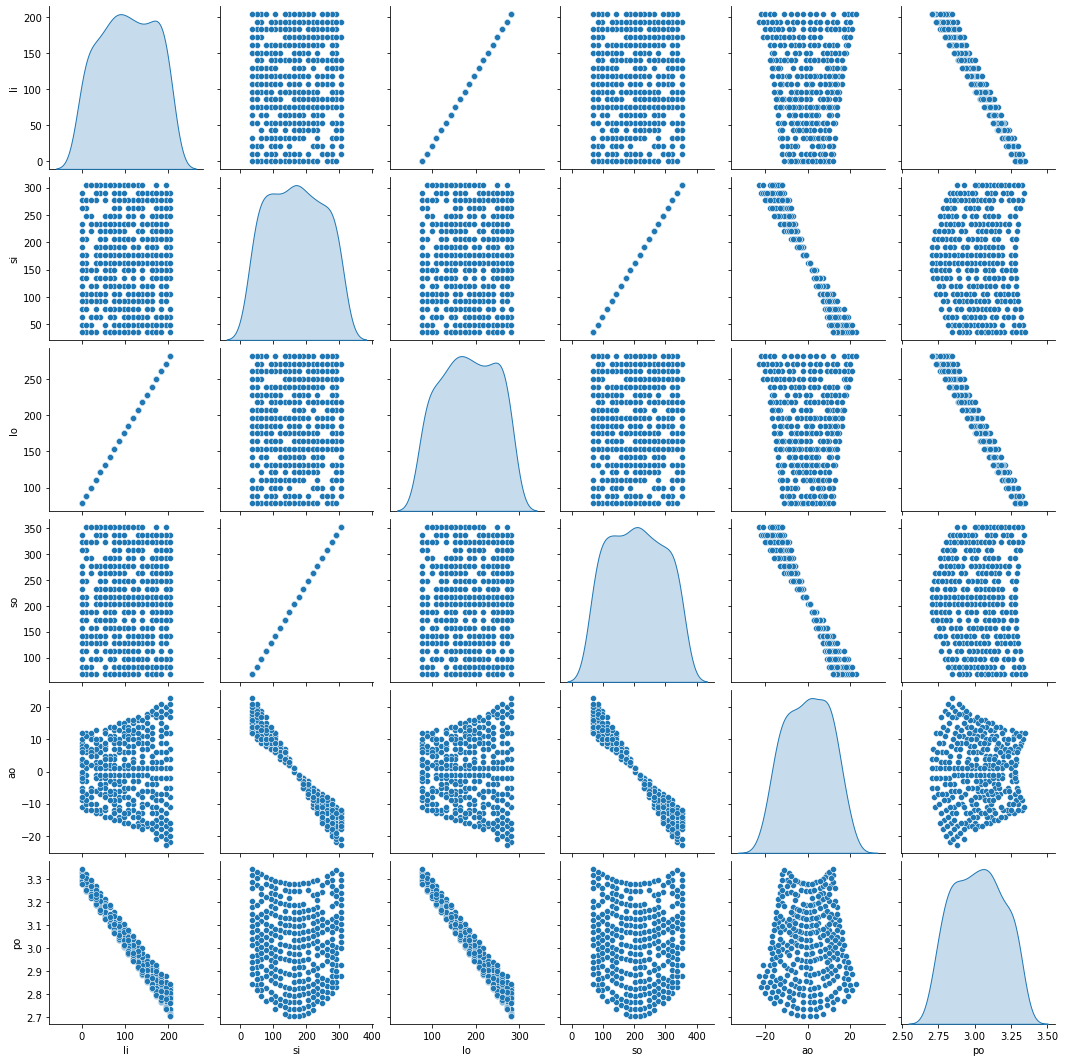

In [7]:
sns.pairplot(train_dataset[['li', 'si', 'lo', 'so','ao','po']], diag_kind='kde')

Let's also check the overall statistics. Note how each feature covers a very different range:

In [8]:
train_dataset.describe()

li          si          lo          so          ao          po
count  320.000000  320.000000  320.000000  320.000000  320.000000  320.000000
mean   105.062500  167.513158  182.418050  207.216609   -0.021875    3.020516
std     62.054214   81.568094   61.607424   85.915673   10.553468    0.168883
min      0.000000   35.000000   78.112000   67.640500  -23.000000    2.703322
25%     53.947368   91.842105  131.670947  127.512289   -9.000000    2.878891
50%    107.894737  162.894737  185.229895  202.352026    1.000000    3.017754
75%    161.842105  233.947368  238.788842  277.191763    9.000000    3.156488
max    205.000000  305.000000  281.636000  352.031500   23.000000    3.343378

In [9]:
test_dataset.describe()

li          si          lo          so         ao         po
count   80.000000   80.000000   80.000000   80.000000  80.000000  80.000000
mean    92.250000  179.947368  169.697800  220.313563  -1.200000   3.057726
std     62.581773   83.701895   62.131184   88.163206  10.630027   0.167064
min      0.000000   35.000000   78.112000   67.640500 -24.000000   2.722826
25%     32.368421  106.052632  110.247368  142.480237 -10.000000   2.916103
50%     86.315789  191.315789  163.806316  232.287921  -3.500000   3.055873
75%    151.052632  251.710526  228.077053  295.901697   8.000000   3.215419
max    205.000000  305.000000  281.636000  352.031500  22.000000   3.350362

In [10]:
# data normalization
'''li_min = train_dataset['li'].min()
li_max = train_dataset['li'].max()

df = train_dataset.copy()

df['li'] = (df['li']-li_min)/(li_max-li_min)
print(df['li'])'''

"li_min = train_dataset['li'].min()\nli_max = train_dataset['li'].max()\n\ndf = train_dataset.copy()\n\ndf['li'] = (df['li']-li_min)/(li_max-li_min)\nprint(df['li'])"

In [11]:
train_dataset

li          si          lo          so  ao        po
94    43.157895  233.947368  120.959158  277.191763  -7  3.176611
32    10.789474  205.526316   88.823789  247.255868  -3  3.253182
225  118.684211  106.052632  195.941684  142.480237   8  2.966276
157   75.526316  276.578947  153.094526  322.095605 -12  3.124435
356  183.421053  262.368421  260.212421  307.127658 -16  2.833884
..          ...         ...         ...         ...  ..       ...
224  118.684211   91.842105  195.941684  127.512289  10  2.977250
355  183.421053  248.157895  260.212421  292.159711 -14  2.815527
229  118.684211  162.894737  195.941684  202.352026   1  2.944962
308  161.842105  148.684211  238.788842  187.384079   3  2.826350
395  205.000000  248.157895  281.636000  292.159711 -16  2.761745

[320 rows x 6 columns]

### Split features from labels

Separate the target value—the "label"—from the features. This label is the value that you will train the model to predict.

In [12]:
train_features = train_dataset[['li','si']].copy()
train_labels = train_dataset[['lo','so','ao','po']].copy()

In [13]:
test_features = test_dataset[['li','si']].copy()
test_labels = test_dataset[['lo','so','ao','po']].copy()

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are:

In [14]:
train_dataset.describe().transpose()[['mean', 'std']]

mean        std
li  105.062500  62.054214
si  167.513158  81.568094
lo  182.418050  61.607424
so  207.216609  85.915673
ao   -0.021875  10.553468
po    3.020516   0.168883

It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### The Normalization layer

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [15]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`:

In [16]:
normalizer.adapt(np.array(train_features))

Calculate the mean and variance, and store them in the layer:

In [17]:
print(normalizer.mean.numpy())

[[105.062 167.513]]


When the layer is called, it returns the input data, with each feature independently normalized:

In [18]:
first = np.array(train_features[:10])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 43.16 233.95]
 [ 10.79 205.53]
 [118.68 106.05]
 [ 75.53 276.58]
 [183.42 262.37]
 [ 10.79 106.05]
 [ 32.37 134.47]
 [ 97.11 162.89]
 [161.84  91.84]
 [118.68 120.26]]

Normalized: [[-1.    0.82]
 [-1.52  0.47]
 [ 0.22 -0.75]
 [-0.48  1.34]
 [ 1.26  1.16]
 [-1.52 -0.75]
 [-1.17 -0.41]
 [-0.13 -0.06]
 [ 0.92 -0.93]
 [ 0.22 -0.58]]


## Regression with a deep neural network (DNN)

In the previous section, you implemented two linear models for single and multiple inputs.

Here, you will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer, as before (with `horsepower_normalizer` for a single-input model and `normalizer` for a multiple-input model).
* Two hidden, non-linear, `Dense` layers with the ReLU (`relu`) activation function nonlinearity.
* A linear `Dense` single-output layer.

Both models will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [19]:
def build_and_compile_model(norm, n_neurons, n_layers):
    model = keras.Sequential([norm])

    for i in range(n_layers):
        model.add(layers.Dense(n_neurons, activation='relu'))

    model.add(layers.Dense(1))
    model.compile(loss='mean_absolute_error',
                  optimizer=tf.keras.optimizers.Adam(0.01))
    return model


In [20]:
def train_and_save_model(model, features, labels, name):
    loss = model.fit(
        features,
        labels,
        validation_split=0.2,
        verbose=1, epochs=500)

    # plotting the history of loss function
    def plot_loss(history, img_name):
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.ylim([0, 10])
        plt.xlabel('Epoch')
        plt.ylabel('Error')
        plt.legend()
        plt.grid(True)
        plt.savefig(img_name + '.png')

    plot_loss(loss, name)

    model.save(name)

In [21]:
def test_model(model, features, labels, name):
    predictions = model.predict(features).flatten()

    error = predictions - labels
    print("Model: ", name, "\n")
    print(error.abs().describe())

    with open('out.txt', 'a') as f:
        print("Model: ", name, "\n", file=f)
        print('Filename:', error.abs().describe(), "\n", file=f)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense (Dense)               (None, 4)                 12        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 4)                 20        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                        

8/8 [==============================] - 0s 7ms/step - loss: 1.0893 - val_loss: 1.2304
Epoch 72/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1144 - val_loss: 1.3283
Epoch 73/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1181 - val_loss: 1.3720
Epoch 74/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1425 - val_loss: 1.2486
Epoch 75/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2603 - val_loss: 1.2514
Epoch 76/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2132 - val_loss: 1.3809
Epoch 77/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1961 - val_loss: 1.5227
Epoch 78/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1155 - val_loss: 1.3189
Epoch 79/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0693 - val_loss: 1.3401
Epoch 80/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0461 - val_loss: 1.2482
Epoch 81/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 1.0440 - val_loss: 1.2549
Epoch 155/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0217 - val_loss: 1.3601
Epoch 156/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0254 - val_loss: 1.2227
Epoch 157/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0332 - val_loss: 1.2051
Epoch 158/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0194 - val_loss: 1.2709
Epoch 159/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0672 - val_loss: 1.2135
Epoch 160/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0150 - val_loss: 1.2549
Epoch 161/500
8/8 [==============================] - 0s 10ms/step - loss: 1.0144 - val_loss: 1.2072
Epoch 162/500
8/8 [==============================] - 0s 10ms/step - loss: 1.0708 - val_loss: 1.2619
Epoch 163/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9990 - val_loss: 1.2978
Epoch 164/500
8/8 [===

Epoch 237/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1204 - val_loss: 1.3793
Epoch 238/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0406 - val_loss: 1.3346
Epoch 239/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0170 - val_loss: 1.3853
Epoch 240/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1265 - val_loss: 1.2701
Epoch 241/500
8/8 [==============================] - 0s 9ms/step - loss: 1.0417 - val_loss: 1.2613
Epoch 242/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0181 - val_loss: 1.3629
Epoch 243/500
8/8 [==============================] - 0s 9ms/step - loss: 1.0561 - val_loss: 1.2616
Epoch 244/500
8/8 [==============================] - 0s 11ms/step - loss: 1.1059 - val_loss: 1.3259
Epoch 245/500
8/8 [==============================] - 0s 11ms/step - loss: 1.0734 - val_loss: 1.2663
Epoch 246/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0452 - val_loss: 1.2525
Epoch 24

8/8 [==============================] - 0s 8ms/step - loss: 1.0784 - val_loss: 1.3065
Epoch 320/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0405 - val_loss: 1.2536
Epoch 321/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9947 - val_loss: 1.2426
Epoch 322/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9937 - val_loss: 1.2215
Epoch 323/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0223 - val_loss: 1.3022
Epoch 324/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0194 - val_loss: 1.2543
Epoch 325/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0246 - val_loss: 1.2101
Epoch 326/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0483 - val_loss: 1.2604
Epoch 327/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0247 - val_loss: 1.1988
Epoch 328/500
8/8 [==============================] - 0s 9ms/step - loss: 1.0645 - val_loss: 1.2433
Epoch 329/500
8/8 [=====

Epoch 402/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0929 - val_loss: 1.2464
Epoch 403/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0645 - val_loss: 1.2991
Epoch 404/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0051 - val_loss: 1.2290
Epoch 405/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0038 - val_loss: 1.2002
Epoch 406/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0225 - val_loss: 1.2490
Epoch 407/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0168 - val_loss: 1.2112
Epoch 408/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0278 - val_loss: 1.2173
Epoch 409/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0194 - val_loss: 1.3293
Epoch 410/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0273 - val_loss: 1.3821
Epoch 411/500
8/8 [==============================] - 0s 5ms/step - loss: 1.1010 - val_loss: 1.2240
Epoch 412/

8/8 [==============================] - 0s 6ms/step - loss: 1.1362 - val_loss: 1.2382
Epoch 485/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0054 - val_loss: 1.2853
Epoch 486/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0214 - val_loss: 1.3222
Epoch 487/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0602 - val_loss: 1.2250
Epoch 488/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0336 - val_loss: 1.2359
Epoch 489/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0035 - val_loss: 1.2528
Epoch 490/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0033 - val_loss: 1.2510
Epoch 491/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0234 - val_loss: 1.3219
Epoch 492/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0538 - val_loss: 1.3289
Epoch 493/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0048 - val_loss: 1.2828
Epoch 494/500
8/8 [=====

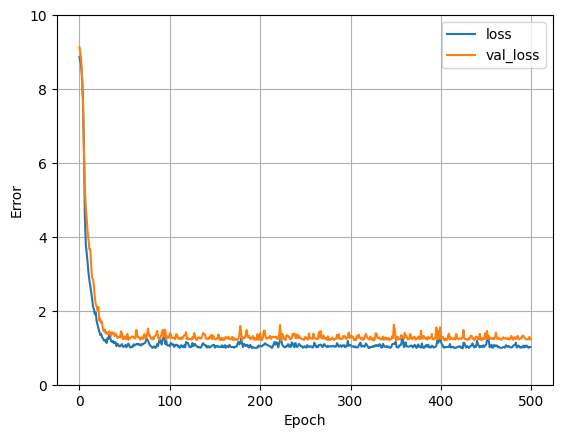

In [22]:
dnn_model = build_and_compile_model(normalizer, 4, 4)

print("DNN Model: \n", dnn_model.summary(), "\n")

train_and_save_model(dnn_model, train_features, train_labels['ao'], '4-4-ao')
test_model(dnn_model, test_features, test_labels['ao'], '4-4-ao')
# dnn_model.save('dnn_model_two_layer_64')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 4)                 12        
                                                                 
 dense_6 (Dense)             (None, 4)                 20        
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 42
Trainable params: 37
Non-trainable params: 5
_________________________________________________________________
DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 27ms/step - loss: 179.6724 - val_loss: 193.9042
Ep

8/8 [==============================] - 0s 7ms/step - loss: 0.9945 - val_loss: 1.2608
Epoch 74/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1345 - val_loss: 1.0302
Epoch 75/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0204 - val_loss: 1.0923
Epoch 76/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9203 - val_loss: 1.0047
Epoch 77/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8502 - val_loss: 0.8471
Epoch 78/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7953 - val_loss: 1.0029
Epoch 79/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8584 - val_loss: 0.9731
Epoch 80/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8878 - val_loss: 0.9705
Epoch 81/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7405 - val_loss: 0.8784
Epoch 82/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6332 - val_loss: 0.7857
Epoch 83/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.1557 - val_loss: 0.2330
Epoch 157/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1720 - val_loss: 0.2485
Epoch 158/500
8/8 [==============================] - 0s 8ms/step - loss: 0.1219 - val_loss: 0.1584
Epoch 159/500
8/8 [==============================] - 0s 13ms/step - loss: 0.1206 - val_loss: 0.2336
Epoch 160/500
8/8 [==============================] - 0s 8ms/step - loss: 0.1486 - val_loss: 0.3519
Epoch 161/500
8/8 [==============================] - 0s 8ms/step - loss: 0.1350 - val_loss: 0.2469
Epoch 162/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1394 - val_loss: 0.2312
Epoch 163/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1160 - val_loss: 0.1640
Epoch 164/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0846 - val_loss: 0.1984
Epoch 165/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1645 - val_loss: 0.2464
Epoch 166/500
8/8 [====

Epoch 239/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1049 - val_loss: 0.1642
Epoch 240/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1462 - val_loss: 0.2759
Epoch 241/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1422 - val_loss: 0.1058
Epoch 242/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0984 - val_loss: 0.1542
Epoch 243/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0936 - val_loss: 0.0894
Epoch 244/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0972 - val_loss: 0.2141
Epoch 245/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1436 - val_loss: 0.4545
Epoch 246/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2133 - val_loss: 0.2138
Epoch 247/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1220 - val_loss: 0.1330
Epoch 248/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1664 - val_loss: 0.1754
Epoch 249/

8/8 [==============================] - 0s 6ms/step - loss: 0.1762 - val_loss: 0.2189
Epoch 322/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1467 - val_loss: 0.1387
Epoch 323/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1136 - val_loss: 0.2022
Epoch 324/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1397 - val_loss: 0.0947
Epoch 325/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0790 - val_loss: 0.1576
Epoch 326/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1200 - val_loss: 0.2718
Epoch 327/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1762 - val_loss: 0.2378
Epoch 328/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1846 - val_loss: 0.1769
Epoch 329/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1110 - val_loss: 0.0907
Epoch 330/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1518 - val_loss: 0.2054
Epoch 331/500
8/8 [=====

Epoch 404/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1821 - val_loss: 0.2340
Epoch 405/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1388 - val_loss: 0.0974
Epoch 406/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0893 - val_loss: 0.1667
Epoch 407/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1210 - val_loss: 0.1411
Epoch 408/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1356 - val_loss: 0.1391
Epoch 409/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1837 - val_loss: 0.1559
Epoch 410/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1108 - val_loss: 0.2135
Epoch 411/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0914 - val_loss: 0.1351
Epoch 412/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1273 - val_loss: 0.3041
Epoch 413/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1363 - val_loss: 0.2053
Epoch 414/

8/8 [==============================] - 0s 6ms/step - loss: 0.1357 - val_loss: 0.2585
Epoch 487/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1691 - val_loss: 0.3114
Epoch 488/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1802 - val_loss: 0.1588
Epoch 489/500
8/8 [==============================] - 0s 8ms/step - loss: 0.1225 - val_loss: 0.2811
Epoch 490/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1493 - val_loss: 0.2783
Epoch 491/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2252 - val_loss: 0.2609
Epoch 492/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1289 - val_loss: 0.2160
Epoch 493/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1271 - val_loss: 0.1905
Epoch 494/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1773 - val_loss: 0.3507
Epoch 495/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1660 - val_loss: 0.1245
Epoch 496/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 0.2476 - val_loss: 0.4900
Epoch 56/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3358 - val_loss: 0.7085
Epoch 57/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3859 - val_loss: 0.5624
Epoch 58/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4061 - val_loss: 0.3372
Epoch 59/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2258 - val_loss: 0.2086
Epoch 60/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1555 - val_loss: 0.2154
Epoch 61/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1565 - val_loss: 0.2019
Epoch 62/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1541 - val_loss: 0.2707
Epoch 63/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2327 - val_loss: 0.3940
Epoch 64/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2712 - val_loss: 0.3327
Epoch 65/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.2579 - val_loss: 0.2693
Epoch 139/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1851 - val_loss: 0.2121
Epoch 140/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2119 - val_loss: 0.0794
Epoch 141/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1948 - val_loss: 0.1279
Epoch 142/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1716 - val_loss: 0.3151
Epoch 143/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2470 - val_loss: 0.1159
Epoch 144/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1495 - val_loss: 0.1293
Epoch 145/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1211 - val_loss: 0.0973
Epoch 146/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1423 - val_loss: 0.1054
Epoch 147/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1488 - val_loss: 0.2914
Epoch 148/500
8/8 [=====

Epoch 221/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3627 - val_loss: 0.5758
Epoch 222/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3920 - val_loss: 0.4608
Epoch 223/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4383 - val_loss: 0.5386
Epoch 224/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3471 - val_loss: 0.1035
Epoch 225/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2497 - val_loss: 0.3075
Epoch 226/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2063 - val_loss: 0.2425
Epoch 227/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2060 - val_loss: 0.1070
Epoch 228/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2039 - val_loss: 0.2315
Epoch 229/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1588 - val_loss: 0.1978
Epoch 230/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1843 - val_loss: 0.1961
Epoch 231/

8/8 [==============================] - 0s 5ms/step - loss: 0.2475 - val_loss: 0.0811
Epoch 304/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1378 - val_loss: 0.0690
Epoch 305/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1250 - val_loss: 0.1534
Epoch 306/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2145 - val_loss: 0.2634
Epoch 307/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2085 - val_loss: 0.2412
Epoch 308/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2600 - val_loss: 0.0991
Epoch 309/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2080 - val_loss: 0.1725
Epoch 310/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2115 - val_loss: 0.2405
Epoch 311/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1864 - val_loss: 0.2286
Epoch 312/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1954 - val_loss: 0.1487
Epoch 313/500
8/8 [=====

Epoch 386/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2640 - val_loss: 0.1197
Epoch 387/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2051 - val_loss: 0.2485
Epoch 388/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2036 - val_loss: 0.1655
Epoch 389/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1494 - val_loss: 0.1807
Epoch 390/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1895 - val_loss: 0.1613
Epoch 391/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2016 - val_loss: 0.2893
Epoch 392/500
8/8 [==============================] - 0s 8ms/step - loss: 0.1950 - val_loss: 0.2090
Epoch 393/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1753 - val_loss: 0.1774
Epoch 394/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1981 - val_loss: 0.2191
Epoch 395/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1997 - val_loss: 0.2571
Epoch 396/

8/8 [==============================] - 0s 7ms/step - loss: 0.1371 - val_loss: 0.1555
Epoch 469/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1107 - val_loss: 0.0922
Epoch 470/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1271 - val_loss: 0.2489
Epoch 471/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1564 - val_loss: 0.1297
Epoch 472/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1104 - val_loss: 0.0847
Epoch 473/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1874 - val_loss: 0.0839
Epoch 474/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0898 - val_loss: 0.0973
Epoch 475/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2103 - val_loss: 0.0802
Epoch 476/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3116 - val_loss: 0.2318
Epoch 477/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2257 - val_loss: 0.1701
Epoch 478/500
8/8 [=====

Epoch 38/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0448 - val_loss: 1.4436
Epoch 39/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9934 - val_loss: 1.4036
Epoch 40/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9368 - val_loss: 1.2726
Epoch 41/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8849 - val_loss: 1.2480
Epoch 42/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8627 - val_loss: 1.1863
Epoch 43/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8227 - val_loss: 1.0969
Epoch 44/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7870 - val_loss: 1.0770
Epoch 45/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7632 - val_loss: 1.0895
Epoch 46/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7542 - val_loss: 1.0066
Epoch 47/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7292 - val_loss: 1.0189
Epoch 48/500
8/8 [==

8/8 [==============================] - 0s 8ms/step - loss: 0.4834 - val_loss: 0.5766
Epoch 122/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4727 - val_loss: 0.5865
Epoch 123/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4977 - val_loss: 0.5774
Epoch 124/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4845 - val_loss: 0.5961
Epoch 125/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4645 - val_loss: 0.5641
Epoch 126/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4748 - val_loss: 0.5731
Epoch 127/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4718 - val_loss: 0.5978
Epoch 128/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4785 - val_loss: 0.5829
Epoch 129/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4653 - val_loss: 0.5526
Epoch 130/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4876 - val_loss: 0.5889
Epoch 131/500
8/8 [=====

Epoch 204/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4421 - val_loss: 0.5778
Epoch 205/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4435 - val_loss: 0.5325
Epoch 206/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4398 - val_loss: 0.5532
Epoch 207/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4454 - val_loss: 0.5641
Epoch 208/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4625 - val_loss: 0.5524
Epoch 209/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4718 - val_loss: 0.6056
Epoch 210/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4635 - val_loss: 0.5351
Epoch 211/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4794 - val_loss: 0.5759
Epoch 212/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4521 - val_loss: 0.5430
Epoch 213/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4480 - val_loss: 0.5402
Epoch 214/

8/8 [==============================] - 0s 7ms/step - loss: 0.4524 - val_loss: 0.5555
Epoch 287/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4382 - val_loss: 0.5358
Epoch 288/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4409 - val_loss: 0.5336
Epoch 289/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4349 - val_loss: 0.5359
Epoch 290/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4315 - val_loss: 0.5426
Epoch 291/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4448 - val_loss: 0.5646
Epoch 292/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4376 - val_loss: 0.5356
Epoch 293/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4611 - val_loss: 0.5333
Epoch 294/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4546 - val_loss: 0.5454
Epoch 295/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4422 - val_loss: 0.5352
Epoch 296/500
8/8 [=====

Epoch 369/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4437 - val_loss: 0.5536
Epoch 370/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4398 - val_loss: 0.5302
Epoch 371/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4376 - val_loss: 0.5255
Epoch 372/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4574 - val_loss: 0.5397
Epoch 373/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4457 - val_loss: 0.5187
Epoch 374/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4550 - val_loss: 0.5281
Epoch 375/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4351 - val_loss: 0.5464
Epoch 376/500
8/8 [==============================] - 0s 11ms/step - loss: 0.4361 - val_loss: 0.5402
Epoch 377/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4441 - val_loss: 0.5273
Epoch 378/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4527 - val_loss: 0.5290
Epoch 379

8/8 [==============================] - 0s 8ms/step - loss: 0.4248 - val_loss: 0.5085
Epoch 452/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4302 - val_loss: 0.4768
Epoch 453/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4287 - val_loss: 0.4833
Epoch 454/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4385 - val_loss: 0.5250
Epoch 455/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4436 - val_loss: 0.5120
Epoch 456/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4404 - val_loss: 0.5560
Epoch 457/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4462 - val_loss: 0.4856
Epoch 458/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4251 - val_loss: 0.5376
Epoch 459/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4471 - val_loss: 0.4932
Epoch 460/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4254 - val_loss: 0.4813
Epoch 461/500
8/8 [=====

Epoch 21/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0439 - val_loss: 0.0347
Epoch 22/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0386 - val_loss: 0.0359
Epoch 23/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0362 - val_loss: 0.0266
Epoch 24/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0321 - val_loss: 0.0244
Epoch 25/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0306 - val_loss: 0.0240
Epoch 26/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0270 - val_loss: 0.0214
Epoch 27/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0245 - val_loss: 0.0192
Epoch 28/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0233 - val_loss: 0.0239
Epoch 29/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0297 - val_loss: 0.0172
Epoch 30/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0321 - val_loss: 0.0413
Epoch 31/500
8/8 [==

8/8 [==============================] - 0s 7ms/step - loss: 0.0163 - val_loss: 0.0104
Epoch 105/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0152 - val_loss: 0.0118
Epoch 106/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0133
Epoch 107/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0086
Epoch 108/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0063
Epoch 109/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0067
Epoch 110/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 111/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0116
Epoch 112/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0172
Epoch 113/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0052
Epoch 114/500
8/8 [=====

Epoch 187/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0081 - val_loss: 0.0100
Epoch 188/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 189/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 190/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0050
Epoch 191/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0117
Epoch 192/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0069
Epoch 193/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0059 - val_loss: 0.0044
Epoch 194/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 195/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0079
Epoch 196/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0098 - val_loss: 0.0061
Epoch 197/

8/8 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 270/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 271/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0054 - val_loss: 0.0102
Epoch 272/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0053
Epoch 273/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0051
Epoch 274/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 275/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 276/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0072
Epoch 277/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0113
Epoch 278/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0113
Epoch 279/500
8/8 [=====

Epoch 352/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 353/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0067 - val_loss: 0.0086
Epoch 354/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0073 - val_loss: 0.0060
Epoch 355/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 356/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 357/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0069 - val_loss: 0.0123
Epoch 358/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0126
Epoch 359/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0122
Epoch 360/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 361/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0100
Epoch 362/

8/8 [==============================] - 0s 10ms/step - loss: 0.0066 - val_loss: 0.0123
Epoch 435/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0113 - val_loss: 0.0150
Epoch 436/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0077
Epoch 437/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0123
Epoch 438/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0073
Epoch 439/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0081
Epoch 440/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0052
Epoch 441/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0041
Epoch 442/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0060 - val_loss: 0.0087
Epoch 443/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0043
Epoch 444/500
8/8 [====

                                                                 
 dense_19 (Dense)            (None, 1)                 9         
                                                                 
Total params: 110
Trainable params: 105
Non-trainable params: 5
_________________________________________________________________
DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 22ms/step - loss: 179.0758 - val_loss: 192.9977
Epoch 2/500
8/8 [==============================] - 0s 6ms/step - loss: 178.1959 - val_loss: 191.8083
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 176.7723 - val_loss: 189.8628
Epoch 4/500
8/8 [==============================] - 0s 5ms/step - loss: 174.4746 - val_loss: 186.7255
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 170.8123 - val_loss: 181.8895
Epoch 6/500
8/8 [==============================] - 0s 6ms/step - loss: 165.4007 - val_loss: 174.5919
Epoch 7/500
8/8 [============================

Epoch 80/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3306 - val_loss: 0.2623
Epoch 81/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2234 - val_loss: 0.3633
Epoch 82/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3607 - val_loss: 0.8629
Epoch 83/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6305 - val_loss: 0.8220
Epoch 84/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5631 - val_loss: 0.2452
Epoch 85/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4956 - val_loss: 0.7219
Epoch 86/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4385 - val_loss: 0.3677
Epoch 87/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3284 - val_loss: 0.3898
Epoch 88/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3470 - val_loss: 0.6189
Epoch 89/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3663 - val_loss: 0.3934
Epoch 90/500
8/8 [==

Epoch 163/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6697 - val_loss: 0.6616
Epoch 164/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5120 - val_loss: 0.1798
Epoch 165/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3811 - val_loss: 0.3729
Epoch 166/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3825 - val_loss: 0.7310
Epoch 167/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5795 - val_loss: 0.5360
Epoch 168/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5853 - val_loss: 0.5475
Epoch 169/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6159 - val_loss: 0.4110
Epoch 170/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5086 - val_loss: 0.6656
Epoch 171/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4808 - val_loss: 0.3823
Epoch 172/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3874 - val_loss: 0.4180
Epoch 173/

8/8 [==============================] - 0s 7ms/step - loss: 0.1632 - val_loss: 0.2793
Epoch 246/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2658 - val_loss: 0.1274
Epoch 247/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2542 - val_loss: 0.1229
Epoch 248/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2427 - val_loss: 0.1661
Epoch 249/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2375 - val_loss: 0.3078
Epoch 250/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4617 - val_loss: 0.5886
Epoch 251/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4500 - val_loss: 0.3968
Epoch 252/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1921 - val_loss: 0.1405
Epoch 253/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1870 - val_loss: 0.1774
Epoch 254/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2774 - val_loss: 0.1915
Epoch 255/500
8/8 [=====

Epoch 328/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2067 - val_loss: 0.3073
Epoch 329/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2235 - val_loss: 0.2759
Epoch 330/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3085 - val_loss: 0.1589
Epoch 331/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3047 - val_loss: 0.1568
Epoch 332/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2251 - val_loss: 0.2357
Epoch 333/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1735 - val_loss: 0.1717
Epoch 334/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2359 - val_loss: 0.5033
Epoch 335/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2252 - val_loss: 0.1718
Epoch 336/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1613 - val_loss: 0.0948
Epoch 337/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2020 - val_loss: 0.1662
Epoch 338/

8/8 [==============================] - 0s 6ms/step - loss: 0.2865 - val_loss: 0.4605
Epoch 411/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3465 - val_loss: 0.3725
Epoch 412/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2633 - val_loss: 0.1729
Epoch 413/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1665 - val_loss: 0.1505
Epoch 414/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1929 - val_loss: 0.3051
Epoch 415/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1613 - val_loss: 0.3126
Epoch 416/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2229 - val_loss: 0.1314
Epoch 417/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1922 - val_loss: 0.2883
Epoch 418/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4355 - val_loss: 0.3038
Epoch 419/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2316 - val_loss: 0.2156
Epoch 420/500
8/8 [=====

Epoch 493/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3154 - val_loss: 0.3807
Epoch 494/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2863 - val_loss: 0.4353
Epoch 495/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2758 - val_loss: 0.4116
Epoch 496/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3555 - val_loss: 0.3875
Epoch 497/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2538 - val_loss: 0.2491
Epoch 498/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1651 - val_loss: 0.1273
Epoch 499/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1819 - val_loss: 0.3384
Epoch 500/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2284 - val_loss: 0.3795
INFO:tensorflow:Assets written to: 8-2-lo\assets
3/3 [==============================] - 0s 2ms/step
Model:  8-2-lo 

count    80.000000
mean      0.325333
std       0.199501
min       0.064698
25%       0.165

8/8 [==============================] - 0s 7ms/step - loss: 0.4713 - val_loss: 0.8654
Epoch 56/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5117 - val_loss: 0.7478
Epoch 57/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5162 - val_loss: 0.5333
Epoch 58/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5727 - val_loss: 0.7051
Epoch 59/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6069 - val_loss: 1.0932
Epoch 60/500
8/8 [==============================] - 0s 12ms/step - loss: 0.5358 - val_loss: 0.4638
Epoch 61/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2932 - val_loss: 0.5225
Epoch 62/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4470 - val_loss: 0.4943
Epoch 63/500
8/8 [==============================] - 0s 11ms/step - loss: 0.5407 - val_loss: 0.6689
Epoch 64/500
8/8 [==============================] - 0s 12ms/step - loss: 0.5405 - val_loss: 0.7493
Epoch 65/500
8/8 [============

8/8 [==============================] - 0s 9ms/step - loss: 0.3687 - val_loss: 0.3505
Epoch 139/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3084 - val_loss: 0.5807
Epoch 140/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3551 - val_loss: 0.2248
Epoch 141/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3351 - val_loss: 0.2104
Epoch 142/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2799 - val_loss: 0.2017
Epoch 143/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2215 - val_loss: 0.2119
Epoch 144/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1471 - val_loss: 0.1635
Epoch 145/500
8/8 [==============================] - 0s 9ms/step - loss: 0.1887 - val_loss: 0.4850
Epoch 146/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1892 - val_loss: 0.1808
Epoch 147/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1911 - val_loss: 0.3059
Epoch 148/500
8/8 [=====

Epoch 221/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3034 - val_loss: 0.6576
Epoch 222/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4608 - val_loss: 0.2664
Epoch 223/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3627 - val_loss: 0.3856
Epoch 224/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3286 - val_loss: 0.3878
Epoch 225/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2492 - val_loss: 0.2125
Epoch 226/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2239 - val_loss: 0.2457
Epoch 227/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2419 - val_loss: 0.2310
Epoch 228/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1877 - val_loss: 0.1573
Epoch 229/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1702 - val_loss: 0.2099
Epoch 230/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2175 - val_loss: 0.2183
Epoch 231/

8/8 [==============================] - 0s 6ms/step - loss: 0.3518 - val_loss: 0.4436
Epoch 304/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3927 - val_loss: 0.4642
Epoch 305/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3811 - val_loss: 0.6614
Epoch 306/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4201 - val_loss: 0.4474
Epoch 307/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2838 - val_loss: 0.4797
Epoch 308/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2718 - val_loss: 0.6493
Epoch 309/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3607 - val_loss: 0.3385
Epoch 310/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3520 - val_loss: 0.5528
Epoch 311/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5469 - val_loss: 0.6619
Epoch 312/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5058 - val_loss: 0.2121
Epoch 313/500
8/8 [====

Epoch 386/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2883 - val_loss: 0.6546
Epoch 387/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4213 - val_loss: 0.1187
Epoch 388/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2386 - val_loss: 0.1647
Epoch 389/500
8/8 [==============================] - 0s 5ms/step - loss: 0.1785 - val_loss: 0.1744
Epoch 390/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1575 - val_loss: 0.1985
Epoch 391/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2367 - val_loss: 0.3805
Epoch 392/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3223 - val_loss: 0.3283
Epoch 393/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3378 - val_loss: 0.2089
Epoch 394/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2122 - val_loss: 0.3273
Epoch 395/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3656 - val_loss: 0.3086
Epoch 396/

8/8 [==============================] - 0s 6ms/step - loss: 0.4392 - val_loss: 0.4886
Epoch 469/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3605 - val_loss: 0.4478
Epoch 470/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3296 - val_loss: 0.3448
Epoch 471/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4415 - val_loss: 0.4057
Epoch 472/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5451 - val_loss: 0.6719
Epoch 473/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6255 - val_loss: 0.7466
Epoch 474/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4566 - val_loss: 0.3591
Epoch 475/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1846 - val_loss: 0.1911
Epoch 476/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1507 - val_loss: 0.2347
Epoch 477/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2701 - val_loss: 0.2729
Epoch 478/500
8/8 [=====

Epoch 38/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4594 - val_loss: 0.5568
Epoch 39/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4172 - val_loss: 0.4149
Epoch 40/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3958 - val_loss: 0.4249
Epoch 41/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3768 - val_loss: 0.4172
Epoch 42/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3837 - val_loss: 0.4937
Epoch 43/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4181 - val_loss: 0.4056
Epoch 44/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3832 - val_loss: 0.4324
Epoch 45/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4030 - val_loss: 0.5034
Epoch 46/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3984 - val_loss: 0.4286
Epoch 47/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3963 - val_loss: 0.4430
Epoch 48/500
8/8 [==

8/8 [==============================] - 0s 7ms/step - loss: 0.3410 - val_loss: 0.3725
Epoch 122/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3567 - val_loss: 0.4015
Epoch 123/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3312 - val_loss: 0.4274
Epoch 124/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3547 - val_loss: 0.4545
Epoch 125/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3614 - val_loss: 0.4355
Epoch 126/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3523 - val_loss: 0.4180
Epoch 127/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3483 - val_loss: 0.4155
Epoch 128/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3292 - val_loss: 0.3767
Epoch 129/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3211 - val_loss: 0.3748
Epoch 130/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3514 - val_loss: 0.3801
Epoch 131/500
8/8 [=====

Epoch 204/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2994 - val_loss: 0.3839
Epoch 205/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3258 - val_loss: 0.3675
Epoch 206/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3183 - val_loss: 0.3316
Epoch 207/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2989 - val_loss: 0.3303
Epoch 208/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3027 - val_loss: 0.3414
Epoch 209/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3267 - val_loss: 0.3414
Epoch 210/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3301 - val_loss: 0.3507
Epoch 211/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3093 - val_loss: 0.3384
Epoch 212/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3126 - val_loss: 0.3632
Epoch 213/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3165 - val_loss: 0.3725
Epoch 214/

8/8 [==============================] - 0s 6ms/step - loss: 0.3368 - val_loss: 0.3297
Epoch 287/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3069 - val_loss: 0.3542
Epoch 288/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3103 - val_loss: 0.3611
Epoch 289/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3220 - val_loss: 0.3686
Epoch 290/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3215 - val_loss: 0.3549
Epoch 291/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3195 - val_loss: 0.3627
Epoch 292/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3095 - val_loss: 0.3451
Epoch 293/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3233 - val_loss: 0.3398
Epoch 294/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3088 - val_loss: 0.3682
Epoch 295/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3237 - val_loss: 0.3397
Epoch 296/500
8/8 [=====

Epoch 369/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2939 - val_loss: 0.3316
Epoch 370/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2860 - val_loss: 0.3402
Epoch 371/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3115 - val_loss: 0.4003
Epoch 372/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3362 - val_loss: 0.3824
Epoch 373/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3094 - val_loss: 0.3462
Epoch 374/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2940 - val_loss: 0.3483
Epoch 375/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2959 - val_loss: 0.3589
Epoch 376/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3031 - val_loss: 0.3321
Epoch 377/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2987 - val_loss: 0.3634
Epoch 378/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2890 - val_loss: 0.3238
Epoch 379/

8/8 [==============================] - 0s 7ms/step - loss: 0.2948 - val_loss: 0.3650
Epoch 452/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3194 - val_loss: 0.3882
Epoch 453/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3105 - val_loss: 0.3693
Epoch 454/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3036 - val_loss: 0.3555
Epoch 455/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2928 - val_loss: 0.3234
Epoch 456/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2916 - val_loss: 0.3433
Epoch 457/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2938 - val_loss: 0.3185
Epoch 458/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2904 - val_loss: 0.3513
Epoch 459/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2794 - val_loss: 0.3266
Epoch 460/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2665 - val_loss: 0.3424
Epoch 461/500
8/8 [=====

Epoch 21/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0491 - val_loss: 0.0460
Epoch 22/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0408 - val_loss: 0.0422
Epoch 23/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0426 - val_loss: 0.0347
Epoch 24/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0442 - val_loss: 0.0534
Epoch 25/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0340 - val_loss: 0.0343
Epoch 26/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0302 - val_loss: 0.0250
Epoch 27/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0235 - val_loss: 0.0266
Epoch 28/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0227 - val_loss: 0.0184
Epoch 29/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.0155
Epoch 30/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0182 - val_loss: 0.0243
Epoch 31/500
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 0.0232 - val_loss: 0.0286
Epoch 105/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0237 - val_loss: 0.0086
Epoch 106/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0074
Epoch 107/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0120
Epoch 108/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 109/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0277
Epoch 110/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0187 - val_loss: 0.0182
Epoch 111/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.0357
Epoch 112/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0317 - val_loss: 0.0517
Epoch 113/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - val_loss: 0.0184
Epoch 114/500
8/8 [=====

Epoch 187/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0209
Epoch 188/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0178 - val_loss: 0.0255
Epoch 189/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0144 - val_loss: 0.0119
Epoch 190/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0067
Epoch 191/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.0071
Epoch 192/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0126 - val_loss: 0.0167
Epoch 193/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0141
Epoch 194/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - val_loss: 0.0109
Epoch 195/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0133 - val_loss: 0.0105
Epoch 196/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 197

8/8 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0092
Epoch 270/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0150
Epoch 271/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0229
Epoch 272/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0152 - val_loss: 0.0114
Epoch 273/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0066
Epoch 274/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0106
Epoch 275/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0173
Epoch 276/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0093
Epoch 277/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0103
Epoch 278/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0113
Epoch 279/500
8/8 [=====

Epoch 352/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0211
Epoch 353/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.0153
Epoch 354/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0089
Epoch 355/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0091
Epoch 356/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0036
Epoch 357/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0044
Epoch 358/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 359/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 360/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0161
Epoch 361/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0110 - val_loss: 0.0096
Epoch 362/

8/8 [==============================] - 0s 7ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 435/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 436/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0045
Epoch 437/500
8/8 [==============================] - 0s 14ms/step - loss: 0.0061 - val_loss: 0.0044
Epoch 438/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0052
Epoch 439/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0106
Epoch 440/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0094 - val_loss: 0.0049
Epoch 441/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.0089
Epoch 442/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0049
Epoch 443/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0030
Epoch 444/500
8/8 [===

8/8 [==============================] - 0s 6ms/step - loss: 173.8315 - val_loss: 185.6697
Epoch 4/500
8/8 [==============================] - 0s 9ms/step - loss: 167.8573 - val_loss: 177.7983
Epoch 5/500
8/8 [==============================] - 0s 7ms/step - loss: 157.5711 - val_loss: 164.7699
Epoch 6/500
8/8 [==============================] - 0s 8ms/step - loss: 141.1255 - val_loss: 144.9053
Epoch 7/500
8/8 [==============================] - 0s 8ms/step - loss: 119.1671 - val_loss: 121.6910
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 97.9579 - val_loss: 96.2422
Epoch 9/500
8/8 [==============================] - 0s 7ms/step - loss: 76.1695 - val_loss: 68.2653
Epoch 10/500
8/8 [==============================] - 0s 9ms/step - loss: 50.4009 - val_loss: 38.0186
Epoch 11/500
8/8 [==============================] - 0s 6ms/step - loss: 30.8105 - val_loss: 26.3223
Epoch 12/500
8/8 [==============================] - 0s 6ms/step - loss: 24.1690 - val_loss: 16.6393
Epoch 13/

8/8 [==============================] - 0s 6ms/step - loss: 0.3607 - val_loss: 0.6307
Epoch 87/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5863 - val_loss: 1.0129
Epoch 88/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8709 - val_loss: 0.6118
Epoch 89/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5501 - val_loss: 0.2288
Epoch 90/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3363 - val_loss: 0.3791
Epoch 91/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3937 - val_loss: 0.4946
Epoch 92/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5133 - val_loss: 0.7057
Epoch 93/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3950 - val_loss: 0.3773
Epoch 94/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3061 - val_loss: 0.4033
Epoch 95/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4352 - val_loss: 0.2129
Epoch 96/500
8/8 [===============

8/8 [==============================] - 0s 9ms/step - loss: 0.3303 - val_loss: 0.2916
Epoch 170/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2680 - val_loss: 0.3328
Epoch 171/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4724 - val_loss: 0.7031
Epoch 172/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7138 - val_loss: 0.5640
Epoch 173/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7104 - val_loss: 0.9972
Epoch 174/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6143 - val_loss: 0.5067
Epoch 175/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5175 - val_loss: 0.5757
Epoch 176/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4757 - val_loss: 0.4685
Epoch 177/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4311 - val_loss: 0.4193
Epoch 178/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2456 - val_loss: 0.2257
Epoch 179/500
8/8 [=====

Epoch 252/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4880 - val_loss: 0.2139
Epoch 253/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3798 - val_loss: 0.4248
Epoch 254/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4347 - val_loss: 0.6106
Epoch 255/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4731 - val_loss: 0.4257
Epoch 256/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4323 - val_loss: 0.6130
Epoch 257/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4741 - val_loss: 0.3477
Epoch 258/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4646 - val_loss: 0.7386
Epoch 259/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3967 - val_loss: 0.5111
Epoch 260/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4676 - val_loss: 0.1674
Epoch 261/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2239 - val_loss: 0.4168
Epoch 262/

8/8 [==============================] - 0s 7ms/step - loss: 0.3423 - val_loss: 0.4584
Epoch 335/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4309 - val_loss: 1.0715
Epoch 336/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6638 - val_loss: 0.8371
Epoch 337/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7444 - val_loss: 0.6477
Epoch 338/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8225 - val_loss: 1.0835
Epoch 339/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7137 - val_loss: 0.3074
Epoch 340/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3577 - val_loss: 0.6910
Epoch 341/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4362 - val_loss: 0.1231
Epoch 342/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2817 - val_loss: 0.2803
Epoch 343/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3412 - val_loss: 0.4127
Epoch 344/500
8/8 [=====

Epoch 417/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2612 - val_loss: 0.1176
Epoch 418/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3397 - val_loss: 0.7816
Epoch 419/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5129 - val_loss: 0.2755
Epoch 420/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2089 - val_loss: 0.1607
Epoch 421/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2078 - val_loss: 0.1725
Epoch 422/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3710 - val_loss: 0.1413
Epoch 423/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7520 - val_loss: 0.6372
Epoch 424/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7130 - val_loss: 0.7009
Epoch 425/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6093 - val_loss: 0.7600
Epoch 426/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7106 - val_loss: 1.0310
Epoch 427/

8/8 [==============================] - 0s 7ms/step - loss: 0.4053 - val_loss: 0.2957
Epoch 500/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5126 - val_loss: 0.1564
INFO:tensorflow:Assets written to: 16-2-lo\assets
3/3 [==============================] - 0s 2ms/step
Model:  16-2-lo 

count    80.000000
mean      0.134032
std       0.077048
min       0.010834
25%       0.071446
50%       0.129393
75%       0.173629
max       0.316759
Name: lo, dtype: float64
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_32 (Dense)            (None, 16)                48        
                                                                 
 dense_33 (Dense)            (None,

8/8 [==============================] - 0s 6ms/step - loss: 0.6334 - val_loss: 0.2056
Epoch 69/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2844 - val_loss: 0.8396
Epoch 70/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6915 - val_loss: 1.0039
Epoch 71/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7409 - val_loss: 0.4336
Epoch 72/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4812 - val_loss: 0.6015
Epoch 73/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5227 - val_loss: 0.5510
Epoch 74/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4949 - val_loss: 0.5387
Epoch 75/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7364 - val_loss: 0.9036
Epoch 76/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7001 - val_loss: 0.7804
Epoch 77/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6671 - val_loss: 0.4291
Epoch 78/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.6005 - val_loss: 0.2766
Epoch 152/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7516 - val_loss: 0.8137
Epoch 153/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7102 - val_loss: 0.1790
Epoch 154/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3901 - val_loss: 0.5347
Epoch 155/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5245 - val_loss: 0.5126
Epoch 156/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6728 - val_loss: 0.9127
Epoch 157/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8307 - val_loss: 1.5088
Epoch 158/500
8/8 [==============================] - 0s 10ms/step - loss: 0.9445 - val_loss: 0.9389
Epoch 159/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4976 - val_loss: 0.3915
Epoch 160/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4969 - val_loss: 0.6588
Epoch 161/500
8/8 [====

Epoch 234/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3823 - val_loss: 0.4369
Epoch 235/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3848 - val_loss: 0.7266
Epoch 236/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5012 - val_loss: 0.3982
Epoch 237/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4157 - val_loss: 0.3576
Epoch 238/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4268 - val_loss: 0.2897
Epoch 239/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3121 - val_loss: 0.2344
Epoch 240/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2730 - val_loss: 0.4064
Epoch 241/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3913 - val_loss: 0.4082
Epoch 242/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3774 - val_loss: 0.4115
Epoch 243/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3579 - val_loss: 0.3690
Epoch 244/

8/8 [==============================] - 0s 9ms/step - loss: 0.4215 - val_loss: 0.3993
Epoch 317/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2924 - val_loss: 0.3442
Epoch 318/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4947 - val_loss: 0.3859
Epoch 319/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5860 - val_loss: 0.5018
Epoch 320/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3284 - val_loss: 0.2757
Epoch 321/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3952 - val_loss: 0.6000
Epoch 322/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5768 - val_loss: 0.6711
Epoch 323/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3520 - val_loss: 0.3430
Epoch 324/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2574 - val_loss: 0.2143
Epoch 325/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3239 - val_loss: 0.4820
Epoch 326/500
8/8 [=====

Epoch 399/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5162 - val_loss: 1.1970
Epoch 400/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8177 - val_loss: 0.5112
Epoch 401/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4262 - val_loss: 0.4310
Epoch 402/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3258 - val_loss: 0.3526
Epoch 403/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2872 - val_loss: 0.4308
Epoch 404/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3501 - val_loss: 0.4672
Epoch 405/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4319 - val_loss: 0.3241
Epoch 406/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5278 - val_loss: 0.4974
Epoch 407/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6125 - val_loss: 0.6647
Epoch 408/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5841 - val_loss: 0.9700
Epoch 409/

8/8 [==============================] - 0s 7ms/step - loss: 0.7965 - val_loss: 1.2147
Epoch 482/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8620 - val_loss: 0.6016
Epoch 483/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5636 - val_loss: 0.4313
Epoch 484/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2741 - val_loss: 0.2865
Epoch 485/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2551 - val_loss: 0.2480
Epoch 486/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2101 - val_loss: 0.1798
Epoch 487/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2669 - val_loss: 0.2332
Epoch 488/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2403 - val_loss: 0.2262
Epoch 489/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2515 - val_loss: 0.2250
Epoch 490/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2680 - val_loss: 0.7003
Epoch 491/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 0.3214 - val_loss: 0.3991
Epoch 52/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3751 - val_loss: 0.3071
Epoch 53/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3555 - val_loss: 0.2869
Epoch 54/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3655 - val_loss: 0.4826
Epoch 55/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3236 - val_loss: 0.2926
Epoch 56/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3011 - val_loss: 0.2913
Epoch 57/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2840 - val_loss: 0.2655
Epoch 58/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2800 - val_loss: 0.3776
Epoch 59/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3038 - val_loss: 0.2690
Epoch 60/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2777 - val_loss: 0.3659
Epoch 61/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.2964 - val_loss: 0.3056
Epoch 135/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2970 - val_loss: 0.3514
Epoch 136/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2753 - val_loss: 0.2967
Epoch 137/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2512 - val_loss: 0.3370
Epoch 138/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2701 - val_loss: 0.2909
Epoch 139/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2713 - val_loss: 0.2508
Epoch 140/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2482 - val_loss: 0.3186
Epoch 141/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2549 - val_loss: 0.3146
Epoch 142/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2622 - val_loss: 0.3215
Epoch 143/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2699 - val_loss: 0.2897
Epoch 144/500
8/8 [=====

Epoch 217/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2682 - val_loss: 0.3606
Epoch 218/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2650 - val_loss: 0.2848
Epoch 219/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2653 - val_loss: 0.3004
Epoch 220/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2366 - val_loss: 0.2451
Epoch 221/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2375 - val_loss: 0.3058
Epoch 222/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2686 - val_loss: 0.3596
Epoch 223/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2419 - val_loss: 0.2787
Epoch 224/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2626 - val_loss: 0.3069
Epoch 225/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2560 - val_loss: 0.2781
Epoch 226/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2685 - val_loss: 0.2791
Epoch 227/

8/8 [==============================] - 0s 6ms/step - loss: 0.2381 - val_loss: 0.2881
Epoch 300/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2593 - val_loss: 0.2608
Epoch 301/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2788 - val_loss: 0.2785
Epoch 302/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2431 - val_loss: 0.2661
Epoch 303/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2232 - val_loss: 0.2880
Epoch 304/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2650 - val_loss: 0.2777
Epoch 305/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2547 - val_loss: 0.2630
Epoch 306/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2587 - val_loss: 0.3274
Epoch 307/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2684 - val_loss: 0.3363
Epoch 308/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2914 - val_loss: 0.2831
Epoch 309/500
8/8 [=====

Epoch 382/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2453 - val_loss: 0.3739
Epoch 383/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3229 - val_loss: 0.2823
Epoch 384/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2630 - val_loss: 0.3291
Epoch 385/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2455 - val_loss: 0.3452
Epoch 386/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2663 - val_loss: 0.2728
Epoch 387/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2497 - val_loss: 0.2656
Epoch 388/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2432 - val_loss: 0.3344
Epoch 389/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2394 - val_loss: 0.2684
Epoch 390/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2545 - val_loss: 0.3402
Epoch 391/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2647 - val_loss: 0.2700
Epoch 392/

8/8 [==============================] - 0s 7ms/step - loss: 0.2890 - val_loss: 0.3269
Epoch 465/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2612 - val_loss: 0.2981
Epoch 466/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2653 - val_loss: 0.2719
Epoch 467/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2462 - val_loss: 0.2677
Epoch 468/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2464 - val_loss: 0.2544
Epoch 469/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2200 - val_loss: 0.2588
Epoch 470/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2378 - val_loss: 0.2999
Epoch 471/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2238 - val_loss: 0.2855
Epoch 472/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2469 - val_loss: 0.3560
Epoch 473/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2596 - val_loss: 0.2290
Epoch 474/500
8/8 [=====

Epoch 34/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0228 - val_loss: 0.0241
Epoch 35/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0207 - val_loss: 0.0255
Epoch 36/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0144
Epoch 37/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0188 - val_loss: 0.0144
Epoch 38/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0168 - val_loss: 0.0095
Epoch 39/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0139 - val_loss: 0.0136
Epoch 40/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0145 - val_loss: 0.0144
Epoch 41/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0135 - val_loss: 0.0146
Epoch 42/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.0262
Epoch 43/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0258 - val_loss: 0.0163
Epoch 44/500
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - val_loss: 0.0224
Epoch 118/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0163 - val_loss: 0.0142
Epoch 119/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 120/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0147
Epoch 121/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0194 - val_loss: 0.0250
Epoch 122/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0137
Epoch 123/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0128
Epoch 124/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0198
Epoch 125/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.0131
Epoch 126/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 0.0127
Epoch 127/500
8/8 [=====

Epoch 200/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0200 - val_loss: 0.0081
Epoch 201/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0160 - val_loss: 0.0252
Epoch 202/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0172 - val_loss: 0.0134
Epoch 203/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.0086
Epoch 204/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0084 - val_loss: 0.0106
Epoch 205/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0109 - val_loss: 0.0096
Epoch 206/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0119
Epoch 207/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0098
Epoch 208/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0075
Epoch 209/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0110 - val_loss: 0.0106
Epoch 210/

8/8 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 283/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0265
Epoch 284/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0222 - val_loss: 0.0203
Epoch 285/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0142
Epoch 286/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0182
Epoch 287/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0062
Epoch 288/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0053
Epoch 289/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0137
Epoch 290/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0153
Epoch 291/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 292/500
8/8 [=====

Epoch 365/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0056
Epoch 366/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0042
Epoch 367/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0056
Epoch 368/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 369/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0088 - val_loss: 0.0130
Epoch 370/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0057
Epoch 371/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0062 - val_loss: 0.0091
Epoch 372/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0071
Epoch 373/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0213 - val_loss: 0.0186
Epoch 374/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0144 - val_loss: 0.0246
Epoch 375/

8/8 [==============================] - 0s 8ms/step - loss: 0.0131 - val_loss: 0.0148
Epoch 448/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0147 - val_loss: 0.0112
Epoch 449/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 0.0156
Epoch 450/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0080
Epoch 451/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0182 - val_loss: 0.0087
Epoch 452/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0352
Epoch 453/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0255 - val_loss: 0.0166
Epoch 454/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0244 - val_loss: 0.0230
Epoch 455/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0206 - val_loss: 0.0376
Epoch 456/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0246 - val_loss: 0.0108
Epoch 457/500
8/8 [====

8/8 [==============================] - 0s 7ms/step - loss: 3.5056 - val_loss: 3.6686
Epoch 17/500
8/8 [==============================] - 0s 7ms/step - loss: 2.8057 - val_loss: 2.0989
Epoch 18/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1348 - val_loss: 2.2519
Epoch 19/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7504 - val_loss: 1.8561
Epoch 20/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4520 - val_loss: 0.9886
Epoch 21/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0717 - val_loss: 1.6884
Epoch 22/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6144 - val_loss: 1.7243
Epoch 23/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1617 - val_loss: 1.3446
Epoch 24/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2343 - val_loss: 1.3920
Epoch 25/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9302 - val_loss: 0.6303
Epoch 26/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.6208 - val_loss: 0.3158
Epoch 100/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8303 - val_loss: 0.6489
Epoch 101/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6013 - val_loss: 0.5723
Epoch 102/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7688 - val_loss: 0.7622
Epoch 103/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7299 - val_loss: 0.9786
Epoch 104/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7050 - val_loss: 0.6826
Epoch 105/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5762 - val_loss: 0.8257
Epoch 106/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6162 - val_loss: 0.2025
Epoch 107/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8907 - val_loss: 0.5680
Epoch 108/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1674 - val_loss: 0.9174
Epoch 109/500
8/8 [=====

Epoch 182/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4169 - val_loss: 0.5735
Epoch 183/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5779 - val_loss: 1.4296
Epoch 184/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3523 - val_loss: 1.2430
Epoch 185/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8639 - val_loss: 0.3228
Epoch 186/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8685 - val_loss: 0.9688
Epoch 187/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5295 - val_loss: 0.2367
Epoch 188/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6275 - val_loss: 1.1759
Epoch 189/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0645 - val_loss: 1.2952
Epoch 190/500
8/8 [==============================] - 0s 9ms/step - loss: 1.0160 - val_loss: 1.0123
Epoch 191/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6115 - val_loss: 0.2313
Epoch 192/

8/8 [==============================] - 0s 7ms/step - loss: 0.3704 - val_loss: 0.6716
Epoch 265/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4394 - val_loss: 0.3573
Epoch 266/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5735 - val_loss: 0.2306
Epoch 267/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6037 - val_loss: 0.4365
Epoch 268/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6421 - val_loss: 0.9707
Epoch 269/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6902 - val_loss: 0.7848
Epoch 270/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4951 - val_loss: 0.7951
Epoch 271/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0202 - val_loss: 0.6963
Epoch 272/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1596 - val_loss: 1.3844
Epoch 273/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2243 - val_loss: 1.1036
Epoch 274/500
8/8 [=====

Epoch 347/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4021 - val_loss: 0.5967
Epoch 348/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6010 - val_loss: 0.7372
Epoch 349/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6910 - val_loss: 0.3782
Epoch 350/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7842 - val_loss: 0.6737
Epoch 351/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6368 - val_loss: 1.3155
Epoch 352/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9353 - val_loss: 0.8494
Epoch 353/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5484 - val_loss: 0.5411
Epoch 354/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3882 - val_loss: 0.3362
Epoch 355/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3652 - val_loss: 0.6271
Epoch 356/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6091 - val_loss: 0.2334
Epoch 357/

8/8 [==============================] - 0s 8ms/step - loss: 0.3652 - val_loss: 0.3673
Epoch 430/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3057 - val_loss: 0.8449
Epoch 431/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4203 - val_loss: 0.5679
Epoch 432/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3673 - val_loss: 0.5751
Epoch 433/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9392 - val_loss: 0.8235
Epoch 434/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9217 - val_loss: 0.8348
Epoch 435/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6584 - val_loss: 0.6780
Epoch 436/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8569 - val_loss: 0.9332
Epoch 437/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8808 - val_loss: 0.8860
Epoch 438/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7287 - val_loss: 0.7039
Epoch 439/500
8/8 [=====

Total params: 1,190
Trainable params: 1,185
Non-trainable params: 5
_________________________________________________________________
DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 29ms/step - loss: 202.9349 - val_loss: 216.1335
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 198.2535 - val_loss: 208.5832
Epoch 3/500
8/8 [==============================] - 0s 7ms/step - loss: 187.6040 - val_loss: 192.7330
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 166.1556 - val_loss: 163.2256
Epoch 5/500
8/8 [==============================] - 0s 7ms/step - loss: 131.5651 - val_loss: 122.3361
Epoch 6/500
8/8 [==============================] - 0s 6ms/step - loss: 95.4153 - val_loss: 74.5779
Epoch 7/500
8/8 [==============================] - 0s 6ms/step - loss: 53.2311 - val_loss: 34.2547
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 35.8151 - val_loss: 27.0632
Epoch 9/500
8/8 [==========================

8/8 [==============================] - 0s 6ms/step - loss: 0.7726 - val_loss: 0.6925
Epoch 83/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9042 - val_loss: 1.5429
Epoch 84/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2574 - val_loss: 1.2093
Epoch 85/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0949 - val_loss: 0.8316
Epoch 86/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8248 - val_loss: 1.8183
Epoch 87/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0125 - val_loss: 0.2741
Epoch 88/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7860 - val_loss: 1.2517
Epoch 89/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0326 - val_loss: 1.3653
Epoch 90/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5505 - val_loss: 0.3684
Epoch 91/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2573 - val_loss: 2.0984
Epoch 92/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.6719 - val_loss: 0.6259
Epoch 166/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5350 - val_loss: 0.1972
Epoch 167/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3504 - val_loss: 0.5305
Epoch 168/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5919 - val_loss: 0.5967
Epoch 169/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5666 - val_loss: 0.3282
Epoch 170/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3495 - val_loss: 0.2963
Epoch 171/500
8/8 [==============================] - 0s 10ms/step - loss: 0.4211 - val_loss: 0.4930
Epoch 172/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6705 - val_loss: 0.8040
Epoch 173/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6276 - val_loss: 1.0778
Epoch 174/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6975 - val_loss: 0.5285
Epoch 175/500
8/8 [====

Epoch 248/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1325 - val_loss: 0.9248
Epoch 249/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8129 - val_loss: 0.6507
Epoch 250/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4457 - val_loss: 0.2328
Epoch 251/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5093 - val_loss: 1.1765
Epoch 252/500
8/8 [==============================] - 0s 10ms/step - loss: 0.8996 - val_loss: 0.7249
Epoch 253/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4946 - val_loss: 0.6288
Epoch 254/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5745 - val_loss: 0.9484
Epoch 255/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6154 - val_loss: 0.7131
Epoch 256/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5245 - val_loss: 0.4116
Epoch 257/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4507 - val_loss: 0.1950
Epoch 258

8/8 [==============================] - 0s 11ms/step - loss: 0.5069 - val_loss: 0.2924
Epoch 331/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7030 - val_loss: 0.8033
Epoch 332/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6122 - val_loss: 0.5980
Epoch 333/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8384 - val_loss: 0.3445
Epoch 334/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4414 - val_loss: 0.6706
Epoch 335/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5438 - val_loss: 0.4546
Epoch 336/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4668 - val_loss: 0.3681
Epoch 337/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5869 - val_loss: 0.6187
Epoch 338/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8104 - val_loss: 0.6597
Epoch 339/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8176 - val_loss: 0.8247
Epoch 340/500
8/8 [====

Epoch 413/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0196 - val_loss: 0.8418
Epoch 414/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5954 - val_loss: 0.9820
Epoch 415/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9803 - val_loss: 0.3749
Epoch 416/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0431 - val_loss: 2.2345
Epoch 417/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2156 - val_loss: 0.5913
Epoch 418/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4996 - val_loss: 0.2064
Epoch 419/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8234 - val_loss: 0.7456
Epoch 420/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1927 - val_loss: 1.0631
Epoch 421/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9993 - val_loss: 0.7692
Epoch 422/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6515 - val_loss: 0.1756
Epoch 423/

8/8 [==============================] - 0s 6ms/step - loss: 0.8929 - val_loss: 0.7507
Epoch 496/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9226 - val_loss: 0.7087
Epoch 497/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7666 - val_loss: 0.7217
Epoch 498/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6350 - val_loss: 0.4816
Epoch 499/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7380 - val_loss: 0.5526
Epoch 500/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1064 - val_loss: 1.1574
INFO:tensorflow:Assets written to: 32-2-so\assets
3/3 [==============================] - 0s 2ms/step
Model:  32-2-so 

count    80.000000
mean      1.243898
std       0.477695
min       0.434781
25%       0.836231
50%       1.224933
75%       1.680813
max       2.236200
Name: so, dtype: float64
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output

8/8 [==============================] - 0s 8ms/step - loss: 0.2829 - val_loss: 0.3016
Epoch 66/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2529 - val_loss: 0.3147
Epoch 67/500
8/8 [==============================] - 0s 10ms/step - loss: 0.2368 - val_loss: 0.3087
Epoch 68/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2723 - val_loss: 0.3118
Epoch 69/500
8/8 [==============================] - 0s 10ms/step - loss: 0.3186 - val_loss: 0.3292
Epoch 70/500
8/8 [==============================] - 0s 10ms/step - loss: 0.2891 - val_loss: 0.3025
Epoch 71/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2624 - val_loss: 0.2591
Epoch 72/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2509 - val_loss: 0.2808
Epoch 73/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2531 - val_loss: 0.3274
Epoch 74/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2609 - val_loss: 0.3185
Epoch 75/500
8/8 [============

8/8 [==============================] - 0s 9ms/step - loss: 0.2555 - val_loss: 0.2708
Epoch 149/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2354 - val_loss: 0.3049
Epoch 150/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2405 - val_loss: 0.4414
Epoch 151/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2974 - val_loss: 0.3344
Epoch 152/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3014 - val_loss: 0.3595
Epoch 153/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2627 - val_loss: 0.2414
Epoch 154/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2799 - val_loss: 0.3240
Epoch 155/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2779 - val_loss: 0.2894
Epoch 156/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3170 - val_loss: 0.4154
Epoch 157/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2712 - val_loss: 0.3314
Epoch 158/500
8/8 [=====

Epoch 231/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3045 - val_loss: 0.2712
Epoch 232/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2935 - val_loss: 0.3028
Epoch 233/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2400 - val_loss: 0.2937
Epoch 234/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2761 - val_loss: 0.4389
Epoch 235/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3665 - val_loss: 0.4919
Epoch 236/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3333 - val_loss: 0.3187
Epoch 237/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2502 - val_loss: 0.3290
Epoch 238/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2374 - val_loss: 0.3484
Epoch 239/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2290 - val_loss: 0.3491
Epoch 240/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2477 - val_loss: 0.3300
Epoch 241/

8/8 [==============================] - 0s 9ms/step - loss: 0.2614 - val_loss: 0.2923
Epoch 314/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2409 - val_loss: 0.2863
Epoch 315/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2226 - val_loss: 0.2718
Epoch 316/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2108 - val_loss: 0.2998
Epoch 317/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2399 - val_loss: 0.2550
Epoch 318/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2204 - val_loss: 0.2726
Epoch 319/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2497 - val_loss: 0.2707
Epoch 320/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2372 - val_loss: 0.2873
Epoch 321/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2183 - val_loss: 0.2679
Epoch 322/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2283 - val_loss: 0.2493
Epoch 323/500
8/8 [=====

Epoch 396/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2336 - val_loss: 0.3056
Epoch 397/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2479 - val_loss: 0.3216
Epoch 398/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2339 - val_loss: 0.3029
Epoch 399/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2391 - val_loss: 0.2604
Epoch 400/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2238 - val_loss: 0.2902
Epoch 401/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2210 - val_loss: 0.2828
Epoch 402/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2365 - val_loss: 0.2823
Epoch 403/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2772 - val_loss: 0.3169
Epoch 404/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2446 - val_loss: 0.2521
Epoch 405/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2195 - val_loss: 0.2963
Epoch 406/

8/8 [==============================] - 0s 9ms/step - loss: 0.2409 - val_loss: 0.2535
Epoch 479/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2367 - val_loss: 0.2737
Epoch 480/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2031 - val_loss: 0.2769
Epoch 481/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2259 - val_loss: 0.3288
Epoch 482/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2675 - val_loss: 0.3397
Epoch 483/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2728 - val_loss: 0.3345
Epoch 484/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2671 - val_loss: 0.3340
Epoch 485/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2453 - val_loss: 0.2632
Epoch 486/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2349 - val_loss: 0.3195
Epoch 487/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2476 - val_loss: 0.2751
Epoch 488/500
8/8 [=====

Epoch 48/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0284 - val_loss: 0.0296
Epoch 49/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0266 - val_loss: 0.0147
Epoch 50/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0206 - val_loss: 0.0222
Epoch 51/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0262 - val_loss: 0.0235
Epoch 52/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0198 - val_loss: 0.0227
Epoch 53/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0438 - val_loss: 0.0472
Epoch 54/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0452 - val_loss: 0.0415
Epoch 55/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0410 - val_loss: 0.0302
Epoch 56/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0373 - val_loss: 0.0510
Epoch 57/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0434 - val_loss: 0.0245
Epoch 58/500
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 0.0360 - val_loss: 0.0370
Epoch 132/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0355 - val_loss: 0.0779
Epoch 133/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0429 - val_loss: 0.0286
Epoch 134/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0247 - val_loss: 0.0285
Epoch 135/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0281 - val_loss: 0.0255
Epoch 136/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0215 - val_loss: 0.0179
Epoch 137/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0277 - val_loss: 0.0120
Epoch 138/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0128 - val_loss: 0.0093
Epoch 139/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0074
Epoch 140/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.0093
Epoch 141/500
8/8 [====

Epoch 214/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0178 - val_loss: 0.0212
Epoch 215/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0153 - val_loss: 0.0282
Epoch 216/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0202 - val_loss: 0.0058
Epoch 217/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0107 - val_loss: 0.0172
Epoch 218/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0160 - val_loss: 0.0173
Epoch 219/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0173 - val_loss: 0.0187
Epoch 220/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0218 - val_loss: 0.0108
Epoch 221/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0235 - val_loss: 0.0159
Epoch 222/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0221 - val_loss: 0.0264
Epoch 223/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0263 - val_loss: 0.0174
Epoch 224

8/8 [==============================] - 0s 8ms/step - loss: 0.0196 - val_loss: 0.0190
Epoch 297/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0169 - val_loss: 0.0065
Epoch 298/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0129 - val_loss: 0.0275
Epoch 299/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0117 - val_loss: 0.0150
Epoch 300/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0352
Epoch 301/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0279 - val_loss: 0.0109
Epoch 302/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0209 - val_loss: 0.0072
Epoch 303/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0155
Epoch 304/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0178 - val_loss: 0.0076
Epoch 305/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0223 - val_loss: 0.0093
Epoch 306/500
8/8 [====

Epoch 379/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0104
Epoch 380/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - val_loss: 0.0102
Epoch 381/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0317 - val_loss: 0.0398
Epoch 382/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - val_loss: 0.0105
Epoch 383/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0188
Epoch 384/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 385/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0138
Epoch 386/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0130 - val_loss: 0.0166
Epoch 387/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0099 - val_loss: 0.0134
Epoch 388/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0147 - val_loss: 0.0120
Epoch 389/

8/8 [==============================] - 0s 5ms/step - loss: 0.0221 - val_loss: 0.0151
Epoch 462/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0108
Epoch 463/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0089 - val_loss: 0.0059
Epoch 464/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0198 - val_loss: 0.0074
Epoch 465/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0198 - val_loss: 0.0153
Epoch 466/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0188 - val_loss: 0.0224
Epoch 467/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0273 - val_loss: 0.0312
Epoch 468/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0261 - val_loss: 0.0432
Epoch 469/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0341 - val_loss: 0.0352
Epoch 470/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0216 - val_loss: 0.0362
Epoch 471/500
8/8 [=====

Epoch 29/500
8/8 [==============================] - 0s 5ms/step - loss: 2.4364 - val_loss: 1.9340
Epoch 30/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1155 - val_loss: 2.3531
Epoch 31/500
8/8 [==============================] - 0s 5ms/step - loss: 1.8838 - val_loss: 1.3910
Epoch 32/500
8/8 [==============================] - 0s 5ms/step - loss: 1.3886 - val_loss: 1.2959
Epoch 33/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3685 - val_loss: 0.9814
Epoch 34/500
8/8 [==============================] - 0s 5ms/step - loss: 0.9259 - val_loss: 0.7438
Epoch 35/500
8/8 [==============================] - 0s 5ms/step - loss: 0.8645 - val_loss: 0.5141
Epoch 36/500
8/8 [==============================] - 0s 5ms/step - loss: 0.8770 - val_loss: 0.9155
Epoch 37/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7664 - val_loss: 0.5897
Epoch 38/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6598 - val_loss: 0.5786
Epoch 39/500
8/8 [==

8/8 [==============================] - 0s 7ms/step - loss: 0.3901 - val_loss: 1.0873
Epoch 113/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7154 - val_loss: 1.2741
Epoch 114/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6578 - val_loss: 0.1783
Epoch 115/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1947 - val_loss: 0.1080
Epoch 116/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3352 - val_loss: 0.2462
Epoch 117/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2027 - val_loss: 0.3132
Epoch 118/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3094 - val_loss: 0.3896
Epoch 119/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3773 - val_loss: 0.4708
Epoch 120/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3442 - val_loss: 0.4878
Epoch 121/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3469 - val_loss: 0.4471
Epoch 122/500
8/8 [=====

Epoch 195/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4182 - val_loss: 0.3775
Epoch 196/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3131 - val_loss: 0.4188
Epoch 197/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3311 - val_loss: 0.5681
Epoch 198/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3927 - val_loss: 0.3153
Epoch 199/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3536 - val_loss: 0.4467
Epoch 200/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2491 - val_loss: 0.4992
Epoch 201/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3428 - val_loss: 0.4870
Epoch 202/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3561 - val_loss: 0.4257
Epoch 203/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5302 - val_loss: 0.2538
Epoch 204/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3124 - val_loss: 0.4853
Epoch 205/

8/8 [==============================] - 0s 7ms/step - loss: 0.3364 - val_loss: 0.2345
Epoch 278/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2095 - val_loss: 0.2984
Epoch 279/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2346 - val_loss: 0.2029
Epoch 280/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2792 - val_loss: 0.3840
Epoch 281/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3317 - val_loss: 0.3322
Epoch 282/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3103 - val_loss: 0.5494
Epoch 283/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3347 - val_loss: 0.7555
Epoch 284/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5409 - val_loss: 0.6010
Epoch 285/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3521 - val_loss: 0.1585
Epoch 286/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1594 - val_loss: 0.1463
Epoch 287/500
8/8 [=====

Epoch 360/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2154 - val_loss: 0.1241
Epoch 361/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2450 - val_loss: 0.1601
Epoch 362/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2235 - val_loss: 0.1533
Epoch 363/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1846 - val_loss: 0.1743
Epoch 364/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1929 - val_loss: 0.3982
Epoch 365/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2307 - val_loss: 0.3162
Epoch 366/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3015 - val_loss: 0.1729
Epoch 367/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2631 - val_loss: 0.5038
Epoch 368/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4808 - val_loss: 0.4396
Epoch 369/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4086 - val_loss: 0.3863
Epoch 370/

8/8 [==============================] - 0s 6ms/step - loss: 0.2082 - val_loss: 0.0528
Epoch 443/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2330 - val_loss: 0.2532
Epoch 444/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2032 - val_loss: 0.3145
Epoch 445/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2264 - val_loss: 0.0883
Epoch 446/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2990 - val_loss: 0.3931
Epoch 447/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2433 - val_loss: 0.3223
Epoch 448/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3027 - val_loss: 0.3775
Epoch 449/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3403 - val_loss: 0.3320
Epoch 450/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2088 - val_loss: 0.1012
Epoch 451/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2186 - val_loss: 0.1600
Epoch 452/500
8/8 [=====

8/8 [==============================] - 0s 5ms/step - loss: 146.8235 - val_loss: 154.0777
Epoch 11/500
8/8 [==============================] - 0s 6ms/step - loss: 121.8669 - val_loss: 127.7427
Epoch 12/500
8/8 [==============================] - 0s 5ms/step - loss: 94.2432 - val_loss: 100.9381
Epoch 13/500
8/8 [==============================] - 0s 5ms/step - loss: 72.1941 - val_loss: 80.1747
Epoch 14/500
8/8 [==============================] - 0s 5ms/step - loss: 62.2358 - val_loss: 64.9320
Epoch 15/500
8/8 [==============================] - 0s 5ms/step - loss: 52.2309 - val_loss: 51.8874
Epoch 16/500
8/8 [==============================] - 0s 5ms/step - loss: 40.2084 - val_loss: 41.4058
Epoch 17/500
8/8 [==============================] - 0s 6ms/step - loss: 30.7986 - val_loss: 31.3787
Epoch 18/500
8/8 [==============================] - 0s 6ms/step - loss: 23.6660 - val_loss: 22.6249
Epoch 19/500
8/8 [==============================] - 0s 6ms/step - loss: 18.8214 - val_loss: 16.3024
Epoch 20

8/8 [==============================] - 0s 6ms/step - loss: 0.2830 - val_loss: 0.2993
Epoch 94/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2841 - val_loss: 0.4058
Epoch 95/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3458 - val_loss: 0.2893
Epoch 96/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2847 - val_loss: 0.9436
Epoch 97/500
8/8 [==============================] - 0s 5ms/step - loss: 0.6411 - val_loss: 0.6635
Epoch 98/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4747 - val_loss: 0.6678
Epoch 99/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5443 - val_loss: 0.3882
Epoch 100/500
8/8 [==============================] - 0s 5ms/step - loss: 0.6093 - val_loss: 0.6204
Epoch 101/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4806 - val_loss: 0.5508
Epoch 102/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4156 - val_loss: 0.4632
Epoch 103/500
8/8 [===========

Epoch 176/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2102 - val_loss: 0.3853
Epoch 177/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4060 - val_loss: 0.1855
Epoch 178/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2721 - val_loss: 0.2466
Epoch 179/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2282 - val_loss: 0.2554
Epoch 180/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2066 - val_loss: 0.2266
Epoch 181/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2950 - val_loss: 0.5942
Epoch 182/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2377 - val_loss: 0.2026
Epoch 183/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2077 - val_loss: 0.2185
Epoch 184/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1817 - val_loss: 0.2749
Epoch 185/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2578 - val_loss: 0.2955
Epoch 186/

8/8 [==============================] - 0s 5ms/step - loss: 0.3850 - val_loss: 0.7290
Epoch 259/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3499 - val_loss: 0.2392
Epoch 260/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2438 - val_loss: 0.5873
Epoch 261/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6123 - val_loss: 0.1603
Epoch 262/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4035 - val_loss: 0.2871
Epoch 263/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3424 - val_loss: 0.2765
Epoch 264/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2407 - val_loss: 0.1703
Epoch 265/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2694 - val_loss: 0.5310
Epoch 266/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3730 - val_loss: 0.3957
Epoch 267/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3564 - val_loss: 0.1999
Epoch 268/500
8/8 [=====

Epoch 341/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3129 - val_loss: 0.3685
Epoch 342/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3487 - val_loss: 0.5920
Epoch 343/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4285 - val_loss: 0.7604
Epoch 344/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3669 - val_loss: 0.2283
Epoch 345/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2896 - val_loss: 0.3310
Epoch 346/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3278 - val_loss: 0.2160
Epoch 347/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4786 - val_loss: 0.6904
Epoch 348/500
8/8 [==============================] - 0s 5ms/step - loss: 0.7206 - val_loss: 0.4628
Epoch 349/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4663 - val_loss: 0.9004
Epoch 350/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4908 - val_loss: 0.7702
Epoch 351/

8/8 [==============================] - 0s 5ms/step - loss: 0.5194 - val_loss: 0.5311
Epoch 424/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4819 - val_loss: 0.2117
Epoch 425/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6792 - val_loss: 0.2432
Epoch 426/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4538 - val_loss: 0.5370
Epoch 427/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2345 - val_loss: 0.4331
Epoch 428/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2339 - val_loss: 0.5606
Epoch 429/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3285 - val_loss: 0.1478
Epoch 430/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3623 - val_loss: 0.3131
Epoch 431/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3655 - val_loss: 0.2517
Epoch 432/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3412 - val_loss: 0.4886
Epoch 433/500
8/8 [=====

 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_61 (Dense)            (None, 4)                 12        
                                                                 
 dense_62 (Dense)            (None, 4)                 20        
                                                                 
 dense_63 (Dense)            (None, 4)                 20        
                                                                 
 dense_64 (Dense)            (None, 1)                 5         
                                                                 
Total params: 62
Trainable params: 57
Non-trainable params: 5
_________________________________________________________________
DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 28ms/step - loss: 8.7463 - val_loss: 8.9778
Epoch 2/500
8/8 [===========

8/8 [==============================] - 0s 9ms/step - loss: 0.6883 - val_loss: 0.6969
Epoch 76/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6886 - val_loss: 0.7151
Epoch 77/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6728 - val_loss: 0.7121
Epoch 78/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6976 - val_loss: 0.6993
Epoch 79/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6807 - val_loss: 0.7354
Epoch 80/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6868 - val_loss: 0.6919
Epoch 81/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6699 - val_loss: 0.7042
Epoch 82/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6784 - val_loss: 0.7005
Epoch 83/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6718 - val_loss: 0.7054
Epoch 84/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6958 - val_loss: 0.7536
Epoch 85/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.6577 - val_loss: 0.7294
Epoch 159/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6473 - val_loss: 0.7462
Epoch 160/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6579 - val_loss: 0.7910
Epoch 161/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7108 - val_loss: 0.7304
Epoch 162/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6522 - val_loss: 0.7856
Epoch 163/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6803 - val_loss: 0.7852
Epoch 164/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6616 - val_loss: 0.7224
Epoch 165/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6827 - val_loss: 0.8056
Epoch 166/500
8/8 [==============================] - 0s 10ms/step - loss: 0.6699 - val_loss: 0.7562
Epoch 167/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6560 - val_loss: 0.7757
Epoch 168/500
8/8 [====

Epoch 241/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6842 - val_loss: 0.7266
Epoch 242/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6316 - val_loss: 0.7643
Epoch 243/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6511 - val_loss: 0.7656
Epoch 244/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6891 - val_loss: 0.7636
Epoch 245/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6780 - val_loss: 0.7182
Epoch 246/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6487 - val_loss: 0.7527
Epoch 247/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6775 - val_loss: 0.7906
Epoch 248/500
8/8 [==============================] - 0s 10ms/step - loss: 0.6695 - val_loss: 0.8458
Epoch 249/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6992 - val_loss: 0.7167
Epoch 250/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6757 - val_loss: 0.8009
Epoch 251

8/8 [==============================] - 0s 7ms/step - loss: 0.6335 - val_loss: 0.7297
Epoch 324/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6284 - val_loss: 0.7188
Epoch 325/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6263 - val_loss: 0.7114
Epoch 326/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6359 - val_loss: 0.7407
Epoch 327/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6333 - val_loss: 0.7093
Epoch 328/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6344 - val_loss: 0.7243
Epoch 329/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6441 - val_loss: 0.7300
Epoch 330/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6559 - val_loss: 0.7290
Epoch 331/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6508 - val_loss: 0.7099
Epoch 332/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6343 - val_loss: 0.6994
Epoch 333/500
8/8 [=====

Epoch 406/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6285 - val_loss: 0.7402
Epoch 407/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6303 - val_loss: 0.7482
Epoch 408/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6321 - val_loss: 0.7735
Epoch 409/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6531 - val_loss: 0.7498
Epoch 410/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6418 - val_loss: 0.7509
Epoch 411/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6309 - val_loss: 0.7345
Epoch 412/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6227 - val_loss: 0.7509
Epoch 413/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6298 - val_loss: 0.7468
Epoch 414/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6398 - val_loss: 0.7222
Epoch 415/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6454 - val_loss: 0.7403
Epoch 416/

8/8 [==============================] - 0s 6ms/step - loss: 0.6259 - val_loss: 0.7943
Epoch 489/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6552 - val_loss: 0.7551
Epoch 490/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6462 - val_loss: 0.7393
Epoch 491/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6533 - val_loss: 0.7549
Epoch 492/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6407 - val_loss: 0.7424
Epoch 493/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6278 - val_loss: 0.7931
Epoch 494/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6469 - val_loss: 0.7704
Epoch 495/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6674 - val_loss: 0.7644
Epoch 496/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6474 - val_loss: 0.7909
Epoch 497/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6337 - val_loss: 0.8487
Epoch 498/500
8/8 [=====

Epoch 57/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0202 - val_loss: 0.0214
Epoch 58/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.0116
Epoch 59/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 60/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0159 - val_loss: 0.0152
Epoch 61/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0235 - val_loss: 0.0228
Epoch 62/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0232 - val_loss: 0.0201
Epoch 63/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0183 - val_loss: 0.0209
Epoch 64/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0147 - val_loss: 0.0120
Epoch 65/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0141
Epoch 66/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0141 - val_loss: 0.0212
Epoch 67/500
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0137
Epoch 141/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.0225
Epoch 142/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0165 - val_loss: 0.0159
Epoch 143/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0145 - val_loss: 0.0134
Epoch 144/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0136 - val_loss: 0.0119
Epoch 145/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0167
Epoch 146/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0230
Epoch 147/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.0197
Epoch 148/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0210 - val_loss: 0.0229
Epoch 149/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0185 - val_loss: 0.0132
Epoch 150/500
8/8 [=====

Epoch 223/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 224/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0115
Epoch 225/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0080
Epoch 226/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0057
Epoch 227/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 228/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 0.0077
Epoch 229/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.0101
Epoch 230/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0121
Epoch 231/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0093
Epoch 232/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0140
Epoch 233/

8/8 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0065
Epoch 306/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0155
Epoch 307/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0077
Epoch 308/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0133
Epoch 309/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0108
Epoch 310/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0110
Epoch 311/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0096
Epoch 312/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0098
Epoch 313/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0079
Epoch 314/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0061 - val_loss: 0.0070
Epoch 315/500
8/8 [=====

Epoch 388/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0096 - val_loss: 0.0071
Epoch 389/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 390/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0110 - val_loss: 0.0082
Epoch 391/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0075 - val_loss: 0.0081
Epoch 392/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0049
Epoch 393/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.0099
Epoch 394/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0133 - val_loss: 0.0070
Epoch 395/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0093 - val_loss: 0.0078
Epoch 396/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.0093
Epoch 397/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0111
Epoch 398/

8/8 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 471/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0120
Epoch 472/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0186
Epoch 473/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0095 - val_loss: 0.0143
Epoch 474/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0092
Epoch 475/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0079 - val_loss: 0.0057
Epoch 476/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0097
Epoch 477/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0095
Epoch 478/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.0107
Epoch 479/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0053
Epoch 480/500
8/8 [=====

8/8 [==============================] - 0s 7ms/step - loss: 1.5848 - val_loss: 1.9586
Epoch 39/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3690 - val_loss: 0.9859
Epoch 40/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8803 - val_loss: 0.9654
Epoch 41/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6357 - val_loss: 0.9498
Epoch 42/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2073 - val_loss: 1.7609
Epoch 43/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2462 - val_loss: 1.0102
Epoch 44/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9604 - val_loss: 0.8699
Epoch 45/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6445 - val_loss: 0.6510
Epoch 46/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6320 - val_loss: 0.8113
Epoch 47/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0047 - val_loss: 1.2797
Epoch 48/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.4697 - val_loss: 0.3060
Epoch 122/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4413 - val_loss: 0.8724
Epoch 123/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6103 - val_loss: 0.9295
Epoch 124/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5903 - val_loss: 0.2080
Epoch 125/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2970 - val_loss: 1.0433
Epoch 126/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6385 - val_loss: 1.2900
Epoch 127/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6953 - val_loss: 0.8611
Epoch 128/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5749 - val_loss: 0.4193
Epoch 129/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5119 - val_loss: 0.5436
Epoch 130/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8912 - val_loss: 1.5332
Epoch 131/500
8/8 [=====

Epoch 204/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3135 - val_loss: 0.3280
Epoch 205/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4615 - val_loss: 0.2504
Epoch 206/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4601 - val_loss: 0.2478
Epoch 207/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2182 - val_loss: 0.3338
Epoch 208/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3606 - val_loss: 0.2738
Epoch 209/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5138 - val_loss: 0.5779
Epoch 210/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4788 - val_loss: 0.3597
Epoch 211/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5485 - val_loss: 0.3466
Epoch 212/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5569 - val_loss: 0.2632
Epoch 213/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2519 - val_loss: 0.2555
Epoch 214/

8/8 [==============================] - 0s 7ms/step - loss: 0.8124 - val_loss: 1.2530
Epoch 287/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6535 - val_loss: 0.3329
Epoch 288/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3676 - val_loss: 0.7321
Epoch 289/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6791 - val_loss: 0.9323
Epoch 290/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9345 - val_loss: 1.8193
Epoch 291/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0360 - val_loss: 0.6314
Epoch 292/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5795 - val_loss: 0.4724
Epoch 293/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3577 - val_loss: 0.6804
Epoch 294/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5361 - val_loss: 0.8363
Epoch 295/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5450 - val_loss: 0.5012
Epoch 296/500
8/8 [=====

Epoch 369/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3447 - val_loss: 0.6468
Epoch 370/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5524 - val_loss: 0.7494
Epoch 371/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6222 - val_loss: 1.0220
Epoch 372/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0509 - val_loss: 2.0907
Epoch 373/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2180 - val_loss: 1.5441
Epoch 374/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1127 - val_loss: 1.3556
Epoch 375/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9688 - val_loss: 1.5809
Epoch 376/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8849 - val_loss: 0.6435
Epoch 377/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4780 - val_loss: 0.3643
Epoch 378/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2370 - val_loss: 0.1311
Epoch 379/

8/8 [==============================] - 0s 8ms/step - loss: 0.5880 - val_loss: 1.1410
Epoch 452/500
8/8 [==============================] - 0s 8ms/step - loss: 0.8497 - val_loss: 0.5030
Epoch 453/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5204 - val_loss: 0.1425
Epoch 454/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2634 - val_loss: 0.1762
Epoch 455/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2698 - val_loss: 0.2561
Epoch 456/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3929 - val_loss: 0.4134
Epoch 457/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6727 - val_loss: 1.0947
Epoch 458/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4941 - val_loss: 0.4569
Epoch 459/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3487 - val_loss: 0.2830
Epoch 460/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3919 - val_loss: 0.5096
Epoch 461/500
8/8 [=====

Epoch 19/500
8/8 [==============================] - 0s 7ms/step - loss: 9.8976 - val_loss: 7.9131
Epoch 20/500
8/8 [==============================] - 0s 6ms/step - loss: 8.4116 - val_loss: 7.0624
Epoch 21/500
8/8 [==============================] - 0s 6ms/step - loss: 7.0127 - val_loss: 5.2943
Epoch 22/500
8/8 [==============================] - 0s 6ms/step - loss: 5.6701 - val_loss: 4.6336
Epoch 23/500
8/8 [==============================] - 0s 6ms/step - loss: 4.7212 - val_loss: 3.7160
Epoch 24/500
8/8 [==============================] - 0s 7ms/step - loss: 4.0095 - val_loss: 3.0684
Epoch 25/500
8/8 [==============================] - 0s 6ms/step - loss: 3.2708 - val_loss: 4.1046
Epoch 26/500
8/8 [==============================] - 0s 6ms/step - loss: 3.4022 - val_loss: 2.7781
Epoch 27/500
8/8 [==============================] - 0s 6ms/step - loss: 3.0568 - val_loss: 2.1987
Epoch 28/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2536 - val_loss: 2.5793
Epoch 29/500
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 0.6548 - val_loss: 0.6777
Epoch 103/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5698 - val_loss: 0.5144
Epoch 104/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4153 - val_loss: 0.5703
Epoch 105/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6016 - val_loss: 0.5007
Epoch 106/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6301 - val_loss: 0.3557
Epoch 107/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5193 - val_loss: 0.5850
Epoch 108/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6828 - val_loss: 0.1488
Epoch 109/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3245 - val_loss: 0.5261
Epoch 110/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7162 - val_loss: 0.5508
Epoch 111/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8901 - val_loss: 1.0764
Epoch 112/500
8/8 [=====

Epoch 185/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3383 - val_loss: 0.5440
Epoch 186/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4337 - val_loss: 0.4078
Epoch 187/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3089 - val_loss: 0.2999
Epoch 188/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2658 - val_loss: 0.3307
Epoch 189/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4956 - val_loss: 0.4968
Epoch 190/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4073 - val_loss: 0.3517
Epoch 191/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6983 - val_loss: 0.2335
Epoch 192/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8785 - val_loss: 1.0003
Epoch 193/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5552 - val_loss: 0.5882
Epoch 194/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2544 - val_loss: 0.2035
Epoch 195/

8/8 [==============================] - 0s 6ms/step - loss: 0.6979 - val_loss: 0.8005
Epoch 268/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5686 - val_loss: 0.6369
Epoch 269/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4609 - val_loss: 0.4122
Epoch 270/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7203 - val_loss: 0.9978
Epoch 271/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6555 - val_loss: 0.5588
Epoch 272/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4691 - val_loss: 0.6662
Epoch 273/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6042 - val_loss: 0.3788
Epoch 274/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4753 - val_loss: 1.0839
Epoch 275/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8998 - val_loss: 0.9460
Epoch 276/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8751 - val_loss: 1.1252
Epoch 277/500
8/8 [=====

Epoch 350/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5752 - val_loss: 0.8868
Epoch 351/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6311 - val_loss: 1.1030
Epoch 352/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9122 - val_loss: 0.7513
Epoch 353/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0005 - val_loss: 2.5030
Epoch 354/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4513 - val_loss: 1.4121
Epoch 355/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2151 - val_loss: 1.6096
Epoch 356/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4354 - val_loss: 1.6834
Epoch 357/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0473 - val_loss: 0.6261
Epoch 358/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7909 - val_loss: 1.4785
Epoch 359/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8977 - val_loss: 0.8221
Epoch 360/

8/8 [==============================] - 0s 6ms/step - loss: 0.7781 - val_loss: 0.9868
Epoch 433/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7818 - val_loss: 1.8722
Epoch 434/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1225 - val_loss: 1.1627
Epoch 435/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7327 - val_loss: 0.7717
Epoch 436/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5466 - val_loss: 0.3706
Epoch 437/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7119 - val_loss: 1.3081
Epoch 438/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8337 - val_loss: 0.4529
Epoch 439/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5266 - val_loss: 0.5638
Epoch 440/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6386 - val_loss: 0.5959
Epoch 441/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6414 - val_loss: 0.4289
Epoch 442/500
8/8 [=====

DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 24ms/step - loss: 8.7915 - val_loss: 8.8735
Epoch 2/500
8/8 [==============================] - 0s 9ms/step - loss: 8.2386 - val_loss: 8.2184
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 7.2639 - val_loss: 6.9994
Epoch 4/500
8/8 [==============================] - 0s 6ms/step - loss: 5.4719 - val_loss: 5.0070
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 3.2974 - val_loss: 2.9569
Epoch 6/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0413 - val_loss: 1.8928
Epoch 7/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6467 - val_loss: 1.4665
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2513 - val_loss: 1.3837
Epoch 9/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9232 - val_loss: 0.8046
Epoch 10/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8302 - val_loss: 0.8605
Epoch 11

8/8 [==============================] - 0s 7ms/step - loss: 0.4106 - val_loss: 0.4735
Epoch 85/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4078 - val_loss: 0.5908
Epoch 86/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4708 - val_loss: 0.4515
Epoch 87/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3983 - val_loss: 0.4180
Epoch 88/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3829 - val_loss: 0.4175
Epoch 89/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3879 - val_loss: 0.4379
Epoch 90/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4073 - val_loss: 0.4838
Epoch 91/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4524 - val_loss: 0.4435
Epoch 92/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3869 - val_loss: 0.4905
Epoch 93/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3694 - val_loss: 0.4427
Epoch 94/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.3196 - val_loss: 0.3105
Epoch 168/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3199 - val_loss: 0.3584
Epoch 169/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3440 - val_loss: 0.3436
Epoch 170/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3396 - val_loss: 0.3564
Epoch 171/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3399 - val_loss: 0.4555
Epoch 172/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4166 - val_loss: 0.4637
Epoch 173/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3964 - val_loss: 0.3694
Epoch 174/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3432 - val_loss: 0.3225
Epoch 175/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3110 - val_loss: 0.3056
Epoch 176/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3147 - val_loss: 0.3092
Epoch 177/500
8/8 [=====

Epoch 250/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3138 - val_loss: 0.4043
Epoch 251/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3266 - val_loss: 0.4115
Epoch 252/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3195 - val_loss: 0.3538
Epoch 253/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3618 - val_loss: 0.3047
Epoch 254/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3288 - val_loss: 0.3260
Epoch 255/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3341 - val_loss: 0.2834
Epoch 256/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2942 - val_loss: 0.2449
Epoch 257/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2975 - val_loss: 0.2694
Epoch 258/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2991 - val_loss: 0.3391
Epoch 259/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3152 - val_loss: 0.3284
Epoch 260/

8/8 [==============================] - 0s 6ms/step - loss: 0.2434 - val_loss: 0.3357
Epoch 333/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2571 - val_loss: 0.2696
Epoch 334/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2873 - val_loss: 0.3899
Epoch 335/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2719 - val_loss: 0.3023
Epoch 336/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2612 - val_loss: 0.3131
Epoch 337/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2537 - val_loss: 0.2549
Epoch 338/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2530 - val_loss: 0.2763
Epoch 339/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2567 - val_loss: 0.2669
Epoch 340/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2585 - val_loss: 0.2657
Epoch 341/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2555 - val_loss: 0.3132
Epoch 342/500
8/8 [=====

Epoch 415/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2622 - val_loss: 0.2763
Epoch 416/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2414 - val_loss: 0.2628
Epoch 417/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2399 - val_loss: 0.2250
Epoch 418/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2438 - val_loss: 0.2822
Epoch 419/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2374 - val_loss: 0.2509
Epoch 420/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2620 - val_loss: 0.2606
Epoch 421/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2486 - val_loss: 0.2394
Epoch 422/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2426 - val_loss: 0.3098
Epoch 423/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2724 - val_loss: 0.3800
Epoch 424/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3211 - val_loss: 0.3909
Epoch 425/

8/8 [==============================] - 0s 6ms/step - loss: 0.2729 - val_loss: 0.3172
Epoch 498/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2500 - val_loss: 0.2992
Epoch 499/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2876 - val_loss: 0.2904
Epoch 500/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2781 - val_loss: 0.2772
INFO:tensorflow:Assets written to: 8-3-ao\assets
3/3 [==============================] - 0s 3ms/step
Model:  8-3-ao 

count    80.000000
mean      0.306311
std       0.219834
min       0.013754
25%       0.142389
50%       0.229177
75%       0.457816
max       0.883118
Name: ao, dtype: float64
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                     

Epoch 66/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0088
Epoch 67/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0120
Epoch 68/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.0109
Epoch 69/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0197
Epoch 70/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0174 - val_loss: 0.0237
Epoch 71/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0197 - val_loss: 0.0269
Epoch 72/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - val_loss: 0.0071
Epoch 73/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0103 - val_loss: 0.0124
Epoch 74/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0165
Epoch 75/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0209 - val_loss: 0.0164
Epoch 76/500
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 0.0126 - val_loss: 0.0113
Epoch 150/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0154 - val_loss: 0.0068
Epoch 151/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.0161
Epoch 152/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0106
Epoch 153/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0131
Epoch 154/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0105
Epoch 155/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0129
Epoch 156/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 157/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0068
Epoch 158/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 159/500
8/8 [=====

Epoch 232/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0127
Epoch 233/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0142
Epoch 234/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0204
Epoch 235/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0135
Epoch 236/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0371
Epoch 237/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0239 - val_loss: 0.0103
Epoch 238/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - val_loss: 0.0214
Epoch 239/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0163
Epoch 240/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0104
Epoch 241/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0226
Epoch 242/

8/8 [==============================] - 0s 8ms/step - loss: 0.0104 - val_loss: 0.0136
Epoch 315/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.0151
Epoch 316/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0128 - val_loss: 0.0110
Epoch 317/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0121 - val_loss: 0.0114
Epoch 318/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0118 - val_loss: 0.0047
Epoch 319/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0117 - val_loss: 0.0099
Epoch 320/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0219 - val_loss: 0.0226
Epoch 321/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0234 - val_loss: 0.0102
Epoch 322/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0176 - val_loss: 0.0082
Epoch 323/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0111 - val_loss: 0.0087
Epoch 324/500
8/8 [=====

Epoch 397/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 398/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0169
Epoch 399/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0125 - val_loss: 0.0058
Epoch 400/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 401/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0156
Epoch 402/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0108 - val_loss: 0.0159
Epoch 403/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0089
Epoch 404/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0112
Epoch 405/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0175
Epoch 406/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0205
Epoch 407/

8/8 [==============================] - 0s 6ms/step - loss: 0.0133 - val_loss: 0.0397
Epoch 480/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0320 - val_loss: 0.0389
Epoch 481/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0268 - val_loss: 0.0338
Epoch 482/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0190 - val_loss: 0.0183
Epoch 483/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - val_loss: 0.0079
Epoch 484/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0131 - val_loss: 0.0046
Epoch 485/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0074
Epoch 486/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0116
Epoch 487/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0052
Epoch 488/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0051 - val_loss: 0.0040
Epoch 489/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 0.5118 - val_loss: 0.3916
Epoch 48/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9176 - val_loss: 1.7035
Epoch 49/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6878 - val_loss: 1.5062
Epoch 50/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6602 - val_loss: 2.0175
Epoch 51/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7879 - val_loss: 1.2168
Epoch 52/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4622 - val_loss: 0.6758
Epoch 53/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8737 - val_loss: 1.0494
Epoch 54/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9889 - val_loss: 2.0950
Epoch 55/500
8/8 [==============================] - 0s 9ms/step - loss: 1.8714 - val_loss: 0.9608
Epoch 56/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3171 - val_loss: 1.7330
Epoch 57/500
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.9200 - val_loss: 0.8725
Epoch 131/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6696 - val_loss: 0.7887
Epoch 132/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6125 - val_loss: 1.1025
Epoch 133/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8879 - val_loss: 0.5630
Epoch 134/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2675 - val_loss: 1.5343
Epoch 135/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4313 - val_loss: 1.2833
Epoch 136/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8961 - val_loss: 1.3596
Epoch 137/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9966 - val_loss: 0.7835
Epoch 138/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6642 - val_loss: 0.7082
Epoch 139/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0583 - val_loss: 1.0247
Epoch 140/500
8/8 [=====

Epoch 213/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1102 - val_loss: 0.2880
Epoch 214/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4496 - val_loss: 1.0144
Epoch 215/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8049 - val_loss: 0.8678
Epoch 216/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7998 - val_loss: 0.8047
Epoch 217/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9964 - val_loss: 0.8336
Epoch 218/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0511 - val_loss: 1.1343
Epoch 219/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0825 - val_loss: 1.7108
Epoch 220/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1002 - val_loss: 1.4254
Epoch 221/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0868 - val_loss: 0.9242
Epoch 222/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8416 - val_loss: 0.7208
Epoch 223/

8/8 [==============================] - 0s 6ms/step - loss: 1.4944 - val_loss: 0.8074
Epoch 296/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3358 - val_loss: 1.5444
Epoch 297/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8717 - val_loss: 0.2807
Epoch 298/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3606 - val_loss: 0.8181
Epoch 299/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8889 - val_loss: 1.2743
Epoch 300/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7740 - val_loss: 0.7278
Epoch 301/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7042 - val_loss: 0.2271
Epoch 302/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5113 - val_loss: 0.6093
Epoch 303/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4679 - val_loss: 1.0947
Epoch 304/500
8/8 [==============================] - 0s 5ms/step - loss: 0.8795 - val_loss: 0.7192
Epoch 305/500
8/8 [=====

Epoch 378/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9790 - val_loss: 0.8994
Epoch 379/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5808 - val_loss: 0.2964
Epoch 380/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4923 - val_loss: 0.9310
Epoch 381/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6321 - val_loss: 0.4094
Epoch 382/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6942 - val_loss: 1.6268
Epoch 383/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8397 - val_loss: 0.5145
Epoch 384/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9483 - val_loss: 1.1997
Epoch 385/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3005 - val_loss: 0.9549
Epoch 386/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9213 - val_loss: 1.3561
Epoch 387/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8228 - val_loss: 0.7718
Epoch 388/

8/8 [==============================] - 0s 6ms/step - loss: 0.8961 - val_loss: 1.3999
Epoch 461/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2385 - val_loss: 1.0008
Epoch 462/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2468 - val_loss: 1.3115
Epoch 463/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6042 - val_loss: 0.3807
Epoch 464/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7832 - val_loss: 1.0497
Epoch 465/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6645 - val_loss: 0.8061
Epoch 466/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4977 - val_loss: 0.2560
Epoch 467/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6026 - val_loss: 0.8024
Epoch 468/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6479 - val_loss: 1.1549
Epoch 469/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4773 - val_loss: 0.4433
Epoch 470/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 1.5227 - val_loss: 1.5257
Epoch 29/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8435 - val_loss: 1.1202
Epoch 30/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9111 - val_loss: 1.0174
Epoch 31/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4707 - val_loss: 0.8534
Epoch 32/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7474 - val_loss: 0.7221
Epoch 33/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7479 - val_loss: 1.5790
Epoch 34/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4695 - val_loss: 1.2901
Epoch 35/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0424 - val_loss: 1.4394
Epoch 36/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9639 - val_loss: 1.3653
Epoch 37/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9724 - val_loss: 0.4453
Epoch 38/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 1.6356 - val_loss: 0.9905
Epoch 112/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2949 - val_loss: 1.3127
Epoch 113/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7851 - val_loss: 0.4472
Epoch 114/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4305 - val_loss: 0.3948
Epoch 115/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5810 - val_loss: 0.9233
Epoch 116/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7911 - val_loss: 0.3234
Epoch 117/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4416 - val_loss: 0.9876
Epoch 118/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9578 - val_loss: 1.5793
Epoch 119/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2060 - val_loss: 1.4346
Epoch 120/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3143 - val_loss: 1.3931
Epoch 121/500
8/8 [=====

Epoch 194/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4038 - val_loss: 0.3015
Epoch 195/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4342 - val_loss: 0.2151
Epoch 196/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4219 - val_loss: 0.5743
Epoch 197/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6848 - val_loss: 0.3432
Epoch 198/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5310 - val_loss: 0.9109
Epoch 199/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8594 - val_loss: 0.9135
Epoch 200/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7343 - val_loss: 0.4192
Epoch 201/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7776 - val_loss: 0.4429
Epoch 202/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6925 - val_loss: 1.1017
Epoch 203/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9049 - val_loss: 0.8315
Epoch 204/

8/8 [==============================] - 0s 6ms/step - loss: 0.7552 - val_loss: 1.3912
Epoch 277/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0960 - val_loss: 0.8225
Epoch 278/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8486 - val_loss: 2.2689
Epoch 279/500
8/8 [==============================] - 0s 6ms/step - loss: 1.9408 - val_loss: 1.2029
Epoch 280/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2778 - val_loss: 0.7507
Epoch 281/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4870 - val_loss: 1.0020
Epoch 282/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8486 - val_loss: 0.7564
Epoch 283/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2708 - val_loss: 1.6662
Epoch 284/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3771 - val_loss: 0.9415
Epoch 285/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0738 - val_loss: 1.0609
Epoch 286/500
8/8 [=====

Epoch 359/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3133 - val_loss: 0.7882
Epoch 360/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6788 - val_loss: 0.8272
Epoch 361/500
8/8 [==============================] - 0s 10ms/step - loss: 0.7800 - val_loss: 0.7480
Epoch 362/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7093 - val_loss: 0.3757
Epoch 363/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5669 - val_loss: 0.6140
Epoch 364/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4878 - val_loss: 0.9338
Epoch 365/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9535 - val_loss: 1.2497
Epoch 366/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9854 - val_loss: 0.5749
Epoch 367/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5356 - val_loss: 1.1569
Epoch 368/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7790 - val_loss: 0.3829
Epoch 369

8/8 [==============================] - 0s 19ms/step - loss: 0.9642 - val_loss: 1.0908
Epoch 442/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1579 - val_loss: 1.0708
Epoch 443/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4418 - val_loss: 1.8619
Epoch 444/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3412 - val_loss: 1.1801
Epoch 445/500
8/8 [==============================] - 0s 8ms/step - loss: 0.7794 - val_loss: 0.3967
Epoch 446/500
8/8 [==============================] - 0s 11ms/step - loss: 0.7034 - val_loss: 0.9701
Epoch 447/500
8/8 [==============================] - 0s 10ms/step - loss: 1.3660 - val_loss: 0.7402
Epoch 448/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9134 - val_loss: 0.7125
Epoch 449/500
8/8 [==============================] - 0s 8ms/step - loss: 0.8019 - val_loss: 1.0316
Epoch 450/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6944 - val_loss: 0.6581
Epoch 451/500
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 0.7305 - val_loss: 0.7327
Epoch 10/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6580 - val_loss: 0.6397
Epoch 11/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5680 - val_loss: 0.6114
Epoch 12/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6139 - val_loss: 0.6731
Epoch 13/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5707 - val_loss: 0.6679
Epoch 14/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5374 - val_loss: 0.5318
Epoch 15/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4768 - val_loss: 0.5073
Epoch 16/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4464 - val_loss: 0.5269
Epoch 17/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4685 - val_loss: 0.5572
Epoch 18/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4332 - val_loss: 0.5073
Epoch 19/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.3029 - val_loss: 0.3489
Epoch 93/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2900 - val_loss: 0.3252
Epoch 94/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2785 - val_loss: 0.2918
Epoch 95/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2627 - val_loss: 0.3789
Epoch 96/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3061 - val_loss: 0.3629
Epoch 97/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3292 - val_loss: 0.4146
Epoch 98/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3570 - val_loss: 0.3937
Epoch 99/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3148 - val_loss: 0.3390
Epoch 100/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2984 - val_loss: 0.2880
Epoch 101/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3256 - val_loss: 0.3342
Epoch 102/500
8/8 [============

Epoch 175/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3417 - val_loss: 0.3217
Epoch 176/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2971 - val_loss: 0.3351
Epoch 177/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3402 - val_loss: 0.4393
Epoch 178/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3749 - val_loss: 0.3430
Epoch 179/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2880 - val_loss: 0.3799
Epoch 180/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3450 - val_loss: 0.3867
Epoch 181/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3558 - val_loss: 0.4735
Epoch 182/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3347 - val_loss: 0.3675
Epoch 183/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3086 - val_loss: 0.2686
Epoch 184/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3211 - val_loss: 0.4023
Epoch 185/

8/8 [==============================] - 0s 6ms/step - loss: 0.3162 - val_loss: 0.4677
Epoch 258/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3203 - val_loss: 0.3839
Epoch 259/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3220 - val_loss: 0.2862
Epoch 260/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2582 - val_loss: 0.2466
Epoch 261/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2434 - val_loss: 0.2484
Epoch 262/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2912 - val_loss: 0.4170
Epoch 263/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2737 - val_loss: 0.3339
Epoch 264/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2710 - val_loss: 0.3004
Epoch 265/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2790 - val_loss: 0.2544
Epoch 266/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2546 - val_loss: 0.2640
Epoch 267/500
8/8 [=====

Epoch 340/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2812 - val_loss: 0.3639
Epoch 341/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3160 - val_loss: 0.3065
Epoch 342/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2701 - val_loss: 0.2851
Epoch 343/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2576 - val_loss: 0.3240
Epoch 344/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2550 - val_loss: 0.3315
Epoch 345/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2522 - val_loss: 0.3009
Epoch 346/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2381 - val_loss: 0.3278
Epoch 347/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2498 - val_loss: 0.3401
Epoch 348/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2573 - val_loss: 0.4019
Epoch 349/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2880 - val_loss: 0.3267
Epoch 350/

8/8 [==============================] - 0s 6ms/step - loss: 0.2463 - val_loss: 0.3393
Epoch 423/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2479 - val_loss: 0.3405
Epoch 424/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2337 - val_loss: 0.2969
Epoch 425/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3097 - val_loss: 0.4067
Epoch 426/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3104 - val_loss: 0.3931
Epoch 427/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3856 - val_loss: 0.4254
Epoch 428/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3481 - val_loss: 0.3431
Epoch 429/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2735 - val_loss: 0.4327
Epoch 430/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2835 - val_loss: 0.3098
Epoch 431/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2583 - val_loss: 0.3726
Epoch 432/500
8/8 [=====

 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_97 (Dense)            (None, 16)                48        
                                                                 
 dense_98 (Dense)            (None, 16)                272       
                                                                 
 dense_99 (Dense)            (None, 16)                272       
                                                                 
 dense_100 (Dense)           (None, 1)                 17        
                                                                 
Total params: 614
Trainable params: 609
Non-trainable params: 5
_________________________________________________________________
DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 24ms/step - loss: 1.5855 - val_loss: 1.1260
Epoch 2/500
8/8 [=========

8/8 [==============================] - 0s 6ms/step - loss: 0.0528 - val_loss: 0.0301
Epoch 75/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0432 - val_loss: 0.0669
Epoch 76/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0447 - val_loss: 0.0545
Epoch 77/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0475 - val_loss: 0.0088
Epoch 78/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0269 - val_loss: 0.0220
Epoch 79/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0216 - val_loss: 0.0260
Epoch 80/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0353 - val_loss: 0.0344
Epoch 81/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0302 - val_loss: 0.0228
Epoch 82/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0286 - val_loss: 0.0382
Epoch 83/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0300 - val_loss: 0.0350
Epoch 84/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0212 - val_loss: 0.0167
Epoch 158/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0079
Epoch 159/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0130 - val_loss: 0.0170
Epoch 160/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0044
Epoch 161/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 162/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0148
Epoch 163/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0112
Epoch 164/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0118 - val_loss: 0.0161
Epoch 165/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0170
Epoch 166/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.0227
Epoch 167/500
8/8 [=====

Epoch 240/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0249 - val_loss: 0.0096
Epoch 241/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0180 - val_loss: 0.0073
Epoch 242/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0083
Epoch 243/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0107 - val_loss: 0.0096
Epoch 244/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0157 - val_loss: 0.0406
Epoch 245/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0169 - val_loss: 0.0040
Epoch 246/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 247/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0510
Epoch 248/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0541 - val_loss: 0.0430
Epoch 249/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0560 - val_loss: 0.0320
Epoch 250

8/8 [==============================] - 0s 7ms/step - loss: 0.0295 - val_loss: 0.0471
Epoch 323/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0270 - val_loss: 0.0288
Epoch 324/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0207 - val_loss: 0.0150
Epoch 325/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0131 - val_loss: 0.0357
Epoch 326/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0302 - val_loss: 0.0160
Epoch 327/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0275 - val_loss: 0.0265
Epoch 328/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0335 - val_loss: 0.0159
Epoch 329/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0291 - val_loss: 0.0292
Epoch 330/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0257 - val_loss: 0.0431
Epoch 331/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0303 - val_loss: 0.0120
Epoch 332/500
8/8 [=====

Epoch 405/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0117 - val_loss: 0.0103
Epoch 406/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0065
Epoch 407/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0049
Epoch 408/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0144 - val_loss: 0.0236
Epoch 409/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - val_loss: 0.0219
Epoch 410/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0142 - val_loss: 0.0259
Epoch 411/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0187 - val_loss: 0.0163
Epoch 412/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0147 - val_loss: 0.0169
Epoch 413/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0129 - val_loss: 0.0193
Epoch 414/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0132
Epoch 415/

8/8 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0211
Epoch 488/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.0061
Epoch 489/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0227 - val_loss: 0.0393
Epoch 490/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0269 - val_loss: 0.0271
Epoch 491/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0249 - val_loss: 0.0101
Epoch 492/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0149 - val_loss: 0.0204
Epoch 493/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0098
Epoch 494/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0146
Epoch 495/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0070
Epoch 496/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 0.0198
Epoch 497/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 1.7776 - val_loss: 1.3795
Epoch 56/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3124 - val_loss: 1.1852
Epoch 57/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2394 - val_loss: 0.7467
Epoch 58/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8371 - val_loss: 1.6497
Epoch 59/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8558 - val_loss: 1.0435
Epoch 60/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4353 - val_loss: 1.2493
Epoch 61/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3415 - val_loss: 1.1104
Epoch 62/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2036 - val_loss: 2.1773
Epoch 63/500
8/8 [==============================] - 0s 6ms/step - loss: 1.9760 - val_loss: 1.9995
Epoch 64/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5738 - val_loss: 0.9619
Epoch 65/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 1.8412 - val_loss: 2.7457
Epoch 139/500
8/8 [==============================] - 0s 6ms/step - loss: 2.8925 - val_loss: 4.4186
Epoch 140/500
8/8 [==============================] - 0s 6ms/step - loss: 2.6529 - val_loss: 1.6815
Epoch 141/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8960 - val_loss: 4.4419
Epoch 142/500
8/8 [==============================] - 0s 6ms/step - loss: 4.1323 - val_loss: 4.7232
Epoch 143/500
8/8 [==============================] - 0s 6ms/step - loss: 3.9448 - val_loss: 2.5403
Epoch 144/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6022 - val_loss: 0.9655
Epoch 145/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0735 - val_loss: 0.3332
Epoch 146/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7845 - val_loss: 2.1067
Epoch 147/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6506 - val_loss: 2.0477
Epoch 148/500
8/8 [=====

Epoch 221/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6556 - val_loss: 1.2508
Epoch 222/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2249 - val_loss: 0.9681
Epoch 223/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2226 - val_loss: 3.1955
Epoch 224/500
8/8 [==============================] - 0s 7ms/step - loss: 3.4136 - val_loss: 6.9162
Epoch 225/500
8/8 [==============================] - 0s 8ms/step - loss: 4.3687 - val_loss: 4.9396
Epoch 226/500
8/8 [==============================] - 0s 6ms/step - loss: 4.5942 - val_loss: 1.3443
Epoch 227/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6182 - val_loss: 1.7200
Epoch 228/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7788 - val_loss: 2.3081
Epoch 229/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2406 - val_loss: 2.4323
Epoch 230/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4723 - val_loss: 1.7025
Epoch 231/

8/8 [==============================] - 0s 8ms/step - loss: 0.9606 - val_loss: 0.2958
Epoch 304/500
8/8 [==============================] - 0s 9ms/step - loss: 1.0700 - val_loss: 1.1137
Epoch 305/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8945 - val_loss: 0.8743
Epoch 306/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9794 - val_loss: 0.5018
Epoch 307/500
8/8 [==============================] - 0s 9ms/step - loss: 1.3335 - val_loss: 2.3802
Epoch 308/500
8/8 [==============================] - 0s 9ms/step - loss: 1.6679 - val_loss: 2.2141
Epoch 309/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8066 - val_loss: 2.4843
Epoch 310/500
8/8 [==============================] - 0s 9ms/step - loss: 2.2460 - val_loss: 2.3977
Epoch 311/500
8/8 [==============================] - 0s 7ms/step - loss: 2.5647 - val_loss: 3.3320
Epoch 312/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0228 - val_loss: 0.4882
Epoch 313/500
8/8 [=====

Epoch 386/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0035 - val_loss: 0.8283
Epoch 387/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3164 - val_loss: 2.0778
Epoch 388/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7685 - val_loss: 4.8742
Epoch 389/500
8/8 [==============================] - 0s 6ms/step - loss: 3.1636 - val_loss: 3.1493
Epoch 390/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3430 - val_loss: 1.6001
Epoch 391/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3642 - val_loss: 2.3918
Epoch 392/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3269 - val_loss: 2.0345
Epoch 393/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6564 - val_loss: 2.4874
Epoch 394/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5598 - val_loss: 1.1383
Epoch 395/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1678 - val_loss: 2.6648
Epoch 396/

8/8 [==============================] - 0s 7ms/step - loss: 0.9156 - val_loss: 1.1497
Epoch 469/500
8/8 [==============================] - 0s 9ms/step - loss: 1.2086 - val_loss: 0.6092
Epoch 470/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9740 - val_loss: 2.1254
Epoch 471/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8765 - val_loss: 0.6237
Epoch 472/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6614 - val_loss: 2.1961
Epoch 473/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2304 - val_loss: 2.4345
Epoch 474/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3446 - val_loss: 2.6719
Epoch 475/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6555 - val_loss: 1.2355
Epoch 476/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6050 - val_loss: 1.9250
Epoch 477/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5402 - val_loss: 1.3312
Epoch 478/500
8/8 [=====

8/8 [==============================] - 0s 8ms/step - loss: 2.9445 - val_loss: 1.4706
Epoch 37/500
8/8 [==============================] - 0s 7ms/step - loss: 3.2650 - val_loss: 3.5775
Epoch 38/500
8/8 [==============================] - 0s 9ms/step - loss: 2.0745 - val_loss: 1.2147
Epoch 39/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2288 - val_loss: 0.9908
Epoch 40/500
8/8 [==============================] - 0s 7ms/step - loss: 2.5315 - val_loss: 2.0452
Epoch 41/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6438 - val_loss: 4.4861
Epoch 42/500
8/8 [==============================] - 0s 7ms/step - loss: 2.8687 - val_loss: 3.3061
Epoch 43/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6516 - val_loss: 0.9561
Epoch 44/500
8/8 [==============================] - 0s 8ms/step - loss: 1.9067 - val_loss: 2.1611
Epoch 45/500
8/8 [==============================] - 0s 8ms/step - loss: 2.2900 - val_loss: 1.2941
Epoch 46/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 3.8027 - val_loss: 3.1425
Epoch 120/500
8/8 [==============================] - 0s 6ms/step - loss: 3.2831 - val_loss: 6.0922
Epoch 121/500
8/8 [==============================] - 0s 7ms/step - loss: 3.4366 - val_loss: 1.9854
Epoch 122/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5175 - val_loss: 1.0028
Epoch 123/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0518 - val_loss: 1.8085
Epoch 124/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4371 - val_loss: 4.2453
Epoch 125/500
8/8 [==============================] - 0s 7ms/step - loss: 2.5759 - val_loss: 2.1811
Epoch 126/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2296 - val_loss: 0.8311
Epoch 127/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1369 - val_loss: 3.1245
Epoch 128/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3766 - val_loss: 1.7576
Epoch 129/500
8/8 [=====

Epoch 202/500
8/8 [==============================] - 0s 6ms/step - loss: 3.3768 - val_loss: 4.8477
Epoch 203/500
8/8 [==============================] - 0s 6ms/step - loss: 3.2363 - val_loss: 2.8420
Epoch 204/500
8/8 [==============================] - 0s 6ms/step - loss: 2.7939 - val_loss: 2.2665
Epoch 205/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6692 - val_loss: 4.2261
Epoch 206/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8599 - val_loss: 0.9368
Epoch 207/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1644 - val_loss: 1.9071
Epoch 208/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8827 - val_loss: 1.6763
Epoch 209/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2745 - val_loss: 1.7245
Epoch 210/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5538 - val_loss: 3.0478
Epoch 211/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8334 - val_loss: 1.4402
Epoch 212/

8/8 [==============================] - 0s 6ms/step - loss: 1.5639 - val_loss: 1.4147
Epoch 285/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5161 - val_loss: 1.2406
Epoch 286/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4532 - val_loss: 1.4882
Epoch 287/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4057 - val_loss: 1.6064
Epoch 288/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7881 - val_loss: 1.5443
Epoch 289/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1146 - val_loss: 1.7412
Epoch 290/500
8/8 [==============================] - 0s 6ms/step - loss: 2.8554 - val_loss: 2.0694
Epoch 291/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5702 - val_loss: 1.0043
Epoch 292/500
8/8 [==============================] - 0s 9ms/step - loss: 0.9790 - val_loss: 1.3834
Epoch 293/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9989 - val_loss: 0.4429
Epoch 294/500
8/8 [=====

Epoch 367/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4380 - val_loss: 3.5216
Epoch 368/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7972 - val_loss: 0.3075
Epoch 369/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2055 - val_loss: 0.6886
Epoch 370/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0176 - val_loss: 1.9220
Epoch 371/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5518 - val_loss: 3.6543
Epoch 372/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0319 - val_loss: 2.7486
Epoch 373/500
8/8 [==============================] - 0s 7ms/step - loss: 2.8051 - val_loss: 3.4283
Epoch 374/500
8/8 [==============================] - 0s 7ms/step - loss: 3.1271 - val_loss: 5.5346
Epoch 375/500
8/8 [==============================] - 0s 6ms/step - loss: 3.3441 - val_loss: 5.2153
Epoch 376/500
8/8 [==============================] - 0s 7ms/step - loss: 4.2365 - val_loss: 5.1296
Epoch 377/

8/8 [==============================] - 0s 6ms/step - loss: 1.0198 - val_loss: 0.9072
Epoch 450/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1988 - val_loss: 1.0240
Epoch 451/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3010 - val_loss: 2.5512
Epoch 452/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1521 - val_loss: 1.7077
Epoch 453/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7200 - val_loss: 1.0661
Epoch 454/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6279 - val_loss: 2.0399
Epoch 455/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1893 - val_loss: 2.5594
Epoch 456/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5659 - val_loss: 1.9922
Epoch 457/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5119 - val_loss: 2.4485
Epoch 458/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0574 - val_loss: 0.7380
Epoch 459/500
8/8 [=====

8/8 [==============================] - 0s 9ms/step - loss: 0.4332 - val_loss: 0.3971
Epoch 18/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3509 - val_loss: 0.3770
Epoch 19/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4253 - val_loss: 0.4775
Epoch 20/500
8/8 [==============================] - 0s 10ms/step - loss: 0.4918 - val_loss: 0.5912
Epoch 21/500
8/8 [==============================] - 0s 10ms/step - loss: 0.4588 - val_loss: 0.4366
Epoch 22/500
8/8 [==============================] - 0s 12ms/step - loss: 0.3827 - val_loss: 0.4317
Epoch 23/500
8/8 [==============================] - 0s 13ms/step - loss: 0.3983 - val_loss: 0.3846
Epoch 24/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4135 - val_loss: 0.4100
Epoch 25/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3737 - val_loss: 0.4484
Epoch 26/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3339 - val_loss: 0.3070
Epoch 27/500
8/8 [===========

8/8 [==============================] - 0s 6ms/step - loss: 0.3090 - val_loss: 0.3329
Epoch 101/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3098 - val_loss: 0.3610
Epoch 102/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2821 - val_loss: 0.3010
Epoch 103/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3024 - val_loss: 0.3792
Epoch 104/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3196 - val_loss: 0.3026
Epoch 105/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2810 - val_loss: 0.2992
Epoch 106/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3094 - val_loss: 0.3240
Epoch 107/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3123 - val_loss: 0.3864
Epoch 108/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2578 - val_loss: 0.3110
Epoch 109/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2392 - val_loss: 0.2753
Epoch 110/500
8/8 [=====

Epoch 183/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4394 - val_loss: 0.4409
Epoch 184/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3774 - val_loss: 0.2800
Epoch 185/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2826 - val_loss: 0.2895
Epoch 186/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2783 - val_loss: 0.3527
Epoch 187/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2795 - val_loss: 0.3386
Epoch 188/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2595 - val_loss: 0.2697
Epoch 189/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2513 - val_loss: 0.3209
Epoch 190/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2931 - val_loss: 0.4475
Epoch 191/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3453 - val_loss: 0.2972
Epoch 192/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2989 - val_loss: 0.2958
Epoch 193/

8/8 [==============================] - 0s 5ms/step - loss: 0.3502 - val_loss: 0.3930
Epoch 266/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3814 - val_loss: 0.4779
Epoch 267/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3093 - val_loss: 0.3535
Epoch 268/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2795 - val_loss: 0.4191
Epoch 269/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3082 - val_loss: 0.3338
Epoch 270/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2997 - val_loss: 0.3572
Epoch 271/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2957 - val_loss: 0.3158
Epoch 272/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2665 - val_loss: 0.4255
Epoch 273/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2619 - val_loss: 0.3237
Epoch 274/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2565 - val_loss: 0.3156
Epoch 275/500
8/8 [=====

Epoch 348/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3051 - val_loss: 0.3241
Epoch 349/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2596 - val_loss: 0.2953
Epoch 350/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2588 - val_loss: 0.3690
Epoch 351/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2236 - val_loss: 0.3222
Epoch 352/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3184 - val_loss: 0.3974
Epoch 353/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3575 - val_loss: 0.3808
Epoch 354/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3560 - val_loss: 0.4308
Epoch 355/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3509 - val_loss: 0.3487
Epoch 356/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3124 - val_loss: 0.3478
Epoch 357/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2853 - val_loss: 0.3914
Epoch 358/

8/8 [==============================] - 0s 6ms/step - loss: 0.2203 - val_loss: 0.3079
Epoch 431/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2273 - val_loss: 0.3628
Epoch 432/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2738 - val_loss: 0.4536
Epoch 433/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3012 - val_loss: 0.4882
Epoch 434/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3084 - val_loss: 0.3219
Epoch 435/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2435 - val_loss: 0.3182
Epoch 436/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2559 - val_loss: 0.3730
Epoch 437/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2692 - val_loss: 0.2699
Epoch 438/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2274 - val_loss: 0.3361
Epoch 439/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2477 - val_loss: 0.2743
Epoch 440/500
8/8 [=====

Total params: 2,246
Trainable params: 2,241
Non-trainable params: 5
_________________________________________________________________
DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 23ms/step - loss: 1.6602 - val_loss: 1.2162
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8402 - val_loss: 0.6849
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6728 - val_loss: 0.5918
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4604 - val_loss: 0.4029
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3397 - val_loss: 0.3333
Epoch 6/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2442 - val_loss: 0.1843
Epoch 7/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1157 - val_loss: 0.1212
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0961 - val_loss: 0.1263
Epoch 9/500
8/8 [==============================] - 0s 6ms/step - loss

8/8 [==============================] - 0s 7ms/step - loss: 0.0214 - val_loss: 0.0192
Epoch 83/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0192 - val_loss: 0.0178
Epoch 84/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0247 - val_loss: 0.0447
Epoch 85/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0363 - val_loss: 0.0347
Epoch 86/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0305 - val_loss: 0.0262
Epoch 87/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0360 - val_loss: 0.0235
Epoch 88/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0234 - val_loss: 0.0360
Epoch 89/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0304 - val_loss: 0.0425
Epoch 90/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0428 - val_loss: 0.0211
Epoch 91/500
8/8 [==============================] - 0s 13ms/step - loss: 0.0374 - val_loss: 0.0249
Epoch 92/500
8/8 [==============

Epoch 165/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0549
Epoch 166/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0386 - val_loss: 0.0164
Epoch 167/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0272 - val_loss: 0.0180
Epoch 168/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0217 - val_loss: 0.0073
Epoch 169/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0111 - val_loss: 0.0164
Epoch 170/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0261
Epoch 171/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0258 - val_loss: 0.0442
Epoch 172/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0398 - val_loss: 0.0240
Epoch 173/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0362 - val_loss: 0.0414
Epoch 174/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0352 - val_loss: 0.0341
Epoch 175/

8/8 [==============================] - 0s 7ms/step - loss: 0.0275 - val_loss: 0.0443
Epoch 248/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0315 - val_loss: 0.0282
Epoch 249/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0286 - val_loss: 0.0166
Epoch 250/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0250 - val_loss: 0.0509
Epoch 251/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0310 - val_loss: 0.0152
Epoch 252/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0308 - val_loss: 0.0467
Epoch 253/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0212 - val_loss: 0.0093
Epoch 254/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0092 - val_loss: 0.0076
Epoch 255/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0101
Epoch 256/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0177
Epoch 257/500
8/8 [=====

Epoch 330/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0094 - val_loss: 0.0138
Epoch 331/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0147 - val_loss: 0.0239
Epoch 332/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0178 - val_loss: 0.0159
Epoch 333/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0161
Epoch 334/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0166 - val_loss: 0.0062
Epoch 335/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0288
Epoch 336/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0185 - val_loss: 0.0123
Epoch 337/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0106
Epoch 338/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0143 - val_loss: 0.0259
Epoch 339/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0182 - val_loss: 0.0083
Epoch 340/

8/8 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0060
Epoch 413/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0069
Epoch 414/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0098
Epoch 415/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0115
Epoch 416/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0161 - val_loss: 0.0247
Epoch 417/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0193 - val_loss: 0.0289
Epoch 418/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0165 - val_loss: 0.0175
Epoch 419/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0151 - val_loss: 0.0164
Epoch 420/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0114 - val_loss: 0.0186
Epoch 421/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0135 - val_loss: 0.0167
Epoch 422/500
8/8 [=====

Epoch 495/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0087
Epoch 496/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 497/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0063 - val_loss: 0.0068
Epoch 498/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0036
Epoch 499/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0123
Epoch 500/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0190
INFO:tensorflow:Assets written to: 32-3-po\assets
3/3 [==============================] - 0s 3ms/step
Model:  32-3-po 

count    80.000000
mean      0.017492
std       0.003911
min       0.009667
25%       0.015089
50%       0.017198
75%       0.019014
max       0.028723
Name: po, dtype: float64
Model: "sequential_33"
_________________________________________________________________
 Layer (type)        

Epoch 62/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7307 - val_loss: 0.5107
Epoch 63/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7802 - val_loss: 0.8507
Epoch 64/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5151 - val_loss: 0.3309
Epoch 65/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3899 - val_loss: 0.7512
Epoch 66/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4675 - val_loss: 0.4149
Epoch 67/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4177 - val_loss: 0.3634
Epoch 68/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3667 - val_loss: 0.3212
Epoch 69/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3675 - val_loss: 0.7517
Epoch 70/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7397 - val_loss: 0.7529
Epoch 71/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4736 - val_loss: 1.4728
Epoch 72/500
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 2.1191 - val_loss: 0.3630
Epoch 146/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6658 - val_loss: 0.7380
Epoch 147/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6294 - val_loss: 0.1832
Epoch 148/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4692 - val_loss: 0.2955
Epoch 149/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3167 - val_loss: 0.3777
Epoch 150/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5488 - val_loss: 1.0635
Epoch 151/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6855 - val_loss: 0.5580
Epoch 152/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5541 - val_loss: 0.6673
Epoch 153/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4491 - val_loss: 0.3046
Epoch 154/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6631 - val_loss: 0.5321
Epoch 155/500
8/8 [=====

Epoch 228/500
8/8 [==============================] - 0s 8ms/step - loss: 0.7902 - val_loss: 0.4577
Epoch 229/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4868 - val_loss: 0.8413
Epoch 230/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6021 - val_loss: 0.7703
Epoch 231/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4285 - val_loss: 0.1596
Epoch 232/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3488 - val_loss: 0.4434
Epoch 233/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7055 - val_loss: 1.2789
Epoch 234/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5969 - val_loss: 0.2799
Epoch 235/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5913 - val_loss: 0.8270
Epoch 236/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6111 - val_loss: 0.5709
Epoch 237/500
8/8 [==============================] - 0s 10ms/step - loss: 1.0518 - val_loss: 0.9694
Epoch 238

8/8 [==============================] - 0s 7ms/step - loss: 0.4817 - val_loss: 0.4783
Epoch 311/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7572 - val_loss: 1.1457
Epoch 312/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9789 - val_loss: 0.3092
Epoch 313/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9299 - val_loss: 1.9763
Epoch 314/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2670 - val_loss: 0.9476
Epoch 315/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6272 - val_loss: 0.3341
Epoch 316/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3657 - val_loss: 0.8571
Epoch 317/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3783 - val_loss: 0.3749
Epoch 318/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3849 - val_loss: 0.2311
Epoch 319/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5389 - val_loss: 0.5442
Epoch 320/500
8/8 [=====

Epoch 393/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7045 - val_loss: 0.8462
Epoch 394/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7047 - val_loss: 0.6856
Epoch 395/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5041 - val_loss: 0.4649
Epoch 396/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4715 - val_loss: 0.3696
Epoch 397/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9059 - val_loss: 0.8915
Epoch 398/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8422 - val_loss: 0.7731
Epoch 399/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5651 - val_loss: 0.4907
Epoch 400/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5284 - val_loss: 0.2700
Epoch 401/500
8/8 [==============================] - 0s 9ms/step - loss: 0.6636 - val_loss: 0.4263
Epoch 402/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6804 - val_loss: 0.9321
Epoch 403/

8/8 [==============================] - 0s 9ms/step - loss: 1.1419 - val_loss: 0.4496
Epoch 476/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8117 - val_loss: 1.3833
Epoch 477/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8567 - val_loss: 1.0803
Epoch 478/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8045 - val_loss: 0.8238
Epoch 479/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7693 - val_loss: 0.4024
Epoch 480/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4521 - val_loss: 0.4976
Epoch 481/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5092 - val_loss: 0.9382
Epoch 482/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7665 - val_loss: 0.7833
Epoch 483/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6309 - val_loss: 0.4667
Epoch 484/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4763 - val_loss: 0.7373
Epoch 485/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 2.3564 - val_loss: 1.5700
Epoch 42/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6308 - val_loss: 1.2062
Epoch 43/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4713 - val_loss: 1.5217
Epoch 44/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2306 - val_loss: 1.2692
Epoch 45/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0710 - val_loss: 1.0889
Epoch 46/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3128 - val_loss: 1.7295
Epoch 47/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6729 - val_loss: 1.2555
Epoch 48/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1185 - val_loss: 1.0652
Epoch 49/500
8/8 [==============================] - 0s 8ms/step - loss: 1.6609 - val_loss: 1.5730
Epoch 50/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0501 - val_loss: 1.2651
Epoch 51/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.5559 - val_loss: 0.8721
Epoch 125/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3378 - val_loss: 0.2217
Epoch 126/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4928 - val_loss: 0.5726
Epoch 127/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5056 - val_loss: 0.2401
Epoch 128/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4447 - val_loss: 0.7009
Epoch 129/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4911 - val_loss: 0.9129
Epoch 130/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8410 - val_loss: 1.1674
Epoch 131/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8932 - val_loss: 1.0290
Epoch 132/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5608 - val_loss: 0.3121
Epoch 133/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4841 - val_loss: 0.4817
Epoch 134/500
8/8 [=====

Epoch 207/500
8/8 [==============================] - 0s 9ms/step - loss: 0.9741 - val_loss: 0.3341
Epoch 208/500
8/8 [==============================] - 0s 9ms/step - loss: 0.7022 - val_loss: 0.3302
Epoch 209/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2852 - val_loss: 0.5359
Epoch 210/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4989 - val_loss: 0.3335
Epoch 211/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3723 - val_loss: 0.3369
Epoch 212/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2627 - val_loss: 0.2196
Epoch 213/500
8/8 [==============================] - 0s 10ms/step - loss: 0.2608 - val_loss: 0.3943
Epoch 214/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3745 - val_loss: 0.6872
Epoch 215/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8271 - val_loss: 1.0216
Epoch 216/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4460 - val_loss: 0.1036
Epoch 217

8/8 [==============================] - 0s 6ms/step - loss: 0.8504 - val_loss: 1.4595
Epoch 290/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0105 - val_loss: 0.8274
Epoch 291/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8892 - val_loss: 0.5913
Epoch 292/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7672 - val_loss: 1.0131
Epoch 293/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7746 - val_loss: 0.7369
Epoch 294/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5782 - val_loss: 0.5387
Epoch 295/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4485 - val_loss: 0.5164
Epoch 296/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3116 - val_loss: 0.1070
Epoch 297/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2496 - val_loss: 0.3453
Epoch 298/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3243 - val_loss: 0.1460
Epoch 299/500
8/8 [=====

Epoch 372/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2609 - val_loss: 0.2667
Epoch 373/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4057 - val_loss: 0.3384
Epoch 374/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4751 - val_loss: 1.2820
Epoch 375/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7613 - val_loss: 0.8087
Epoch 376/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1563 - val_loss: 0.7823
Epoch 377/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8599 - val_loss: 1.8925
Epoch 378/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0008 - val_loss: 0.8299
Epoch 379/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2775 - val_loss: 0.3064
Epoch 380/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3581 - val_loss: 0.1787
Epoch 381/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3597 - val_loss: 0.8762
Epoch 382/

8/8 [==============================] - 0s 12ms/step - loss: 0.7476 - val_loss: 0.4253
Epoch 455/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3599 - val_loss: 0.1825
Epoch 456/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3702 - val_loss: 0.3597
Epoch 457/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3681 - val_loss: 0.1933
Epoch 458/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6907 - val_loss: 1.6019
Epoch 459/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2264 - val_loss: 1.9539
Epoch 460/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1954 - val_loss: 1.0666
Epoch 461/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4627 - val_loss: 0.4203
Epoch 462/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6220 - val_loss: 0.8091
Epoch 463/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7652 - val_loss: 0.9248
Epoch 464/500
8/8 [====

8/8 [==============================] - 0s 8ms/step - loss: 3.9413 - val_loss: 3.2172
Epoch 22/500
8/8 [==============================] - 0s 7ms/step - loss: 3.7204 - val_loss: 2.8155
Epoch 23/500
8/8 [==============================] - 0s 6ms/step - loss: 3.2997 - val_loss: 2.5280
Epoch 24/500
8/8 [==============================] - 0s 6ms/step - loss: 2.8423 - val_loss: 2.2147
Epoch 25/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3635 - val_loss: 1.8903
Epoch 26/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0556 - val_loss: 1.5875
Epoch 27/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8620 - val_loss: 1.4690
Epoch 28/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6614 - val_loss: 1.2192
Epoch 29/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4650 - val_loss: 1.1409
Epoch 30/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3204 - val_loss: 0.9850
Epoch 31/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.4918 - val_loss: 0.5316
Epoch 105/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4951 - val_loss: 0.5325
Epoch 106/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4817 - val_loss: 0.5007
Epoch 107/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4789 - val_loss: 0.5364
Epoch 108/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4672 - val_loss: 0.5169
Epoch 109/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4931 - val_loss: 0.5694
Epoch 110/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4867 - val_loss: 0.5558
Epoch 111/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4872 - val_loss: 0.5804
Epoch 112/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5389 - val_loss: 0.6351
Epoch 113/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4923 - val_loss: 0.5585
Epoch 114/500
8/8 [=====

Epoch 187/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4889 - val_loss: 0.5393
Epoch 188/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4903 - val_loss: 0.5177
Epoch 189/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4876 - val_loss: 0.6243
Epoch 190/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5006 - val_loss: 0.5066
Epoch 191/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4708 - val_loss: 0.5275
Epoch 192/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4652 - val_loss: 0.5123
Epoch 193/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4649 - val_loss: 0.5114
Epoch 194/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5137 - val_loss: 0.5190
Epoch 195/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4875 - val_loss: 0.5831
Epoch 196/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5289 - val_loss: 0.6028
Epoch 197/

8/8 [==============================] - 0s 8ms/step - loss: 0.4658 - val_loss: 0.5230
Epoch 270/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4651 - val_loss: 0.5080
Epoch 271/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4454 - val_loss: 0.5163
Epoch 272/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4632 - val_loss: 0.5221
Epoch 273/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4546 - val_loss: 0.5220
Epoch 274/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4786 - val_loss: 0.6280
Epoch 275/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4649 - val_loss: 0.4912
Epoch 276/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4753 - val_loss: 0.5044
Epoch 277/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4355 - val_loss: 0.5355
Epoch 278/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4558 - val_loss: 0.5214
Epoch 279/500
8/8 [=====

Epoch 352/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3775 - val_loss: 0.4975
Epoch 353/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3735 - val_loss: 0.4906
Epoch 354/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3700 - val_loss: 0.4911
Epoch 355/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3643 - val_loss: 0.5050
Epoch 356/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4141 - val_loss: 0.5012
Epoch 357/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4175 - val_loss: 0.5064
Epoch 358/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4226 - val_loss: 0.4971
Epoch 359/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4542 - val_loss: 0.4857
Epoch 360/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4720 - val_loss: 0.6321
Epoch 361/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4450 - val_loss: 0.5381
Epoch 362/

8/8 [==============================] - 0s 7ms/step - loss: 0.3720 - val_loss: 0.4840
Epoch 435/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3911 - val_loss: 0.4909
Epoch 436/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3676 - val_loss: 0.4650
Epoch 437/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3619 - val_loss: 0.4830
Epoch 438/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4044 - val_loss: 0.4794
Epoch 439/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3704 - val_loss: 0.4653
Epoch 440/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3735 - val_loss: 0.4613
Epoch 441/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3650 - val_loss: 0.4627
Epoch 442/500
8/8 [==============================] - 0s 11ms/step - loss: 0.3783 - val_loss: 0.4763
Epoch 443/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3701 - val_loss: 0.5026
Epoch 444/500
8/8 [====

Epoch 1/500
8/8 [==============================] - 1s 51ms/step - loss: 3.0017 - val_loss: 2.9103
Epoch 2/500
8/8 [==============================] - 0s 8ms/step - loss: 2.9131 - val_loss: 2.8303
Epoch 3/500
8/8 [==============================] - 0s 9ms/step - loss: 2.8331 - val_loss: 2.7503
Epoch 4/500
8/8 [==============================] - 0s 9ms/step - loss: 2.7531 - val_loss: 2.6703
Epoch 5/500
8/8 [==============================] - 0s 8ms/step - loss: 2.6731 - val_loss: 2.5903
Epoch 6/500
8/8 [==============================] - 0s 8ms/step - loss: 2.5931 - val_loss: 2.5103
Epoch 7/500
8/8 [==============================] - 0s 8ms/step - loss: 2.5131 - val_loss: 2.4303
Epoch 8/500
8/8 [==============================] - 0s 9ms/step - loss: 2.4331 - val_loss: 2.3503
Epoch 9/500
8/8 [==============================] - 0s 8ms/step - loss: 2.3531 - val_loss: 2.2703
Epoch 10/500
8/8 [==============================] - 0s 8ms/step - loss: 2.2731 - val_loss: 2.1903
Epoch 11/500
8/8 [==========

8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1538
Epoch 85/500
8/8 [==============================] - 0s 12ms/step - loss: 0.1415 - val_loss: 0.1536
Epoch 86/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1540
Epoch 87/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1416 - val_loss: 0.1539
Epoch 88/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1539
Epoch 89/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1414 - val_loss: 0.1538
Epoch 90/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1538
Epoch 91/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1539
Epoch 92/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1539
Epoch 93/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1537
Epoch 94/500
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1541
Epoch 168/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1539
Epoch 169/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1416 - val_loss: 0.1539
Epoch 170/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1538
Epoch 171/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1539
Epoch 172/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1542
Epoch 173/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1418 - val_loss: 0.1548
Epoch 174/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1418 - val_loss: 0.1534
Epoch 175/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1535
Epoch 176/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1416 - val_loss: 0.1534
Epoch 177/500
8/8 [=====

Epoch 250/500
8/8 [==============================] - 0s 8ms/step - loss: 0.1415 - val_loss: 0.1541
Epoch 251/500
8/8 [==============================] - 0s 8ms/step - loss: 0.1415 - val_loss: 0.1545
Epoch 252/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1546
Epoch 253/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1548
Epoch 254/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1544
Epoch 255/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1542
Epoch 256/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1419 - val_loss: 0.1532
Epoch 257/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1534
Epoch 258/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1540
Epoch 259/500
8/8 [==============================] - 0s 8ms/step - loss: 0.1416 - val_loss: 0.1535
Epoch 260/

8/8 [==============================] - 0s 7ms/step - loss: 0.1418 - val_loss: 0.1546
Epoch 333/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1416 - val_loss: 0.1548
Epoch 334/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1546
Epoch 335/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1541
Epoch 336/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1418 - val_loss: 0.1529
Epoch 337/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1417 - val_loss: 0.1531
Epoch 338/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1420 - val_loss: 0.1545
Epoch 339/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1545
Epoch 340/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1542
Epoch 341/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1417 - val_loss: 0.1549
Epoch 342/500
8/8 [=====

Epoch 415/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1416 - val_loss: 0.1532
Epoch 416/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1416 - val_loss: 0.1541
Epoch 417/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1417 - val_loss: 0.1542
Epoch 418/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1415 - val_loss: 0.1539
Epoch 419/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1416 - val_loss: 0.1535
Epoch 420/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1417 - val_loss: 0.1547
Epoch 421/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1416 - val_loss: 0.1551
Epoch 422/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1546
Epoch 423/500
8/8 [==============================] - 0s 8ms/step - loss: 0.1415 - val_loss: 0.1544
Epoch 424/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1416 - val_loss: 0.1543
Epoch 425/

8/8 [==============================] - 0s 7ms/step - loss: 0.1416 - val_loss: 0.1542
Epoch 498/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1415 - val_loss: 0.1536
Epoch 499/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1420 - val_loss: 0.1551
Epoch 500/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1417 - val_loss: 0.1535
INFO:tensorflow:Assets written to: 4-4-po\assets
3/3 [==============================] - 0s 3ms/step
Model:  4-4-po 

count    80.000000
mean      0.150286
std       0.078277
min       0.000013
25%       0.095504
50%       0.155478
75%       0.201501
max       0.325426
Name: po, dtype: float64
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                     

8/8 [==============================] - 0s 7ms/step - loss: 0.9249 - val_loss: 0.5798
Epoch 65/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5441 - val_loss: 1.1021
Epoch 66/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9009 - val_loss: 0.4039
Epoch 67/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6811 - val_loss: 1.6383
Epoch 68/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0521 - val_loss: 1.1826
Epoch 69/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7769 - val_loss: 0.4163
Epoch 70/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4635 - val_loss: 0.5665
Epoch 71/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4724 - val_loss: 0.6824
Epoch 72/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5212 - val_loss: 0.1512
Epoch 73/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3376 - val_loss: 0.0989
Epoch 74/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.5178 - val_loss: 0.2318
Epoch 148/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6126 - val_loss: 0.9904
Epoch 149/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8664 - val_loss: 1.3801
Epoch 150/500
8/8 [==============================] - 0s 8ms/step - loss: 1.2715 - val_loss: 0.9885
Epoch 151/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0060 - val_loss: 1.9172
Epoch 152/500
8/8 [==============================] - 0s 8ms/step - loss: 1.3635 - val_loss: 0.4960
Epoch 153/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3750 - val_loss: 0.8347
Epoch 154/500
8/8 [==============================] - 0s 10ms/step - loss: 0.7157 - val_loss: 0.7587
Epoch 155/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5813 - val_loss: 0.4573
Epoch 156/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3786 - val_loss: 0.5901
Epoch 157/500
8/8 [====

Epoch 230/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9067 - val_loss: 1.2888
Epoch 231/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9592 - val_loss: 1.0867
Epoch 232/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9331 - val_loss: 1.0086
Epoch 233/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7348 - val_loss: 0.2629
Epoch 234/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6641 - val_loss: 0.4763
Epoch 235/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6155 - val_loss: 0.9218
Epoch 236/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6821 - val_loss: 0.3491
Epoch 237/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4243 - val_loss: 0.4320
Epoch 238/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4179 - val_loss: 0.3419
Epoch 239/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4585 - val_loss: 0.3717
Epoch 240/

8/8 [==============================] - 0s 7ms/step - loss: 0.6289 - val_loss: 0.9276
Epoch 313/500
8/8 [==============================] - 0s 9ms/step - loss: 0.7840 - val_loss: 0.5475
Epoch 314/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5110 - val_loss: 0.2089
Epoch 315/500
8/8 [==============================] - 0s 8ms/step - loss: 1.2456 - val_loss: 1.2267
Epoch 316/500
8/8 [==============================] - 0s 9ms/step - loss: 1.3560 - val_loss: 1.7563
Epoch 317/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6681 - val_loss: 0.5912
Epoch 318/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4003 - val_loss: 0.8677
Epoch 319/500
8/8 [==============================] - 0s 9ms/step - loss: 0.8460 - val_loss: 0.9057
Epoch 320/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6870 - val_loss: 0.9434
Epoch 321/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0482 - val_loss: 0.7768
Epoch 322/500
8/8 [=====

Epoch 395/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5669 - val_loss: 0.2357
Epoch 396/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5071 - val_loss: 0.5821
Epoch 397/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5036 - val_loss: 0.5028
Epoch 398/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4484 - val_loss: 1.1180
Epoch 399/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7327 - val_loss: 0.5179
Epoch 400/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3231 - val_loss: 0.2721
Epoch 401/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3295 - val_loss: 0.4139
Epoch 402/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3972 - val_loss: 0.1950
Epoch 403/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5181 - val_loss: 0.4553
Epoch 404/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5412 - val_loss: 0.9410
Epoch 405/

8/8 [==============================] - 0s 6ms/step - loss: 0.4295 - val_loss: 0.2989
Epoch 478/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7927 - val_loss: 0.7761
Epoch 479/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5832 - val_loss: 0.7528
Epoch 480/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5709 - val_loss: 0.2730
Epoch 481/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4508 - val_loss: 0.2563
Epoch 482/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2662 - val_loss: 0.7341
Epoch 483/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6698 - val_loss: 1.0481
Epoch 484/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5221 - val_loss: 0.5768
Epoch 485/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5247 - val_loss: 0.8133
Epoch 486/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7318 - val_loss: 0.7003
Epoch 487/500
8/8 [=====

Epoch 44/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0390 - val_loss: 3.0427
Epoch 45/500
8/8 [==============================] - 0s 8ms/step - loss: 3.0398 - val_loss: 4.1751
Epoch 46/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6943 - val_loss: 2.3942
Epoch 47/500
8/8 [==============================] - 0s 9ms/step - loss: 1.7221 - val_loss: 1.7706
Epoch 48/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0049 - val_loss: 0.4492
Epoch 49/500
8/8 [==============================] - 0s 9ms/step - loss: 2.1355 - val_loss: 2.1644
Epoch 50/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6404 - val_loss: 1.9266
Epoch 51/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1619 - val_loss: 3.2975
Epoch 52/500
8/8 [==============================] - 0s 8ms/step - loss: 2.1644 - val_loss: 3.3685
Epoch 53/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0747 - val_loss: 1.4294
Epoch 54/500
8/8 [==

8/8 [==============================] - 0s 7ms/step - loss: 0.8529 - val_loss: 1.3037
Epoch 128/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2623 - val_loss: 2.1600
Epoch 129/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8520 - val_loss: 2.1087
Epoch 130/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6864 - val_loss: 0.6885
Epoch 131/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6364 - val_loss: 1.3430
Epoch 132/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6454 - val_loss: 2.9220
Epoch 133/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6616 - val_loss: 0.9561
Epoch 134/500
8/8 [==============================] - 0s 9ms/step - loss: 1.0374 - val_loss: 2.1488
Epoch 135/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3956 - val_loss: 1.2651
Epoch 136/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9642 - val_loss: 0.9415
Epoch 137/500
8/8 [=====

Epoch 210/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4128 - val_loss: 1.6605
Epoch 211/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8348 - val_loss: 0.4075
Epoch 212/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6499 - val_loss: 2.0015
Epoch 213/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3081 - val_loss: 0.8582
Epoch 214/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8183 - val_loss: 1.1467
Epoch 215/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5246 - val_loss: 0.6706
Epoch 216/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5335 - val_loss: 0.8937
Epoch 217/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6893 - val_loss: 0.3267
Epoch 218/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5450 - val_loss: 0.7790
Epoch 219/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7697 - val_loss: 0.5555
Epoch 220/

8/8 [==============================] - 0s 7ms/step - loss: 2.7537 - val_loss: 2.7298
Epoch 293/500
8/8 [==============================] - 0s 9ms/step - loss: 2.8300 - val_loss: 4.8977
Epoch 294/500
8/8 [==============================] - 0s 7ms/step - loss: 2.5645 - val_loss: 2.2844
Epoch 295/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4308 - val_loss: 0.3823
Epoch 296/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3459 - val_loss: 0.7621
Epoch 297/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0996 - val_loss: 3.5801
Epoch 298/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8720 - val_loss: 0.7759
Epoch 299/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8840 - val_loss: 1.7718
Epoch 300/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6748 - val_loss: 1.6112
Epoch 301/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3301 - val_loss: 0.9442
Epoch 302/500
8/8 [=====

Epoch 375/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1063 - val_loss: 1.1015
Epoch 376/500
8/8 [==============================] - 0s 8ms/step - loss: 1.2806 - val_loss: 1.1065
Epoch 377/500
8/8 [==============================] - 0s 9ms/step - loss: 1.3145 - val_loss: 0.3948
Epoch 378/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7156 - val_loss: 1.2216
Epoch 379/500
8/8 [==============================] - 0s 9ms/step - loss: 1.2117 - val_loss: 0.5652
Epoch 380/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6018 - val_loss: 0.4455
Epoch 381/500
8/8 [==============================] - 0s 8ms/step - loss: 0.7623 - val_loss: 0.7908
Epoch 382/500
8/8 [==============================] - 0s 8ms/step - loss: 0.8042 - val_loss: 0.7202
Epoch 383/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9931 - val_loss: 0.9998
Epoch 384/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3500 - val_loss: 2.2127
Epoch 385/

8/8 [==============================] - 0s 7ms/step - loss: 1.6406 - val_loss: 2.3705
Epoch 458/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1613 - val_loss: 2.0804
Epoch 459/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2054 - val_loss: 1.2280
Epoch 460/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6417 - val_loss: 0.4336
Epoch 461/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5135 - val_loss: 0.5379
Epoch 462/500
8/8 [==============================] - 0s 10ms/step - loss: 0.8188 - val_loss: 1.2864
Epoch 463/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6896 - val_loss: 1.0929
Epoch 464/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9185 - val_loss: 0.8119
Epoch 465/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0421 - val_loss: 1.0436
Epoch 466/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8123 - val_loss: 1.8372
Epoch 467/500
8/8 [====

8/8 [==============================] - 0s 7ms/step - loss: 0.4385 - val_loss: 0.4682
Epoch 25/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3775 - val_loss: 0.4922
Epoch 26/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4012 - val_loss: 0.5151
Epoch 27/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4254 - val_loss: 0.5830
Epoch 28/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5571 - val_loss: 0.5222
Epoch 29/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4993 - val_loss: 0.4625
Epoch 30/500
8/8 [==============================] - 0s 10ms/step - loss: 0.3744 - val_loss: 0.4114
Epoch 31/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3718 - val_loss: 0.4513
Epoch 32/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3676 - val_loss: 0.4309
Epoch 33/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3624 - val_loss: 0.3773
Epoch 34/500
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 0.2963 - val_loss: 0.2717
Epoch 108/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2679 - val_loss: 0.3661
Epoch 109/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3041 - val_loss: 0.2955
Epoch 110/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2618 - val_loss: 0.3013
Epoch 111/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2802 - val_loss: 0.3200
Epoch 112/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3127 - val_loss: 0.2652
Epoch 113/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2868 - val_loss: 0.3029
Epoch 114/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3088 - val_loss: 0.2937
Epoch 115/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3223 - val_loss: 0.4126
Epoch 116/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3236 - val_loss: 0.2824
Epoch 117/500
8/8 [=====

Epoch 190/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2689 - val_loss: 0.2869
Epoch 191/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3106 - val_loss: 0.2851
Epoch 192/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2713 - val_loss: 0.2922
Epoch 193/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2749 - val_loss: 0.3357
Epoch 194/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2672 - val_loss: 0.2618
Epoch 195/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2486 - val_loss: 0.3037
Epoch 196/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2882 - val_loss: 0.3294
Epoch 197/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2678 - val_loss: 0.2666
Epoch 198/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2697 - val_loss: 0.3203
Epoch 199/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2705 - val_loss: 0.4360
Epoch 200/

8/8 [==============================] - 0s 7ms/step - loss: 0.3024 - val_loss: 0.2753
Epoch 273/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2576 - val_loss: 0.3284
Epoch 274/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2507 - val_loss: 0.2913
Epoch 275/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3004 - val_loss: 0.3973
Epoch 276/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2930 - val_loss: 0.4335
Epoch 277/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2723 - val_loss: 0.2847
Epoch 278/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2533 - val_loss: 0.3252
Epoch 279/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2715 - val_loss: 0.2793
Epoch 280/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2529 - val_loss: 0.2816
Epoch 281/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2558 - val_loss: 0.2630
Epoch 282/500
8/8 [=====

Epoch 355/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2853 - val_loss: 0.2684
Epoch 356/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2549 - val_loss: 0.3213
Epoch 357/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2479 - val_loss: 0.2425
Epoch 358/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2328 - val_loss: 0.3064
Epoch 359/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2510 - val_loss: 0.2911
Epoch 360/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2401 - val_loss: 0.2753
Epoch 361/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2649 - val_loss: 0.4173
Epoch 362/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2766 - val_loss: 0.2919
Epoch 363/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2594 - val_loss: 0.2873
Epoch 364/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2385 - val_loss: 0.2727
Epoch 365/

8/8 [==============================] - 0s 7ms/step - loss: 0.2989 - val_loss: 0.2842
Epoch 438/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2611 - val_loss: 0.3185
Epoch 439/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2663 - val_loss: 0.3237
Epoch 440/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2577 - val_loss: 0.2652
Epoch 441/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2653 - val_loss: 0.3267
Epoch 442/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2500 - val_loss: 0.2851
Epoch 443/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2925 - val_loss: 0.2748
Epoch 444/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2710 - val_loss: 0.3561
Epoch 445/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2873 - val_loss: 0.2750
Epoch 446/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3079 - val_loss: 0.3239
Epoch 447/500
8/8 [=====

Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4676 - val_loss: 0.3401
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2698 - val_loss: 0.2751
Epoch 6/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2040 - val_loss: 0.2138
Epoch 7/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1465 - val_loss: 0.1361
Epoch 8/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0964 - val_loss: 0.1264
Epoch 9/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0769 - val_loss: 0.0814
Epoch 10/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0509 - val_loss: 0.0433
Epoch 11/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0351 - val_loss: 0.0295
Epoch 12/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0292 - val_loss: 0.0172
Epoch 13/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0333 - val_loss: 0.0530
Epoch 14/500
8/8 [========

8/8 [==============================] - 0s 7ms/step - loss: 0.0389 - val_loss: 0.0483
Epoch 88/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0424 - val_loss: 0.0174
Epoch 89/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0346 - val_loss: 0.0248
Epoch 90/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0355 - val_loss: 0.0487
Epoch 91/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0431 - val_loss: 0.0115
Epoch 92/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0205 - val_loss: 0.0161
Epoch 93/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0137 - val_loss: 0.0089
Epoch 94/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0126 - val_loss: 0.0260
Epoch 95/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0232 - val_loss: 0.0202
Epoch 96/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0160 - val_loss: 0.0138
Epoch 97/500
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.0088 - val_loss: 0.0095
Epoch 171/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0112
Epoch 172/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0057
Epoch 173/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0163 - val_loss: 0.0107
Epoch 174/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0220 - val_loss: 0.0122
Epoch 175/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0161 - val_loss: 0.0194
Epoch 176/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0165 - val_loss: 0.0163
Epoch 177/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0143 - val_loss: 0.0198
Epoch 178/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0163 - val_loss: 0.0053
Epoch 179/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0166 - val_loss: 0.0184
Epoch 180/500
8/8 [=====

Epoch 253/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0165
Epoch 254/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0125 - val_loss: 0.0218
Epoch 255/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0171 - val_loss: 0.0102
Epoch 256/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0085 - val_loss: 0.0055
Epoch 257/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 258/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0091
Epoch 259/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0082 - val_loss: 0.0117
Epoch 260/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0124 - val_loss: 0.0154
Epoch 261/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0094
Epoch 262/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0150
Epoch 263

8/8 [==============================] - 0s 7ms/step - loss: 0.0256 - val_loss: 0.0389
Epoch 336/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0185 - val_loss: 0.0133
Epoch 337/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0181 - val_loss: 0.0060
Epoch 338/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0082 - val_loss: 0.0048
Epoch 339/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0127 - val_loss: 0.0057
Epoch 340/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0138 - val_loss: 0.0096
Epoch 341/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0246 - val_loss: 0.0286
Epoch 342/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0210 - val_loss: 0.0225
Epoch 343/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0148 - val_loss: 0.0121
Epoch 344/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0090 - val_loss: 0.0053
Epoch 345/500
8/8 [====

Epoch 418/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0293 - val_loss: 0.0432
Epoch 419/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0228 - val_loss: 0.0249
Epoch 420/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0260 - val_loss: 0.0318
Epoch 421/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0351 - val_loss: 0.0462
Epoch 422/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0296 - val_loss: 0.0081
Epoch 423/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0130 - val_loss: 0.0073
Epoch 424/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0060 - val_loss: 0.0065
Epoch 425/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0066 - val_loss: 0.0130
Epoch 426/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0169 - val_loss: 0.0342
Epoch 427/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0253 - val_loss: 0.0126
Epoch 428

8/8 [==============================] - 0s 7ms/step - loss: 0.0109 - val_loss: 0.0166
INFO:tensorflow:Assets written to: 8-4-po\assets
3/3 [==============================] - 0s 2ms/step
Model:  8-4-po 

count    80.000000
mean      0.015811
std       0.004458
min       0.001214
25%       0.013333
50%       0.014764
75%       0.017330
max       0.031071
Name: po, dtype: float64
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_157 (Dense)           (None, 16)                48        
                                                                 
 dense_158 (Dense)           (None, 16)                272       
                                                                 
 den

8/8 [==============================] - 0s 7ms/step - loss: 2.4199 - val_loss: 1.7901
Epoch 68/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0495 - val_loss: 1.1611
Epoch 69/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2057 - val_loss: 1.2586
Epoch 70/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1177 - val_loss: 0.8608
Epoch 71/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0817 - val_loss: 0.5874
Epoch 72/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9283 - val_loss: 1.0712
Epoch 73/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8701 - val_loss: 3.0574
Epoch 74/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2737 - val_loss: 0.4715
Epoch 75/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2869 - val_loss: 3.5545
Epoch 76/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3817 - val_loss: 4.4337
Epoch 77/500
8/8 [===============

8/8 [==============================] - 0s 9ms/step - loss: 0.8503 - val_loss: 1.1336
Epoch 151/500
8/8 [==============================] - 0s 9ms/step - loss: 1.3344 - val_loss: 1.6746
Epoch 152/500
8/8 [==============================] - 0s 8ms/step - loss: 1.4496 - val_loss: 0.9405
Epoch 153/500
8/8 [==============================] - 0s 8ms/step - loss: 1.7824 - val_loss: 2.7173
Epoch 154/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8641 - val_loss: 3.9294
Epoch 155/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1720 - val_loss: 2.4130
Epoch 156/500
8/8 [==============================] - 0s 8ms/step - loss: 1.6073 - val_loss: 1.8282
Epoch 157/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3063 - val_loss: 2.0247
Epoch 158/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1214 - val_loss: 0.8838
Epoch 159/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6554 - val_loss: 3.0179
Epoch 160/500
8/8 [=====

Epoch 233/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7153 - val_loss: 1.4787
Epoch 234/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6507 - val_loss: 0.3651
Epoch 235/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8754 - val_loss: 1.4148
Epoch 236/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3689 - val_loss: 4.3554
Epoch 237/500
8/8 [==============================] - 0s 7ms/step - loss: 2.7416 - val_loss: 3.8627
Epoch 238/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3798 - val_loss: 1.5705
Epoch 239/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4098 - val_loss: 2.7802
Epoch 240/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4273 - val_loss: 2.4275
Epoch 241/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4354 - val_loss: 0.6598
Epoch 242/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2246 - val_loss: 1.8387
Epoch 243/

8/8 [==============================] - 0s 6ms/step - loss: 0.9021 - val_loss: 1.7494
Epoch 316/500
8/8 [==============================] - 0s 5ms/step - loss: 1.1172 - val_loss: 2.1296
Epoch 317/500
8/8 [==============================] - 0s 5ms/step - loss: 1.8176 - val_loss: 2.4965
Epoch 318/500
8/8 [==============================] - 0s 8ms/step - loss: 1.6636 - val_loss: 2.4879
Epoch 319/500
8/8 [==============================] - 0s 9ms/step - loss: 1.3444 - val_loss: 0.7756
Epoch 320/500
8/8 [==============================] - 0s 8ms/step - loss: 1.5886 - val_loss: 1.8369
Epoch 321/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4642 - val_loss: 1.1384
Epoch 322/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8683 - val_loss: 2.1390
Epoch 323/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1458 - val_loss: 1.6877
Epoch 324/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0639 - val_loss: 1.3566
Epoch 325/500
8/8 [=====

Epoch 398/500
8/8 [==============================] - 0s 14ms/step - loss: 1.4794 - val_loss: 1.0631
Epoch 399/500
8/8 [==============================] - 0s 8ms/step - loss: 0.8508 - val_loss: 0.7391
Epoch 400/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0990 - val_loss: 1.0148
Epoch 401/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0754 - val_loss: 0.9916
Epoch 402/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9929 - val_loss: 1.3958
Epoch 403/500
8/8 [==============================] - 0s 9ms/step - loss: 0.9267 - val_loss: 1.0053
Epoch 404/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0179 - val_loss: 0.7864
Epoch 405/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2054 - val_loss: 0.7294
Epoch 406/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0178 - val_loss: 1.9604
Epoch 407/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9614 - val_loss: 1.5836
Epoch 408

8/8 [==============================] - 0s 6ms/step - loss: 1.1387 - val_loss: 0.2180
Epoch 481/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9491 - val_loss: 0.3877
Epoch 482/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6277 - val_loss: 0.5798
Epoch 483/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4446 - val_loss: 0.5416
Epoch 484/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7067 - val_loss: 1.5643
Epoch 485/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9374 - val_loss: 1.2268
Epoch 486/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2985 - val_loss: 1.9380
Epoch 487/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9811 - val_loss: 0.9293
Epoch 488/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7762 - val_loss: 0.6887
Epoch 489/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9316 - val_loss: 0.3665
Epoch 490/500
8/8 [=====

Epoch 47/500
8/8 [==============================] - 0s 6ms/step - loss: 4.1240 - val_loss: 3.6636
Epoch 48/500
8/8 [==============================] - 0s 7ms/step - loss: 3.3641 - val_loss: 3.7057
Epoch 49/500
8/8 [==============================] - 0s 6ms/step - loss: 3.9428 - val_loss: 3.5644
Epoch 50/500
8/8 [==============================] - 0s 7ms/step - loss: 5.1208 - val_loss: 0.9762
Epoch 51/500
8/8 [==============================] - 0s 7ms/step - loss: 4.0627 - val_loss: 2.7991
Epoch 52/500
8/8 [==============================] - 0s 6ms/step - loss: 2.5871 - val_loss: 2.1576
Epoch 53/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8602 - val_loss: 1.2142
Epoch 54/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0941 - val_loss: 1.5456
Epoch 55/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3701 - val_loss: 1.3133
Epoch 56/500
8/8 [==============================] - 0s 6ms/step - loss: 2.9945 - val_loss: 3.6601
Epoch 57/500
8/8 [==

8/8 [==============================] - 0s 8ms/step - loss: 1.4696 - val_loss: 1.3715
Epoch 131/500
8/8 [==============================] - 0s 9ms/step - loss: 1.0039 - val_loss: 1.0633
Epoch 132/500
8/8 [==============================] - 0s 9ms/step - loss: 1.6745 - val_loss: 4.2071
Epoch 133/500
8/8 [==============================] - 0s 9ms/step - loss: 2.9619 - val_loss: 0.9896
Epoch 134/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6647 - val_loss: 0.6518
Epoch 135/500
8/8 [==============================] - 0s 8ms/step - loss: 2.1073 - val_loss: 0.8238
Epoch 136/500
8/8 [==============================] - 0s 7ms/step - loss: 3.1583 - val_loss: 5.1451
Epoch 137/500
8/8 [==============================] - 0s 8ms/step - loss: 4.0310 - val_loss: 4.7292
Epoch 138/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8462 - val_loss: 0.6488
Epoch 139/500
8/8 [==============================] - 0s 9ms/step - loss: 1.3320 - val_loss: 1.3037
Epoch 140/500
8/8 [=====

Epoch 213/500
8/8 [==============================] - 0s 7ms/step - loss: 4.1387 - val_loss: 3.0401
Epoch 214/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6929 - val_loss: 0.9950
Epoch 215/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2204 - val_loss: 2.6594
Epoch 216/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8207 - val_loss: 2.4876
Epoch 217/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4184 - val_loss: 0.6803
Epoch 218/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1318 - val_loss: 1.0756
Epoch 219/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9034 - val_loss: 4.0407
Epoch 220/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4746 - val_loss: 2.9795
Epoch 221/500
8/8 [==============================] - 0s 8ms/step - loss: 3.1545 - val_loss: 6.4470
Epoch 222/500
8/8 [==============================] - 0s 7ms/step - loss: 4.2034 - val_loss: 3.9590
Epoch 223/

8/8 [==============================] - 0s 6ms/step - loss: 1.5551 - val_loss: 2.2431
Epoch 296/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6544 - val_loss: 1.0895
Epoch 297/500
8/8 [==============================] - 0s 9ms/step - loss: 1.0515 - val_loss: 0.8154
Epoch 298/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7682 - val_loss: 1.0843
Epoch 299/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7125 - val_loss: 3.1414
Epoch 300/500
8/8 [==============================] - 0s 6ms/step - loss: 2.8510 - val_loss: 4.3004
Epoch 301/500
8/8 [==============================] - 0s 7ms/step - loss: 3.9584 - val_loss: 3.4290
Epoch 302/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4001 - val_loss: 1.3332
Epoch 303/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3964 - val_loss: 0.6722
Epoch 304/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0612 - val_loss: 3.2672
Epoch 305/500
8/8 [=====

Epoch 378/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5128 - val_loss: 0.9308
Epoch 379/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4523 - val_loss: 1.0378
Epoch 380/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1179 - val_loss: 1.6622
Epoch 381/500
8/8 [==============================] - 0s 8ms/step - loss: 1.3953 - val_loss: 1.8896
Epoch 382/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7472 - val_loss: 3.1056
Epoch 383/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1699 - val_loss: 0.3881
Epoch 384/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7150 - val_loss: 1.1258
Epoch 385/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0805 - val_loss: 2.0313
Epoch 386/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0949 - val_loss: 6.0694
Epoch 387/500
8/8 [==============================] - 0s 7ms/step - loss: 4.0527 - val_loss: 5.0745
Epoch 388/

8/8 [==============================] - 0s 10ms/step - loss: 2.6760 - val_loss: 0.7557
Epoch 461/500
8/8 [==============================] - 0s 8ms/step - loss: 2.8198 - val_loss: 3.0506
Epoch 462/500
8/8 [==============================] - 0s 8ms/step - loss: 2.7978 - val_loss: 2.2799
Epoch 463/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2596 - val_loss: 2.0761
Epoch 464/500
8/8 [==============================] - 0s 8ms/step - loss: 1.2463 - val_loss: 1.1671
Epoch 465/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0264 - val_loss: 0.4410
Epoch 466/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1592 - val_loss: 1.5728
Epoch 467/500
8/8 [==============================] - 0s 8ms/step - loss: 1.9023 - val_loss: 5.5850
Epoch 468/500
8/8 [==============================] - 0s 7ms/step - loss: 3.3350 - val_loss: 1.8441
Epoch 469/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8599 - val_loss: 1.9860
Epoch 470/500
8/8 [====

8/8 [==============================] - 0s 10ms/step - loss: 0.4724 - val_loss: 0.3144
Epoch 28/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3758 - val_loss: 0.4092
Epoch 29/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3468 - val_loss: 0.3163
Epoch 30/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3495 - val_loss: 0.4055
Epoch 31/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3462 - val_loss: 0.4499
Epoch 32/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4778 - val_loss: 0.3864
Epoch 33/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4594 - val_loss: 0.4442
Epoch 34/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4106 - val_loss: 0.3986
Epoch 35/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3963 - val_loss: 0.4766
Epoch 36/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3605 - val_loss: 0.3387
Epoch 37/500
8/8 [==============

8/8 [==============================] - 0s 6ms/step - loss: 0.2635 - val_loss: 0.5133
Epoch 111/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3258 - val_loss: 0.2949
Epoch 112/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2990 - val_loss: 0.4112
Epoch 113/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3771 - val_loss: 0.5636
Epoch 114/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3711 - val_loss: 0.3954
Epoch 115/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3329 - val_loss: 0.2946
Epoch 116/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3202 - val_loss: 0.4417
Epoch 117/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3109 - val_loss: 0.2964
Epoch 118/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2693 - val_loss: 0.3473
Epoch 119/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2883 - val_loss: 0.2913
Epoch 120/500
8/8 [=====

Epoch 193/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2640 - val_loss: 0.3293
Epoch 194/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2977 - val_loss: 0.3284
Epoch 195/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2505 - val_loss: 0.3882
Epoch 196/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2899 - val_loss: 0.3551
Epoch 197/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3152 - val_loss: 0.6160
Epoch 198/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4779 - val_loss: 0.4153
Epoch 199/500
8/8 [==============================] - 0s 10ms/step - loss: 0.4588 - val_loss: 0.5471
Epoch 200/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4226 - val_loss: 0.4823
Epoch 201/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3266 - val_loss: 0.3019
Epoch 202/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3189 - val_loss: 0.3179
Epoch 203

8/8 [==============================] - 0s 6ms/step - loss: 0.2360 - val_loss: 0.3798
Epoch 276/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2362 - val_loss: 0.3713
Epoch 277/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2479 - val_loss: 0.3553
Epoch 278/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2414 - val_loss: 0.3215
Epoch 279/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2622 - val_loss: 0.3228
Epoch 280/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2885 - val_loss: 0.3288
Epoch 281/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2577 - val_loss: 0.3727
Epoch 282/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3240 - val_loss: 0.3739
Epoch 283/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2916 - val_loss: 0.3630
Epoch 284/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2727 - val_loss: 0.3960
Epoch 285/500
8/8 [=====

Epoch 358/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2424 - val_loss: 0.3304
Epoch 359/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2306 - val_loss: 0.3202
Epoch 360/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2341 - val_loss: 0.3669
Epoch 361/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3004 - val_loss: 0.3325
Epoch 362/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2460 - val_loss: 0.4224
Epoch 363/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2834 - val_loss: 0.4838
Epoch 364/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2915 - val_loss: 0.4134
Epoch 365/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2981 - val_loss: 0.3666
Epoch 366/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3585 - val_loss: 0.4677
Epoch 367/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3588 - val_loss: 0.6159
Epoch 368/

8/8 [==============================] - 0s 7ms/step - loss: 0.2545 - val_loss: 0.3823
Epoch 441/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2579 - val_loss: 0.3430
Epoch 442/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2613 - val_loss: 0.3232
Epoch 443/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2358 - val_loss: 0.3165
Epoch 444/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2398 - val_loss: 0.3360
Epoch 445/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2393 - val_loss: 0.3411
Epoch 446/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2655 - val_loss: 0.3290
Epoch 447/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2862 - val_loss: 0.4048
Epoch 448/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2548 - val_loss: 0.3070
Epoch 449/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2514 - val_loss: 0.3334
Epoch 450/500
8/8 [=====

Epoch 7/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2184 - val_loss: 0.2741
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 0.1962 - val_loss: 0.1397
Epoch 9/500
8/8 [==============================] - 0s 7ms/step - loss: 0.1209 - val_loss: 0.0936
Epoch 10/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0841 - val_loss: 0.0559
Epoch 11/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0424 - val_loss: 0.0460
Epoch 12/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0477 - val_loss: 0.0654
Epoch 13/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0588 - val_loss: 0.0872
Epoch 14/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0863 - val_loss: 0.0520
Epoch 15/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0598 - val_loss: 0.0246
Epoch 16/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0252 - val_loss: 0.0190
Epoch 17/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 0.0106 - val_loss: 0.0176
Epoch 91/500
8/8 [==============================] - 0s 13ms/step - loss: 0.0115 - val_loss: 0.0197
Epoch 92/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0122 - val_loss: 0.0146
Epoch 93/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0162
Epoch 94/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0161 - val_loss: 0.0197
Epoch 95/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0193 - val_loss: 0.0087
Epoch 96/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 97/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0201 - val_loss: 0.0187
Epoch 98/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0136 - val_loss: 0.0060
Epoch 99/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0137 - val_loss: 0.0222
Epoch 100/500
8/8 [=============

Epoch 173/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0148 - val_loss: 0.0198
Epoch 174/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0114
Epoch 175/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0286 - val_loss: 0.0420
Epoch 176/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0234 - val_loss: 0.0241
Epoch 177/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0095
Epoch 178/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0039
Epoch 179/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0041
Epoch 180/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0144 - val_loss: 0.0164
Epoch 181/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0166 - val_loss: 0.0111
Epoch 182/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0104
Epoch 183/

8/8 [==============================] - 0s 7ms/step - loss: 0.0201 - val_loss: 0.0378
Epoch 256/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0326 - val_loss: 0.0116
Epoch 257/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0174 - val_loss: 0.0184
Epoch 258/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0138 - val_loss: 0.0046
Epoch 259/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0084 - val_loss: 0.0092
Epoch 260/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0408
Epoch 261/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0325 - val_loss: 0.0139
Epoch 262/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0151 - val_loss: 0.0113
Epoch 263/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.0159
Epoch 264/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0195 - val_loss: 0.0089
Epoch 265/500
8/8 [=====

Epoch 338/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0199
Epoch 339/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0048
Epoch 340/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0149 - val_loss: 0.0302
Epoch 341/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0301 - val_loss: 0.0228
Epoch 342/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0224 - val_loss: 0.0512
Epoch 343/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0231 - val_loss: 0.0194
Epoch 344/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0172 - val_loss: 0.0177
Epoch 345/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0137 - val_loss: 0.0142
Epoch 346/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0046
Epoch 347/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0128 - val_loss: 0.0074
Epoch 348/

8/8 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0121
Epoch 421/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0138 - val_loss: 0.0284
Epoch 422/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0187 - val_loss: 0.0101
Epoch 423/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0096
Epoch 424/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0077 - val_loss: 0.0114
Epoch 425/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0114 - val_loss: 0.0122
Epoch 426/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0219 - val_loss: 0.0540
Epoch 427/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0422 - val_loss: 0.0490
Epoch 428/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0402 - val_loss: 0.0461
Epoch 429/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0388 - val_loss: 0.0570
Epoch 430/500
8/8 [====

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_177 (Dense)           (None, 32)                96        
                                                                 
 dense_178 (Dense)           (None, 32)                1056      
                                                                 
 dense_179 (Dense)           (None, 32)                1056      
                                                                 
 dense_180 (Dense)           (None, 32)                1056      
                                                                 
 dense_181 (Dense)           (None, 1)                 33        
                                                                 
Total para

8/8 [==============================] - 0s 11ms/step - loss: 3.9767 - val_loss: 3.7970
Epoch 72/500
8/8 [==============================] - 0s 6ms/step - loss: 3.4256 - val_loss: 1.1359
Epoch 73/500
8/8 [==============================] - 0s 7ms/step - loss: 2.7288 - val_loss: 3.0302
Epoch 74/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3627 - val_loss: 2.6080
Epoch 75/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0968 - val_loss: 0.9486
Epoch 76/500
8/8 [==============================] - 0s 6ms/step - loss: 2.8339 - val_loss: 1.4975
Epoch 77/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4161 - val_loss: 2.8275
Epoch 78/500
8/8 [==============================] - 0s 8ms/step - loss: 2.9541 - val_loss: 2.9279
Epoch 79/500
8/8 [==============================] - 0s 7ms/step - loss: 4.1205 - val_loss: 5.3404
Epoch 80/500
8/8 [==============================] - 0s 7ms/step - loss: 4.4976 - val_loss: 1.8607
Epoch 81/500
8/8 [==============

8/8 [==============================] - 0s 7ms/step - loss: 2.3080 - val_loss: 3.1492
Epoch 155/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0907 - val_loss: 2.6308
Epoch 156/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4051 - val_loss: 3.8702
Epoch 157/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3895 - val_loss: 0.7111
Epoch 158/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7603 - val_loss: 3.9855
Epoch 159/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6673 - val_loss: 2.7102
Epoch 160/500
8/8 [==============================] - 0s 6ms/step - loss: 1.9348 - val_loss: 1.8850
Epoch 161/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7258 - val_loss: 2.6386
Epoch 162/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0722 - val_loss: 1.9421
Epoch 163/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7553 - val_loss: 3.5720
Epoch 164/500
8/8 [=====

Epoch 237/500
8/8 [==============================] - 0s 8ms/step - loss: 1.6100 - val_loss: 0.9241
Epoch 238/500
8/8 [==============================] - 0s 9ms/step - loss: 1.7993 - val_loss: 2.1913
Epoch 239/500
8/8 [==============================] - 0s 8ms/step - loss: 3.2504 - val_loss: 3.3416
Epoch 240/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4420 - val_loss: 2.4555
Epoch 241/500
8/8 [==============================] - 0s 8ms/step - loss: 2.0015 - val_loss: 1.4886
Epoch 242/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8579 - val_loss: 1.9990
Epoch 243/500
8/8 [==============================] - 0s 8ms/step - loss: 2.2697 - val_loss: 2.7553
Epoch 244/500
8/8 [==============================] - 0s 8ms/step - loss: 2.2991 - val_loss: 1.5627
Epoch 245/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5716 - val_loss: 1.5060
Epoch 246/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8172 - val_loss: 1.9261
Epoch 247/

8/8 [==============================] - 0s 8ms/step - loss: 3.7269 - val_loss: 4.8773
Epoch 320/500
8/8 [==============================] - 0s 9ms/step - loss: 3.4754 - val_loss: 1.9541
Epoch 321/500
8/8 [==============================] - 0s 8ms/step - loss: 2.3019 - val_loss: 1.9317
Epoch 322/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8902 - val_loss: 1.0794
Epoch 323/500
8/8 [==============================] - 0s 8ms/step - loss: 2.7374 - val_loss: 2.5632
Epoch 324/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8363 - val_loss: 2.3990
Epoch 325/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4204 - val_loss: 2.3795
Epoch 326/500
8/8 [==============================] - 0s 8ms/step - loss: 3.0499 - val_loss: 5.6932
Epoch 327/500
8/8 [==============================] - 0s 7ms/step - loss: 4.7376 - val_loss: 5.3136
Epoch 328/500
8/8 [==============================] - 0s 8ms/step - loss: 4.6393 - val_loss: 6.8020
Epoch 329/500
8/8 [=====

Epoch 402/500
8/8 [==============================] - 0s 9ms/step - loss: 1.5819 - val_loss: 2.7763
Epoch 403/500
8/8 [==============================] - 0s 10ms/step - loss: 3.3816 - val_loss: 6.5134
Epoch 404/500
8/8 [==============================] - 0s 8ms/step - loss: 3.6199 - val_loss: 2.6680
Epoch 405/500
8/8 [==============================] - 0s 10ms/step - loss: 2.4350 - val_loss: 2.4187
Epoch 406/500
8/8 [==============================] - 0s 9ms/step - loss: 1.9218 - val_loss: 2.4897
Epoch 407/500
8/8 [==============================] - 0s 9ms/step - loss: 1.5136 - val_loss: 0.5133
Epoch 408/500
8/8 [==============================] - 0s 8ms/step - loss: 3.1874 - val_loss: 4.7312
Epoch 409/500
8/8 [==============================] - 0s 8ms/step - loss: 2.4311 - val_loss: 4.2856
Epoch 410/500
8/8 [==============================] - 0s 8ms/step - loss: 4.2906 - val_loss: 8.1302
Epoch 411/500
8/8 [==============================] - 0s 8ms/step - loss: 5.1154 - val_loss: 4.6096
Epoch 41

8/8 [==============================] - 0s 8ms/step - loss: 3.6871 - val_loss: 5.3083
Epoch 485/500
8/8 [==============================] - 0s 8ms/step - loss: 4.6294 - val_loss: 4.1347
Epoch 486/500
8/8 [==============================] - 0s 8ms/step - loss: 3.5447 - val_loss: 5.4997
Epoch 487/500
8/8 [==============================] - 0s 9ms/step - loss: 4.0908 - val_loss: 2.6338
Epoch 488/500
8/8 [==============================] - 0s 9ms/step - loss: 2.5894 - val_loss: 0.9102
Epoch 489/500
8/8 [==============================] - 0s 8ms/step - loss: 0.7708 - val_loss: 2.4799
Epoch 490/500
8/8 [==============================] - 0s 9ms/step - loss: 1.8127 - val_loss: 0.8760
Epoch 491/500
8/8 [==============================] - 0s 9ms/step - loss: 2.2580 - val_loss: 1.3882
Epoch 492/500
8/8 [==============================] - 0s 9ms/step - loss: 2.9878 - val_loss: 5.5237
Epoch 493/500
8/8 [==============================] - 0s 8ms/step - loss: 4.8015 - val_loss: 4.0999
Epoch 494/500
8/8 [=====

8/8 [==============================] - 0s 7ms/step - loss: 4.9576 - val_loss: 1.3097
Epoch 52/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4595 - val_loss: 0.9434
Epoch 53/500
8/8 [==============================] - 0s 8ms/step - loss: 1.5176 - val_loss: 3.2262
Epoch 54/500
8/8 [==============================] - 0s 7ms/step - loss: 5.6448 - val_loss: 6.0780
Epoch 55/500
8/8 [==============================] - 0s 7ms/step - loss: 4.9302 - val_loss: 3.5911
Epoch 56/500
8/8 [==============================] - 0s 7ms/step - loss: 2.8510 - val_loss: 2.0180
Epoch 57/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3194 - val_loss: 3.1247
Epoch 58/500
8/8 [==============================] - 0s 7ms/step - loss: 3.1814 - val_loss: 5.2728
Epoch 59/500
8/8 [==============================] - 0s 6ms/step - loss: 2.9385 - val_loss: 4.7600
Epoch 60/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3162 - val_loss: 2.7355
Epoch 61/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 3.0902 - val_loss: 2.7460
Epoch 135/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4139 - val_loss: 1.1859
Epoch 136/500
8/8 [==============================] - 0s 8ms/step - loss: 2.2870 - val_loss: 1.8961
Epoch 137/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6315 - val_loss: 0.5759
Epoch 138/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5717 - val_loss: 2.2437
Epoch 139/500
8/8 [==============================] - 0s 8ms/step - loss: 1.9410 - val_loss: 1.3791
Epoch 140/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6336 - val_loss: 8.4437
Epoch 141/500
8/8 [==============================] - 0s 7ms/step - loss: 5.4281 - val_loss: 3.4813
Epoch 142/500
8/8 [==============================] - 0s 6ms/step - loss: 2.6151 - val_loss: 0.5771
Epoch 143/500
8/8 [==============================] - 0s 7ms/step - loss: 3.4093 - val_loss: 7.0912
Epoch 144/500
8/8 [=====

Epoch 217/500
8/8 [==============================] - 0s 8ms/step - loss: 1.3583 - val_loss: 4.5167
Epoch 218/500
8/8 [==============================] - 0s 8ms/step - loss: 2.5063 - val_loss: 2.3292
Epoch 219/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4665 - val_loss: 3.9490
Epoch 220/500
8/8 [==============================] - 0s 8ms/step - loss: 2.5508 - val_loss: 2.2433
Epoch 221/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0778 - val_loss: 1.6463
Epoch 222/500
8/8 [==============================] - 0s 9ms/step - loss: 2.2979 - val_loss: 1.6360
Epoch 223/500
8/8 [==============================] - 0s 8ms/step - loss: 2.6191 - val_loss: 2.1529
Epoch 224/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2653 - val_loss: 1.8709
Epoch 225/500
8/8 [==============================] - 0s 8ms/step - loss: 1.9550 - val_loss: 1.7237
Epoch 226/500
8/8 [==============================] - 0s 14ms/step - loss: 1.4912 - val_loss: 0.5495
Epoch 227

8/8 [==============================] - 0s 6ms/step - loss: 1.8795 - val_loss: 0.8204
Epoch 300/500
8/8 [==============================] - 0s 6ms/step - loss: 3.4654 - val_loss: 5.7165
Epoch 301/500
8/8 [==============================] - 0s 6ms/step - loss: 2.5030 - val_loss: 1.3204
Epoch 302/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2187 - val_loss: 1.1262
Epoch 303/500
8/8 [==============================] - 0s 6ms/step - loss: 1.9776 - val_loss: 2.3922
Epoch 304/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4864 - val_loss: 2.0160
Epoch 305/500
8/8 [==============================] - 0s 6ms/step - loss: 2.6212 - val_loss: 3.2666
Epoch 306/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1813 - val_loss: 1.9258
Epoch 307/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8755 - val_loss: 3.3562
Epoch 308/500
8/8 [==============================] - 0s 7ms/step - loss: 3.0692 - val_loss: 6.1148
Epoch 309/500
8/8 [=====

Epoch 382/500
8/8 [==============================] - 0s 8ms/step - loss: 2.5308 - val_loss: 3.9936
Epoch 383/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6540 - val_loss: 3.7456
Epoch 384/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0931 - val_loss: 0.9067
Epoch 385/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4047 - val_loss: 0.8270
Epoch 386/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1481 - val_loss: 0.8456
Epoch 387/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0826 - val_loss: 2.7032
Epoch 388/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0342 - val_loss: 0.2537
Epoch 389/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4647 - val_loss: 0.4323
Epoch 390/500
8/8 [==============================] - 0s 6ms/step - loss: 2.7226 - val_loss: 0.8744
Epoch 391/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3975 - val_loss: 2.2213
Epoch 392/

8/8 [==============================] - 0s 9ms/step - loss: 1.2833 - val_loss: 0.8427
Epoch 465/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1648 - val_loss: 3.3061
Epoch 466/500
8/8 [==============================] - 0s 10ms/step - loss: 2.2204 - val_loss: 2.5511
Epoch 467/500
8/8 [==============================] - 0s 8ms/step - loss: 2.6065 - val_loss: 3.1297
Epoch 468/500
8/8 [==============================] - 0s 9ms/step - loss: 2.1728 - val_loss: 1.9434
Epoch 469/500
8/8 [==============================] - 0s 9ms/step - loss: 3.0814 - val_loss: 4.3370
Epoch 470/500
8/8 [==============================] - 0s 9ms/step - loss: 3.9064 - val_loss: 5.3009
Epoch 471/500
8/8 [==============================] - 0s 9ms/step - loss: 4.2644 - val_loss: 1.2317
Epoch 472/500
8/8 [==============================] - 0s 9ms/step - loss: 3.2198 - val_loss: 3.6524
Epoch 473/500
8/8 [==============================] - 0s 8ms/step - loss: 2.2801 - val_loss: 1.0231
Epoch 474/500
8/8 [====

8/8 [==============================] - 0s 7ms/step - loss: 0.3456 - val_loss: 0.3137
Epoch 32/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3754 - val_loss: 0.3897
Epoch 33/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3304 - val_loss: 0.5098
Epoch 34/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3971 - val_loss: 0.3418
Epoch 35/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3314 - val_loss: 0.3412
Epoch 36/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3412 - val_loss: 0.4282
Epoch 37/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3580 - val_loss: 0.4091
Epoch 38/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3546 - val_loss: 0.3926
Epoch 39/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4517 - val_loss: 0.3655
Epoch 40/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5090 - val_loss: 0.4380
Epoch 41/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.3565 - val_loss: 0.3422
Epoch 115/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3708 - val_loss: 0.3622
Epoch 116/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3441 - val_loss: 0.3525
Epoch 117/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3363 - val_loss: 0.4536
Epoch 118/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3525 - val_loss: 0.3635
Epoch 119/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2913 - val_loss: 0.3409
Epoch 120/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2641 - val_loss: 0.3582
Epoch 121/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2887 - val_loss: 0.3174
Epoch 122/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3120 - val_loss: 0.3382
Epoch 123/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2947 - val_loss: 0.2854
Epoch 124/500
8/8 [=====

Epoch 197/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3243 - val_loss: 0.3498
Epoch 198/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2640 - val_loss: 0.3122
Epoch 199/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2487 - val_loss: 0.3041
Epoch 200/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2441 - val_loss: 0.2683
Epoch 201/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2733 - val_loss: 0.3274
Epoch 202/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2932 - val_loss: 0.3181
Epoch 203/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2722 - val_loss: 0.3538
Epoch 204/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3237 - val_loss: 0.3831
Epoch 205/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3849 - val_loss: 0.3755
Epoch 206/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3565 - val_loss: 0.4150
Epoch 207/

8/8 [==============================] - 0s 7ms/step - loss: 0.3007 - val_loss: 0.4638
Epoch 280/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3312 - val_loss: 0.3675
Epoch 281/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2456 - val_loss: 0.2783
Epoch 282/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2513 - val_loss: 0.2594
Epoch 283/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3115 - val_loss: 0.3981
Epoch 284/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3464 - val_loss: 0.2992
Epoch 285/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2859 - val_loss: 0.3624
Epoch 286/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2770 - val_loss: 0.3001
Epoch 287/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2531 - val_loss: 0.2762
Epoch 288/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2308 - val_loss: 0.3285
Epoch 289/500
8/8 [=====

Epoch 362/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3058 - val_loss: 0.2793
Epoch 363/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2846 - val_loss: 0.4265
Epoch 364/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2980 - val_loss: 0.2723
Epoch 365/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2465 - val_loss: 0.2575
Epoch 366/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2385 - val_loss: 0.3069
Epoch 367/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2844 - val_loss: 0.2879
Epoch 368/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2762 - val_loss: 0.4436
Epoch 369/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3018 - val_loss: 0.3128
Epoch 370/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2460 - val_loss: 0.2732
Epoch 371/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2220 - val_loss: 0.3500
Epoch 372/

8/8 [==============================] - 0s 7ms/step - loss: 0.2680 - val_loss: 0.3299
Epoch 445/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2761 - val_loss: 0.3880
Epoch 446/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2744 - val_loss: 0.3032
Epoch 447/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2807 - val_loss: 0.3370
Epoch 448/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3378 - val_loss: 0.4528
Epoch 449/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3250 - val_loss: 0.4739
Epoch 450/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2738 - val_loss: 0.3120
Epoch 451/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2488 - val_loss: 0.4209
Epoch 452/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2595 - val_loss: 0.2699
Epoch 453/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2438 - val_loss: 0.2838
Epoch 454/500
8/8 [=====

Epoch 11/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0695 - val_loss: 0.0579
Epoch 12/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0478 - val_loss: 0.0351
Epoch 13/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0511 - val_loss: 0.0674
Epoch 14/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0536 - val_loss: 0.0548
Epoch 15/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0392 - val_loss: 0.0342
Epoch 16/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0228 - val_loss: 0.0312
Epoch 17/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0446 - val_loss: 0.0402
Epoch 18/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0626 - val_loss: 0.0308
Epoch 19/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0963 - val_loss: 0.0513
Epoch 20/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0575 - val_loss: 0.0339
Epoch 21/500
8/8 [==

8/8 [==============================] - 0s 7ms/step - loss: 0.0146 - val_loss: 0.0076
Epoch 95/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0127 - val_loss: 0.0115
Epoch 96/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 97/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0214 - val_loss: 0.0304
Epoch 98/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0284 - val_loss: 0.0323
Epoch 99/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0265 - val_loss: 0.0237
Epoch 100/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.0131
Epoch 101/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0117
Epoch 102/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0384
Epoch 103/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0173 - val_loss: 0.0087
Epoch 104/500
8/8 [==========

Epoch 177/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0194 - val_loss: 0.0174
Epoch 178/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0185 - val_loss: 0.0133
Epoch 179/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0183 - val_loss: 0.0115
Epoch 180/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 181/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0123
Epoch 182/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0170 - val_loss: 0.0057
Epoch 183/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 184/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0146 - val_loss: 0.0138
Epoch 185/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0193 - val_loss: 0.0051
Epoch 186/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0218 - val_loss: 0.0132
Epoch 187/

8/8 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0077
Epoch 260/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0159 - val_loss: 0.0469
Epoch 261/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0317 - val_loss: 0.0137
Epoch 262/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0179 - val_loss: 0.0118
Epoch 263/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0116
Epoch 264/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0160 - val_loss: 0.0131
Epoch 265/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0162 - val_loss: 0.0259
Epoch 266/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - val_loss: 0.0049
Epoch 267/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0214 - val_loss: 0.0107
Epoch 268/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0273 - val_loss: 0.0552
Epoch 269/500
8/8 [=====

Epoch 342/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0059
Epoch 343/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0142
Epoch 344/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0148 - val_loss: 0.0105
Epoch 345/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0063
Epoch 346/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 0.0115
Epoch 347/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0251 - val_loss: 0.0261
Epoch 348/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0086
Epoch 349/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0084 - val_loss: 0.0137
Epoch 350/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0259 - val_loss: 0.0164
Epoch 351/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0193 - val_loss: 0.0212
Epoch 352/

8/8 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0045
Epoch 425/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0187
Epoch 426/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0087 - val_loss: 0.0073
Epoch 427/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0082
Epoch 428/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0071
Epoch 429/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0097
Epoch 430/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0091
Epoch 431/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0097
Epoch 432/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0085 - val_loss: 0.0039
Epoch 433/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0081 - val_loss: 0.0086
Epoch 434/500
8/8 [=====

 n)                                                              
                                                                 
 dense_197 (Dense)           (None, 4)                 12        
                                                                 
 dense_198 (Dense)           (None, 4)                 20        
                                                                 
 dense_199 (Dense)           (None, 4)                 20        
                                                                 
 dense_200 (Dense)           (None, 4)                 20        
                                                                 
 dense_201 (Dense)           (None, 4)                 20        
                                                                 
 dense_202 (Dense)           (None, 1)                 5         
                                                                 
Total params: 102
Trainable params: 97
Non-trainable params: 5
_____________

8/8 [==============================] - 0s 7ms/step - loss: 60.7007 - val_loss: 69.3932
Epoch 71/500
8/8 [==============================] - 0s 6ms/step - loss: 59.8221 - val_loss: 68.0891
Epoch 72/500
8/8 [==============================] - 0s 7ms/step - loss: 59.0185 - val_loss: 67.0446
Epoch 73/500
8/8 [==============================] - 0s 6ms/step - loss: 58.3073 - val_loss: 66.1067
Epoch 74/500
8/8 [==============================] - 0s 7ms/step - loss: 57.6651 - val_loss: 65.1680
Epoch 75/500
8/8 [==============================] - 0s 7ms/step - loss: 56.9532 - val_loss: 64.2896
Epoch 76/500
8/8 [==============================] - 0s 6ms/step - loss: 56.3219 - val_loss: 63.3657
Epoch 77/500
8/8 [==============================] - 0s 6ms/step - loss: 55.7057 - val_loss: 62.5850
Epoch 78/500
8/8 [==============================] - 0s 6ms/step - loss: 55.2720 - val_loss: 62.0565
Epoch 79/500
8/8 [==============================] - 0s 6ms/step - loss: 54.9609 - val_loss: 61.5766
Epoch 80/500


8/8 [==============================] - 0s 7ms/step - loss: 52.4876 - val_loss: 55.7732
Epoch 152/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4873 - val_loss: 55.8238
Epoch 153/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4827 - val_loss: 55.8761
Epoch 154/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4752 - val_loss: 55.9120
Epoch 155/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4747 - val_loss: 55.8989
Epoch 156/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4743 - val_loss: 55.8839
Epoch 157/500
8/8 [==============================] - 0s 8ms/step - loss: 52.4763 - val_loss: 55.8993
Epoch 158/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4726 - val_loss: 55.9081
Epoch 159/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4770 - val_loss: 55.9005
Epoch 160/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4767 - val_loss: 55.8799
Epoc

8/8 [==============================] - 0s 8ms/step - loss: 52.4760 - val_loss: 55.8798
Epoch 233/500
8/8 [==============================] - 0s 8ms/step - loss: 52.4808 - val_loss: 55.9215
Epoch 234/500
8/8 [==============================] - 0s 8ms/step - loss: 52.4716 - val_loss: 55.8744
Epoch 235/500
8/8 [==============================] - 0s 9ms/step - loss: 52.4754 - val_loss: 55.8622
Epoch 236/500
8/8 [==============================] - 0s 8ms/step - loss: 52.4855 - val_loss: 55.8339
Epoch 237/500
8/8 [==============================] - 0s 8ms/step - loss: 52.4812 - val_loss: 55.8950
Epoch 238/500
8/8 [==============================] - 0s 8ms/step - loss: 52.4771 - val_loss: 55.8850
Epoch 239/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4808 - val_loss: 55.8734
Epoch 240/500
8/8 [==============================] - 0s 8ms/step - loss: 52.4800 - val_loss: 55.8685
Epoch 241/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4764 - val_loss: 55.8982
Epoc

8/8 [==============================] - 0s 6ms/step - loss: 52.4868 - val_loss: 55.9261
Epoch 314/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4755 - val_loss: 55.8155
Epoch 315/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4834 - val_loss: 55.8260
Epoch 316/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4827 - val_loss: 55.8354
Epoch 317/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4891 - val_loss: 55.9032
Epoch 318/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4784 - val_loss: 55.8427
Epoch 319/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4837 - val_loss: 55.8597
Epoch 320/500
8/8 [==============================] - 0s 8ms/step - loss: 52.4848 - val_loss: 55.9049
Epoch 321/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4718 - val_loss: 55.8835
Epoch 322/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4742 - val_loss: 55.8885
Epoc

8/8 [==============================] - 0s 6ms/step - loss: 52.4894 - val_loss: 55.9065
Epoch 395/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4794 - val_loss: 55.8363
Epoch 396/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4804 - val_loss: 55.8627
Epoch 397/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4846 - val_loss: 55.9422
Epoch 398/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4907 - val_loss: 55.8467
Epoch 399/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4894 - val_loss: 55.8500
Epoch 400/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4931 - val_loss: 55.9799
Epoch 401/500
8/8 [==============================] - 0s 8ms/step - loss: 52.4827 - val_loss: 55.8571
Epoch 402/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4799 - val_loss: 55.8295
Epoch 403/500
8/8 [==============================] - 0s 9ms/step - loss: 52.4801 - val_loss: 55.8620
Epoc

8/8 [==============================] - 0s 6ms/step - loss: 52.4808 - val_loss: 55.8681
Epoch 476/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4917 - val_loss: 55.8442
Epoch 477/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4752 - val_loss: 55.9054
Epoch 478/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4778 - val_loss: 55.8827
Epoch 479/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4804 - val_loss: 55.8878
Epoch 480/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4844 - val_loss: 55.8783
Epoch 481/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4753 - val_loss: 55.8353
Epoch 482/500
8/8 [==============================] - 0s 6ms/step - loss: 52.4907 - val_loss: 55.8075
Epoch 483/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4927 - val_loss: 55.9068
Epoch 484/500
8/8 [==============================] - 0s 7ms/step - loss: 52.4730 - val_loss: 55.8710
Epoc

8/8 [==============================] - 0s 7ms/step - loss: 1.8655 - val_loss: 2.4193
Epoch 40/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8836 - val_loss: 1.6858
Epoch 41/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3565 - val_loss: 2.5377
Epoch 42/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1966 - val_loss: 2.8895
Epoch 43/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8885 - val_loss: 1.3815
Epoch 44/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0688 - val_loss: 1.0787
Epoch 45/500
8/8 [==============================] - 0s 9ms/step - loss: 0.9432 - val_loss: 1.1635
Epoch 46/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0053 - val_loss: 1.5927
Epoch 47/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1792 - val_loss: 1.5543
Epoch 48/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1421 - val_loss: 0.9995
Epoch 49/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.4438 - val_loss: 0.3412
Epoch 123/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3068 - val_loss: 0.5094
Epoch 124/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4468 - val_loss: 0.5645
Epoch 125/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3531 - val_loss: 0.9430
Epoch 126/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5860 - val_loss: 0.4909
Epoch 127/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4313 - val_loss: 0.2317
Epoch 128/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2854 - val_loss: 0.4652
Epoch 129/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3590 - val_loss: 0.4274
Epoch 130/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5049 - val_loss: 1.1801
Epoch 131/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6263 - val_loss: 0.6107
Epoch 132/500
8/8 [=====

Epoch 205/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3571 - val_loss: 0.4322
Epoch 206/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7016 - val_loss: 0.8242
Epoch 207/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0018 - val_loss: 1.0533
Epoch 208/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7639 - val_loss: 0.7251
Epoch 209/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7393 - val_loss: 0.3796
Epoch 210/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6550 - val_loss: 0.2726
Epoch 211/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3044 - val_loss: 0.4846
Epoch 212/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3979 - val_loss: 0.4464
Epoch 213/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2888 - val_loss: 0.2404
Epoch 214/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2721 - val_loss: 0.3195
Epoch 215/

8/8 [==============================] - 0s 7ms/step - loss: 0.8871 - val_loss: 0.5118
Epoch 288/500
8/8 [==============================] - 0s 9ms/step - loss: 0.5363 - val_loss: 0.7365
Epoch 289/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5308 - val_loss: 0.5068
Epoch 290/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3529 - val_loss: 0.2047
Epoch 291/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2719 - val_loss: 0.4881
Epoch 292/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4483 - val_loss: 0.5432
Epoch 293/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5619 - val_loss: 0.4391
Epoch 294/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2809 - val_loss: 0.2845
Epoch 295/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4645 - val_loss: 1.1256
Epoch 296/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8170 - val_loss: 0.2545
Epoch 297/500
8/8 [=====

Epoch 370/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1769 - val_loss: 1.2648
Epoch 371/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1977 - val_loss: 1.4779
Epoch 372/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6902 - val_loss: 0.7976
Epoch 373/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3663 - val_loss: 0.1302
Epoch 374/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2955 - val_loss: 0.4480
Epoch 375/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7632 - val_loss: 1.0055
Epoch 376/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6924 - val_loss: 0.7121
Epoch 377/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4342 - val_loss: 0.4750
Epoch 378/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5325 - val_loss: 0.4104
Epoch 379/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0241 - val_loss: 0.8379
Epoch 380/

8/8 [==============================] - 0s 7ms/step - loss: 0.2665 - val_loss: 0.8399
Epoch 453/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5960 - val_loss: 0.4535
Epoch 454/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5601 - val_loss: 0.4523
Epoch 455/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4701 - val_loss: 0.2899
Epoch 456/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2600 - val_loss: 0.3800
Epoch 457/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3055 - val_loss: 0.2735
Epoch 458/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2593 - val_loss: 0.4290
Epoch 459/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4059 - val_loss: 0.2883
Epoch 460/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7411 - val_loss: 1.3936
Epoch 461/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5238 - val_loss: 0.2906
Epoch 462/500
8/8 [=====

8/8 [==============================] - 0s 7ms/step - loss: 1.7923 - val_loss: 1.4008
Epoch 18/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6784 - val_loss: 1.1131
Epoch 19/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4504 - val_loss: 1.1159
Epoch 20/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2117 - val_loss: 1.0016
Epoch 21/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1826 - val_loss: 1.0917
Epoch 22/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2577 - val_loss: 0.8515
Epoch 23/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9840 - val_loss: 1.0326
Epoch 24/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0381 - val_loss: 0.8265
Epoch 25/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8037 - val_loss: 0.7762
Epoch 26/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7481 - val_loss: 0.7772
Epoch 27/500
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.4925 - val_loss: 0.5611
Epoch 101/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5264 - val_loss: 0.5654
Epoch 102/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6032 - val_loss: 1.0194
Epoch 103/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6686 - val_loss: 0.8139
Epoch 104/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5512 - val_loss: 0.5995
Epoch 105/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4911 - val_loss: 0.5448
Epoch 106/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4993 - val_loss: 0.5907
Epoch 107/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5026 - val_loss: 0.5448
Epoch 108/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4745 - val_loss: 0.5382
Epoch 109/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4670 - val_loss: 0.5415
Epoch 110/500
8/8 [=====

Epoch 183/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4842 - val_loss: 0.5999
Epoch 184/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5094 - val_loss: 0.5876
Epoch 185/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5153 - val_loss: 0.5905
Epoch 186/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5346 - val_loss: 0.5202
Epoch 187/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4846 - val_loss: 0.6375
Epoch 188/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5714 - val_loss: 0.5369
Epoch 189/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4716 - val_loss: 0.8286
Epoch 190/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5294 - val_loss: 0.5236
Epoch 191/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5735 - val_loss: 0.5866
Epoch 192/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5899 - val_loss: 0.6861
Epoch 193/

8/8 [==============================] - 0s 10ms/step - loss: 0.5150 - val_loss: 0.8621
Epoch 266/500
8/8 [==============================] - 0s 9ms/step - loss: 0.5234 - val_loss: 0.5264
Epoch 267/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4583 - val_loss: 0.5065
Epoch 268/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4903 - val_loss: 0.5766
Epoch 269/500
8/8 [==============================] - 0s 9ms/step - loss: 0.5418 - val_loss: 0.5635
Epoch 270/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4753 - val_loss: 0.6331
Epoch 271/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5057 - val_loss: 0.5917
Epoch 272/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4969 - val_loss: 0.5122
Epoch 273/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5492 - val_loss: 0.6423
Epoch 274/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5125 - val_loss: 0.5025
Epoch 275/500
8/8 [====

Epoch 348/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4754 - val_loss: 0.5161
Epoch 349/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4889 - val_loss: 0.7484
Epoch 350/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5278 - val_loss: 0.5804
Epoch 351/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5328 - val_loss: 0.5724
Epoch 352/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4497 - val_loss: 0.5700
Epoch 353/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4906 - val_loss: 0.5509
Epoch 354/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4710 - val_loss: 0.5151
Epoch 355/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4461 - val_loss: 0.5450
Epoch 356/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4671 - val_loss: 0.6570
Epoch 357/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4980 - val_loss: 0.5794
Epoch 358/

8/8 [==============================] - 0s 7ms/step - loss: 0.4508 - val_loss: 0.5327
Epoch 431/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4584 - val_loss: 0.5204
Epoch 432/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4662 - val_loss: 0.7379
Epoch 433/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5638 - val_loss: 0.6200
Epoch 434/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5671 - val_loss: 0.5509
Epoch 435/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5124 - val_loss: 0.5888
Epoch 436/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5312 - val_loss: 0.6220
Epoch 437/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5272 - val_loss: 0.6227
Epoch 438/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4770 - val_loss: 0.5876
Epoch 439/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4935 - val_loss: 0.5420
Epoch 440/500
8/8 [=====

 dense_219 (Dense)           (None, 4)                 20        
                                                                 
 dense_220 (Dense)           (None, 1)                 5         
                                                                 
Total params: 102
Trainable params: 97
Non-trainable params: 5
_________________________________________________________________
DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 39ms/step - loss: 2.9932 - val_loss: 2.9040
Epoch 2/500
8/8 [==============================] - 0s 11ms/step - loss: 2.8663 - val_loss: 2.7153
Epoch 3/500
8/8 [==============================] - 0s 10ms/step - loss: 2.6355 - val_loss: 2.4207
Epoch 4/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2580 - val_loss: 1.8809
Epoch 5/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5449 - val_loss: 0.7439
Epoch 6/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6175 - val_loss: 0.8170
Ep

Epoch 80/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0151 - val_loss: 0.0088
Epoch 81/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0102 - val_loss: 0.0079
Epoch 82/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 83/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0107
Epoch 84/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0122 - val_loss: 0.0156
Epoch 85/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0199
Epoch 86/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0219 - val_loss: 0.0217
Epoch 87/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0161 - val_loss: 0.0063
Epoch 88/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0075 - val_loss: 0.0084
Epoch 89/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0062 - val_loss: 0.0127
Epoch 90/500
8/8 [==

Epoch 163/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0075
Epoch 164/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0093
Epoch 165/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0166
Epoch 166/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0090 - val_loss: 0.0048
Epoch 167/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0154
Epoch 168/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0059
Epoch 169/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 170/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0048
Epoch 171/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0053 - val_loss: 0.0107
Epoch 172/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0124 - val_loss: 0.0121
Epoch 173/

8/8 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 246/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0099
Epoch 247/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0115 - val_loss: 0.0085
Epoch 248/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 249/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0046
Epoch 250/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0149
Epoch 251/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0067 - val_loss: 0.0045
Epoch 252/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0075
Epoch 253/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0050
Epoch 254/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0084
Epoch 255/500
8/8 [=====

Epoch 328/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 329/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0065
Epoch 330/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 0.0144
Epoch 331/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0099 - val_loss: 0.0071
Epoch 332/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0045
Epoch 333/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 334/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 335/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 336/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0081 - val_loss: 0.0171
Epoch 337/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 338/

8/8 [==============================] - 0s 7ms/step - loss: 0.0177 - val_loss: 0.0217
Epoch 411/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0128 - val_loss: 0.0079
Epoch 412/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0079 - val_loss: 0.0056
Epoch 413/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0123
Epoch 414/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0103
Epoch 415/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0092
Epoch 416/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 417/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0113
Epoch 418/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 419/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0110 - val_loss: 0.0123
Epoch 420/500
8/8 [=====

Epoch 493/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0193 - val_loss: 0.0118
Epoch 494/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0164 - val_loss: 0.0233
Epoch 495/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.0112
Epoch 496/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0070 - val_loss: 0.0057
Epoch 497/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 498/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 499/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0060 - val_loss: 0.0052
Epoch 500/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0046
INFO:tensorflow:Assets written to: 4-5-po\assets
3/3 [==============================] - 0s 3ms/step
Model:  4-5-po 

count    80.000000
mean      0.004232
std       0.003495
min       0.000112
25%       0.001

8/8 [==============================] - 0s 7ms/step - loss: 1.0066 - val_loss: 0.8690
Epoch 59/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6448 - val_loss: 0.9200
Epoch 60/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8930 - val_loss: 1.3727
Epoch 61/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3351 - val_loss: 2.5624
Epoch 62/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1592 - val_loss: 1.7010
Epoch 63/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2086 - val_loss: 3.1096
Epoch 64/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8737 - val_loss: 1.9418
Epoch 65/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0242 - val_loss: 0.7276
Epoch 66/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7931 - val_loss: 0.5856
Epoch 67/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7167 - val_loss: 1.0953
Epoch 68/500
8/8 [===============

8/8 [==============================] - 0s 10ms/step - loss: 0.8355 - val_loss: 0.9496
Epoch 142/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9665 - val_loss: 0.8217
Epoch 143/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4665 - val_loss: 0.4267
Epoch 144/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7562 - val_loss: 1.1769
Epoch 145/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6574 - val_loss: 0.5745
Epoch 146/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7642 - val_loss: 2.5019
Epoch 147/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4003 - val_loss: 0.8061
Epoch 148/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2410 - val_loss: 0.6501
Epoch 149/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2908 - val_loss: 0.5897
Epoch 150/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7129 - val_loss: 1.3363
Epoch 151/500
8/8 [====

Epoch 224/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2083 - val_loss: 0.6796
Epoch 225/500
8/8 [==============================] - 0s 11ms/step - loss: 0.7444 - val_loss: 0.7559
Epoch 226/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0909 - val_loss: 0.3845
Epoch 227/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1670 - val_loss: 0.4966
Epoch 228/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8429 - val_loss: 1.6447
Epoch 229/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3379 - val_loss: 0.9587
Epoch 230/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9468 - val_loss: 0.4891
Epoch 231/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2651 - val_loss: 1.8183
Epoch 232/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0988 - val_loss: 0.8681
Epoch 233/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1620 - val_loss: 1.3883
Epoch 234

8/8 [==============================] - 0s 8ms/step - loss: 1.3095 - val_loss: 1.7007
Epoch 307/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7267 - val_loss: 0.7325
Epoch 308/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1797 - val_loss: 0.2881
Epoch 309/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7379 - val_loss: 2.0013
Epoch 310/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6120 - val_loss: 0.6451
Epoch 311/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4092 - val_loss: 1.6137
Epoch 312/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4099 - val_loss: 0.9920
Epoch 313/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9438 - val_loss: 0.5732
Epoch 314/500
8/8 [==============================] - 0s 8ms/step - loss: 0.7020 - val_loss: 1.5608
Epoch 315/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3090 - val_loss: 1.8772
Epoch 316/500
8/8 [=====

Epoch 389/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0212 - val_loss: 0.6714
Epoch 390/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5655 - val_loss: 0.5434
Epoch 391/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5419 - val_loss: 1.0366
Epoch 392/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9207 - val_loss: 0.8409
Epoch 393/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4470 - val_loss: 0.8857
Epoch 394/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6382 - val_loss: 1.1331
Epoch 395/500
8/8 [==============================] - 0s 5ms/step - loss: 0.7525 - val_loss: 1.8638
Epoch 396/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7532 - val_loss: 0.9749
Epoch 397/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0251 - val_loss: 0.4511
Epoch 398/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7937 - val_loss: 0.7757
Epoch 399/

8/8 [==============================] - 0s 7ms/step - loss: 0.7701 - val_loss: 0.9842
Epoch 472/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9479 - val_loss: 0.7994
Epoch 473/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5205 - val_loss: 0.2103
Epoch 474/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7662 - val_loss: 0.8004
Epoch 475/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3734 - val_loss: 2.4022
Epoch 476/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9836 - val_loss: 0.2750
Epoch 477/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4842 - val_loss: 0.4593
Epoch 478/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0187 - val_loss: 0.6005
Epoch 479/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6501 - val_loss: 2.3738
Epoch 480/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1371 - val_loss: 2.1022
Epoch 481/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 2.4973 - val_loss: 2.2718
Epoch 37/500
8/8 [==============================] - 0s 8ms/step - loss: 1.5955 - val_loss: 1.8816
Epoch 38/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8106 - val_loss: 2.0430
Epoch 39/500
8/8 [==============================] - 0s 7ms/step - loss: 1.9412 - val_loss: 3.4872
Epoch 40/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4984 - val_loss: 2.2402
Epoch 41/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4556 - val_loss: 2.5706
Epoch 42/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5839 - val_loss: 1.6108
Epoch 43/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1221 - val_loss: 1.2790
Epoch 44/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7773 - val_loss: 1.9707
Epoch 45/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9723 - val_loss: 0.6518
Epoch 46/500
8/8 [===============

8/8 [==============================] - 0s 9ms/step - loss: 2.7430 - val_loss: 1.0099
Epoch 120/500
8/8 [==============================] - 0s 9ms/step - loss: 2.3186 - val_loss: 1.6770
Epoch 121/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3390 - val_loss: 0.4832
Epoch 122/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8713 - val_loss: 0.9166
Epoch 123/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3049 - val_loss: 1.2551
Epoch 124/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7813 - val_loss: 0.4042
Epoch 125/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9148 - val_loss: 0.6496
Epoch 126/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7109 - val_loss: 0.8850
Epoch 127/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7339 - val_loss: 0.6227
Epoch 128/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9540 - val_loss: 0.6291
Epoch 129/500
8/8 [=====

Epoch 202/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4686 - val_loss: 1.3796
Epoch 203/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3836 - val_loss: 1.8590
Epoch 204/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4662 - val_loss: 1.6366
Epoch 205/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7591 - val_loss: 0.6579
Epoch 206/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7046 - val_loss: 2.3820
Epoch 207/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4426 - val_loss: 1.4116
Epoch 208/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7126 - val_loss: 1.0065
Epoch 209/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7906 - val_loss: 0.4414
Epoch 210/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7499 - val_loss: 2.5517
Epoch 211/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1382 - val_loss: 1.0730
Epoch 212/

8/8 [==============================] - 0s 10ms/step - loss: 1.3435 - val_loss: 2.0295
Epoch 285/500
8/8 [==============================] - 0s 10ms/step - loss: 1.3860 - val_loss: 1.0800
Epoch 286/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6091 - val_loss: 0.3980
Epoch 287/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5264 - val_loss: 0.3043
Epoch 288/500
8/8 [==============================] - 0s 9ms/step - loss: 1.1078 - val_loss: 2.0577
Epoch 289/500
8/8 [==============================] - 0s 9ms/step - loss: 2.1119 - val_loss: 1.0480
Epoch 290/500
8/8 [==============================] - 0s 9ms/step - loss: 1.3232 - val_loss: 1.3057
Epoch 291/500
8/8 [==============================] - 0s 9ms/step - loss: 1.2994 - val_loss: 2.4047
Epoch 292/500
8/8 [==============================] - 0s 8ms/step - loss: 1.9507 - val_loss: 1.3837
Epoch 293/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2410 - val_loss: 1.4022
Epoch 294/500
8/8 [===

Epoch 367/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7165 - val_loss: 1.5131
Epoch 368/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9957 - val_loss: 1.4717
Epoch 369/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2832 - val_loss: 2.0095
Epoch 370/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3467 - val_loss: 1.7497
Epoch 371/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1277 - val_loss: 1.5983
Epoch 372/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2182 - val_loss: 0.5463
Epoch 373/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2021 - val_loss: 1.1287
Epoch 374/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1345 - val_loss: 1.9564
Epoch 375/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4127 - val_loss: 2.5419
Epoch 376/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4171 - val_loss: 3.5555
Epoch 377/

8/8 [==============================] - 0s 7ms/step - loss: 1.2525 - val_loss: 0.5129
Epoch 450/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9277 - val_loss: 1.1552
Epoch 451/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8872 - val_loss: 2.6047
Epoch 452/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0434 - val_loss: 1.1604
Epoch 453/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1278 - val_loss: 2.7448
Epoch 454/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5797 - val_loss: 1.6048
Epoch 455/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2936 - val_loss: 0.3977
Epoch 456/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0730 - val_loss: 0.9737
Epoch 457/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4248 - val_loss: 0.8060
Epoch 458/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9456 - val_loss: 0.6282
Epoch 459/500
8/8 [=====

8/8 [==============================] - 0s 7ms/step - loss: 0.6195 - val_loss: 0.5405
Epoch 15/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4993 - val_loss: 0.4987
Epoch 16/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5243 - val_loss: 0.5714
Epoch 17/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5524 - val_loss: 0.4486
Epoch 18/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5083 - val_loss: 0.4893
Epoch 19/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4659 - val_loss: 0.3878
Epoch 20/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3918 - val_loss: 0.4992
Epoch 21/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4582 - val_loss: 0.4393
Epoch 22/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4449 - val_loss: 0.5537
Epoch 23/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5696 - val_loss: 0.5724
Epoch 24/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.3755 - val_loss: 0.3180
Epoch 98/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3758 - val_loss: 0.4998
Epoch 99/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4300 - val_loss: 0.4674
Epoch 100/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3892 - val_loss: 0.3813
Epoch 101/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3177 - val_loss: 0.3518
Epoch 102/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3543 - val_loss: 0.3381
Epoch 103/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3211 - val_loss: 0.2865
Epoch 104/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3407 - val_loss: 0.3405
Epoch 105/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3003 - val_loss: 0.3599
Epoch 106/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3717 - val_loss: 0.3429
Epoch 107/500
8/8 [=======

Epoch 180/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3070 - val_loss: 0.3891
Epoch 181/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3242 - val_loss: 0.3951
Epoch 182/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3602 - val_loss: 0.3513
Epoch 183/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3789 - val_loss: 0.3501
Epoch 184/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3436 - val_loss: 0.2890
Epoch 185/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3070 - val_loss: 0.2633
Epoch 186/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3515 - val_loss: 0.6537
Epoch 187/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3966 - val_loss: 0.3667
Epoch 188/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3365 - val_loss: 0.2923
Epoch 189/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3128 - val_loss: 0.4253
Epoch 190/

8/8 [==============================] - 0s 8ms/step - loss: 0.2754 - val_loss: 0.2922
Epoch 263/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2769 - val_loss: 0.3088
Epoch 264/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2822 - val_loss: 0.3515
Epoch 265/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2554 - val_loss: 0.3463
Epoch 266/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2916 - val_loss: 0.3440
Epoch 267/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2974 - val_loss: 0.3237
Epoch 268/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2868 - val_loss: 0.3109
Epoch 269/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3258 - val_loss: 0.3626
Epoch 270/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3178 - val_loss: 0.3571
Epoch 271/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3075 - val_loss: 0.3786
Epoch 272/500
8/8 [=====

Epoch 345/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2568 - val_loss: 0.3857
Epoch 346/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3715 - val_loss: 0.5132
Epoch 347/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3759 - val_loss: 0.4677
Epoch 348/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3841 - val_loss: 0.4670
Epoch 349/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3929 - val_loss: 0.3744
Epoch 350/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2988 - val_loss: 0.3308
Epoch 351/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3288 - val_loss: 0.3493
Epoch 352/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2804 - val_loss: 0.3437
Epoch 353/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2583 - val_loss: 0.3048
Epoch 354/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3006 - val_loss: 0.3261
Epoch 355/

8/8 [==============================] - 0s 6ms/step - loss: 0.2607 - val_loss: 0.2868
Epoch 428/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2762 - val_loss: 0.3235
Epoch 429/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2969 - val_loss: 0.3932
Epoch 430/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2976 - val_loss: 0.3057
Epoch 431/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2848 - val_loss: 0.3422
Epoch 432/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3011 - val_loss: 0.3695
Epoch 433/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2944 - val_loss: 0.2777
Epoch 434/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2667 - val_loss: 0.3656
Epoch 435/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3030 - val_loss: 0.2986
Epoch 436/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2665 - val_loss: 0.2852
Epoch 437/500
8/8 [=====

                                                                 
 dense_241 (Dense)           (None, 8)                 72        
                                                                 
 dense_242 (Dense)           (None, 8)                 72        
                                                                 
 dense_243 (Dense)           (None, 8)                 72        
                                                                 
 dense_244 (Dense)           (None, 1)                 9         
                                                                 
Total params: 326
Trainable params: 321
Non-trainable params: 5
_________________________________________________________________
DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 34ms/step - loss: 2.2790 - val_loss: 1.2297
Epoch 2/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9513 - val_loss: 0.7078
Epoch 3/500
8/8 [==============================] - 0s 8ms/ste

8/8 [==============================] - 0s 7ms/step - loss: 0.0560 - val_loss: 0.0127
Epoch 77/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0831 - val_loss: 0.0852
Epoch 78/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0552 - val_loss: 0.0179
Epoch 79/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0443 - val_loss: 0.0401
Epoch 80/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0429 - val_loss: 0.0782
Epoch 81/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - val_loss: 0.0510
Epoch 82/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0527 - val_loss: 0.0754
Epoch 83/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0436 - val_loss: 0.0264
Epoch 84/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0180 - val_loss: 0.0212
Epoch 85/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0142 - val_loss: 0.0149
Epoch 86/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0535 - val_loss: 0.0480
Epoch 160/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0438 - val_loss: 0.0194
Epoch 161/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0297 - val_loss: 0.0537
Epoch 162/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0371 - val_loss: 0.0287
Epoch 163/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0273 - val_loss: 0.0072
Epoch 164/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0228 - val_loss: 0.0198
Epoch 165/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0138 - val_loss: 0.0071
Epoch 166/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0067
Epoch 167/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0105 - val_loss: 0.0071
Epoch 168/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0072
Epoch 169/500
8/8 [=====

Epoch 242/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0252 - val_loss: 0.0245
Epoch 243/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0170 - val_loss: 0.0207
Epoch 244/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0176 - val_loss: 0.0103
Epoch 245/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - val_loss: 0.0139
Epoch 246/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0087 - val_loss: 0.0094
Epoch 247/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0087 - val_loss: 0.0186
Epoch 248/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0150 - val_loss: 0.0180
Epoch 249/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0109 - val_loss: 0.0096
Epoch 250/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0150 - val_loss: 0.0329
Epoch 251/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0360 - val_loss: 0.0102
Epoch 252/

8/8 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0160
Epoch 325/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0216 - val_loss: 0.0091
Epoch 326/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0276 - val_loss: 0.0270
Epoch 327/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0208 - val_loss: 0.0220
Epoch 328/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - val_loss: 0.0141
Epoch 329/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0165 - val_loss: 0.0097
Epoch 330/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0194
Epoch 331/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0080 - val_loss: 0.0061
Epoch 332/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0150 - val_loss: 0.0110
Epoch 333/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0104
Epoch 334/500
8/8 [=====

Epoch 407/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0119
Epoch 408/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0133 - val_loss: 0.0223
Epoch 409/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0101 - val_loss: 0.0066
Epoch 410/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0211
Epoch 411/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0139
Epoch 412/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0151 - val_loss: 0.0088
Epoch 413/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0155
Epoch 414/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0053
Epoch 415/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0109
Epoch 416/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0184
Epoch 417/

8/8 [==============================] - 0s 6ms/step - loss: 0.0120 - val_loss: 0.0211
Epoch 490/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0070
Epoch 491/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0076
Epoch 492/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0083
Epoch 493/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0386
Epoch 494/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0342 - val_loss: 0.0413
Epoch 495/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0169 - val_loss: 0.0060
Epoch 496/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0047
Epoch 497/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0093
Epoch 498/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0049
Epoch 499/500
8/8 [=====

8/8 [==============================] - 0s 7ms/step - loss: 2.4484 - val_loss: 5.0986
Epoch 55/500
8/8 [==============================] - 0s 7ms/step - loss: 4.8424 - val_loss: 1.5903
Epoch 56/500
8/8 [==============================] - 0s 7ms/step - loss: 3.2891 - val_loss: 2.7393
Epoch 57/500
8/8 [==============================] - 0s 7ms/step - loss: 3.6615 - val_loss: 5.1110
Epoch 58/500
8/8 [==============================] - 0s 8ms/step - loss: 3.8987 - val_loss: 5.3482
Epoch 59/500
8/8 [==============================] - 0s 6ms/step - loss: 2.6644 - val_loss: 2.8613
Epoch 60/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1468 - val_loss: 3.3935
Epoch 61/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8185 - val_loss: 1.3858
Epoch 62/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1466 - val_loss: 1.5244
Epoch 63/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3127 - val_loss: 2.9671
Epoch 64/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 3.4696 - val_loss: 0.8549
Epoch 138/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3872 - val_loss: 2.0014
Epoch 139/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2720 - val_loss: 1.1056
Epoch 140/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4110 - val_loss: 1.4371
Epoch 141/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1373 - val_loss: 2.2763
Epoch 142/500
8/8 [==============================] - 0s 6ms/step - loss: 3.2315 - val_loss: 5.4945
Epoch 143/500
8/8 [==============================] - 0s 8ms/step - loss: 4.5178 - val_loss: 4.7491
Epoch 144/500
8/8 [==============================] - 0s 8ms/step - loss: 2.6262 - val_loss: 0.8754
Epoch 145/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0948 - val_loss: 0.9472
Epoch 146/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0990 - val_loss: 1.7274
Epoch 147/500
8/8 [=====

Epoch 220/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3619 - val_loss: 1.7939
Epoch 221/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6086 - val_loss: 1.2341
Epoch 222/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5904 - val_loss: 0.6536
Epoch 223/500
8/8 [==============================] - 0s 8ms/step - loss: 1.2888 - val_loss: 4.0877
Epoch 224/500
8/8 [==============================] - 0s 7ms/step - loss: 3.2584 - val_loss: 2.8536
Epoch 225/500
8/8 [==============================] - 0s 7ms/step - loss: 1.9909 - val_loss: 2.3613
Epoch 226/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2254 - val_loss: 1.1953
Epoch 227/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5484 - val_loss: 1.2616
Epoch 228/500
8/8 [==============================] - 0s 7ms/step - loss: 1.9628 - val_loss: 0.5312
Epoch 229/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4685 - val_loss: 1.8785
Epoch 230/

8/8 [==============================] - 0s 8ms/step - loss: 2.4828 - val_loss: 3.8823
Epoch 303/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6265 - val_loss: 2.1181
Epoch 304/500
8/8 [==============================] - 0s 8ms/step - loss: 1.5524 - val_loss: 1.0147
Epoch 305/500
8/8 [==============================] - 0s 9ms/step - loss: 0.9344 - val_loss: 0.7951
Epoch 306/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2253 - val_loss: 2.8204
Epoch 307/500
8/8 [==============================] - 0s 7ms/step - loss: 3.0252 - val_loss: 0.8819
Epoch 308/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8520 - val_loss: 1.5146
Epoch 309/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1280 - val_loss: 2.6248
Epoch 310/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4606 - val_loss: 0.6957
Epoch 311/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6533 - val_loss: 2.3446
Epoch 312/500
8/8 [=====

Epoch 385/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3880 - val_loss: 0.3124
Epoch 386/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0778 - val_loss: 0.4042
Epoch 387/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2690 - val_loss: 3.4765
Epoch 388/500
8/8 [==============================] - 0s 7ms/step - loss: 4.0587 - val_loss: 6.6857
Epoch 389/500
8/8 [==============================] - 0s 6ms/step - loss: 3.1834 - val_loss: 2.0174
Epoch 390/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2472 - val_loss: 0.9801
Epoch 391/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4755 - val_loss: 2.3718
Epoch 392/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6802 - val_loss: 0.6851
Epoch 393/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6022 - val_loss: 1.6608
Epoch 394/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3729 - val_loss: 1.0196
Epoch 395/

8/8 [==============================] - 0s 7ms/step - loss: 0.6128 - val_loss: 1.0479
Epoch 468/500
8/8 [==============================] - 0s 8ms/step - loss: 0.7197 - val_loss: 1.4076
Epoch 469/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8486 - val_loss: 1.7866
Epoch 470/500
8/8 [==============================] - 0s 6ms/step - loss: 1.8181 - val_loss: 1.5897
Epoch 471/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1901 - val_loss: 5.2021
Epoch 472/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4018 - val_loss: 1.6179
Epoch 473/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5242 - val_loss: 0.5139
Epoch 474/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5431 - val_loss: 0.9403
Epoch 475/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7425 - val_loss: 0.5556
Epoch 476/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7871 - val_loss: 0.7844
Epoch 477/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 2.8449 - val_loss: 1.8457
Epoch 33/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1794 - val_loss: 0.7002
Epoch 34/500
8/8 [==============================] - 0s 7ms/step - loss: 2.8602 - val_loss: 3.6845
Epoch 35/500
8/8 [==============================] - 0s 7ms/step - loss: 4.1899 - val_loss: 4.9853
Epoch 36/500
8/8 [==============================] - 0s 8ms/step - loss: 2.1199 - val_loss: 1.7104
Epoch 37/500
8/8 [==============================] - 0s 8ms/step - loss: 1.4737 - val_loss: 2.7775
Epoch 38/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1962 - val_loss: 2.1256
Epoch 39/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4102 - val_loss: 2.6470
Epoch 40/500
8/8 [==============================] - 0s 6ms/step - loss: 3.4618 - val_loss: 3.9836
Epoch 41/500
8/8 [==============================] - 0s 6ms/step - loss: 3.0825 - val_loss: 2.5934
Epoch 42/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 3.8628 - val_loss: 1.9864
Epoch 116/500
8/8 [==============================] - 0s 7ms/step - loss: 3.8326 - val_loss: 7.7883
Epoch 117/500
8/8 [==============================] - 0s 7ms/step - loss: 4.4582 - val_loss: 1.7422
Epoch 118/500
8/8 [==============================] - 0s 6ms/step - loss: 4.6039 - val_loss: 2.4419
Epoch 119/500
8/8 [==============================] - 0s 6ms/step - loss: 3.6936 - val_loss: 3.1737
Epoch 120/500
8/8 [==============================] - 0s 6ms/step - loss: 2.5407 - val_loss: 3.5487
Epoch 121/500
8/8 [==============================] - 0s 6ms/step - loss: 3.7473 - val_loss: 4.1644
Epoch 122/500
8/8 [==============================] - 0s 6ms/step - loss: 4.5248 - val_loss: 1.4495
Epoch 123/500
8/8 [==============================] - 0s 6ms/step - loss: 2.7450 - val_loss: 1.5348
Epoch 124/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4807 - val_loss: 1.0888
Epoch 125/500
8/8 [=====

Epoch 198/500
8/8 [==============================] - 0s 6ms/step - loss: 3.0522 - val_loss: 4.5807
Epoch 199/500
8/8 [==============================] - 0s 6ms/step - loss: 3.0641 - val_loss: 4.8377
Epoch 200/500
8/8 [==============================] - 0s 6ms/step - loss: 4.4563 - val_loss: 5.1595
Epoch 201/500
8/8 [==============================] - 0s 6ms/step - loss: 4.0658 - val_loss: 3.5975
Epoch 202/500
8/8 [==============================] - 0s 7ms/step - loss: 2.5621 - val_loss: 4.8531
Epoch 203/500
8/8 [==============================] - 0s 6ms/step - loss: 3.1162 - val_loss: 4.3858
Epoch 204/500
8/8 [==============================] - 0s 7ms/step - loss: 2.5489 - val_loss: 3.6436
Epoch 205/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2829 - val_loss: 1.3642
Epoch 206/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3724 - val_loss: 2.8757
Epoch 207/500
8/8 [==============================] - 0s 6ms/step - loss: 2.5318 - val_loss: 2.5529
Epoch 208/

8/8 [==============================] - 0s 8ms/step - loss: 2.2694 - val_loss: 1.0735
Epoch 281/500
8/8 [==============================] - 0s 11ms/step - loss: 1.7713 - val_loss: 2.4224
Epoch 282/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7617 - val_loss: 1.7658
Epoch 283/500
8/8 [==============================] - 0s 8ms/step - loss: 1.6534 - val_loss: 1.5118
Epoch 284/500
8/8 [==============================] - 0s 9ms/step - loss: 2.2952 - val_loss: 3.5142
Epoch 285/500
8/8 [==============================] - 0s 9ms/step - loss: 1.6142 - val_loss: 0.7718
Epoch 286/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9781 - val_loss: 1.1378
Epoch 287/500
8/8 [==============================] - 0s 8ms/step - loss: 1.6376 - val_loss: 2.6682
Epoch 288/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4752 - val_loss: 1.8428
Epoch 289/500
8/8 [==============================] - 0s 8ms/step - loss: 1.7494 - val_loss: 1.9803
Epoch 290/500
8/8 [====

Epoch 363/500
8/8 [==============================] - 0s 7ms/step - loss: 4.1861 - val_loss: 4.3608
Epoch 364/500
8/8 [==============================] - 0s 7ms/step - loss: 3.3319 - val_loss: 0.8522
Epoch 365/500
8/8 [==============================] - 0s 6ms/step - loss: 2.9363 - val_loss: 3.7788
Epoch 366/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3820 - val_loss: 3.6688
Epoch 367/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0496 - val_loss: 3.6353
Epoch 368/500
8/8 [==============================] - 0s 6ms/step - loss: 3.4211 - val_loss: 2.8260
Epoch 369/500
8/8 [==============================] - 0s 6ms/step - loss: 2.6240 - val_loss: 4.4643
Epoch 370/500
8/8 [==============================] - 0s 6ms/step - loss: 3.8743 - val_loss: 3.1019
Epoch 371/500
8/8 [==============================] - 0s 6ms/step - loss: 2.9580 - val_loss: 4.2207
Epoch 372/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5318 - val_loss: 2.2479
Epoch 373/

8/8 [==============================] - 0s 6ms/step - loss: 5.7505 - val_loss: 6.8081
Epoch 446/500
8/8 [==============================] - 0s 6ms/step - loss: 7.9322 - val_loss: 7.8537
Epoch 447/500
8/8 [==============================] - 0s 6ms/step - loss: 7.7115 - val_loss: 7.9301
Epoch 448/500
8/8 [==============================] - 0s 7ms/step - loss: 8.9864 - val_loss: 12.1357
Epoch 449/500
8/8 [==============================] - 0s 7ms/step - loss: 7.4783 - val_loss: 6.9900
Epoch 450/500
8/8 [==============================] - 0s 7ms/step - loss: 8.0369 - val_loss: 8.0323
Epoch 451/500
8/8 [==============================] - 0s 6ms/step - loss: 5.2610 - val_loss: 6.3457
Epoch 452/500
8/8 [==============================] - 0s 8ms/step - loss: 3.3728 - val_loss: 0.3387
Epoch 453/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8981 - val_loss: 0.6578
Epoch 454/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4781 - val_loss: 5.2075
Epoch 455/500
8/8 [====

8/8 [==============================] - 0s 8ms/step - loss: 0.4909 - val_loss: 0.5225
Epoch 11/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4855 - val_loss: 0.4694
Epoch 12/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5235 - val_loss: 0.5232
Epoch 13/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5348 - val_loss: 0.6216
Epoch 14/500
8/8 [==============================] - 0s 9ms/step - loss: 0.5860 - val_loss: 0.4648
Epoch 15/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4607 - val_loss: 0.6939
Epoch 16/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4824 - val_loss: 0.5179
Epoch 17/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4807 - val_loss: 0.5290
Epoch 18/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5290 - val_loss: 0.3816
Epoch 19/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5987 - val_loss: 0.6855
Epoch 20/500
8/8 [===============

8/8 [==============================] - 0s 12ms/step - loss: 0.3327 - val_loss: 0.3740
Epoch 94/500
8/8 [==============================] - 0s 15ms/step - loss: 0.2750 - val_loss: 0.3603
Epoch 95/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2932 - val_loss: 0.2842
Epoch 96/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2943 - val_loss: 0.3771
Epoch 97/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2878 - val_loss: 0.3202
Epoch 98/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2954 - val_loss: 0.3656
Epoch 99/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2855 - val_loss: 0.3592
Epoch 100/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3085 - val_loss: 0.3308
Epoch 101/500
8/8 [==============================] - 0s 12ms/step - loss: 0.3506 - val_loss: 0.4490
Epoch 102/500
8/8 [==============================] - 0s 12ms/step - loss: 0.3526 - val_loss: 0.4413
Epoch 103/500
8/8 [=======

8/8 [==============================] - 0s 7ms/step - loss: 0.2543 - val_loss: 0.3469
Epoch 176/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2564 - val_loss: 0.3228
Epoch 177/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2374 - val_loss: 0.3094
Epoch 178/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2668 - val_loss: 0.4171
Epoch 179/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2554 - val_loss: 0.3311
Epoch 180/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2416 - val_loss: 0.3498
Epoch 181/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3210 - val_loss: 0.3973
Epoch 182/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3845 - val_loss: 0.3317
Epoch 183/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2865 - val_loss: 0.3604
Epoch 184/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2989 - val_loss: 0.4131
Epoch 185/500
8/8 [=====

Epoch 258/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3376 - val_loss: 0.3073
Epoch 259/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3070 - val_loss: 0.4525
Epoch 260/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3550 - val_loss: 0.4003
Epoch 261/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2810 - val_loss: 0.3119
Epoch 262/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2872 - val_loss: 0.4179
Epoch 263/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3319 - val_loss: 0.4103
Epoch 264/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2922 - val_loss: 0.3928
Epoch 265/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3192 - val_loss: 0.3821
Epoch 266/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3043 - val_loss: 0.3882
Epoch 267/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2970 - val_loss: 0.3593
Epoch 268/

8/8 [==============================] - 0s 8ms/step - loss: 0.4891 - val_loss: 0.3894
Epoch 341/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2849 - val_loss: 0.3331
Epoch 342/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2473 - val_loss: 0.3485
Epoch 343/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2494 - val_loss: 0.3616
Epoch 344/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2501 - val_loss: 0.3260
Epoch 345/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2126 - val_loss: 0.3083
Epoch 346/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2373 - val_loss: 0.3087
Epoch 347/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2364 - val_loss: 0.4112
Epoch 348/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3238 - val_loss: 0.2951
Epoch 349/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2658 - val_loss: 0.3682
Epoch 350/500
8/8 [=====

Epoch 423/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2273 - val_loss: 0.3570
Epoch 424/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2214 - val_loss: 0.3357
Epoch 425/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2711 - val_loss: 0.4834
Epoch 426/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2987 - val_loss: 0.4345
Epoch 427/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2829 - val_loss: 0.3735
Epoch 428/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3186 - val_loss: 0.3418
Epoch 429/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2559 - val_loss: 0.2928
Epoch 430/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2595 - val_loss: 0.3954
Epoch 431/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3117 - val_loss: 0.3809
Epoch 432/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3279 - val_loss: 0.3499
Epoch 433/

 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_263 (Dense)           (None, 16)                48        
                                                                 
 dense_264 (Dense)           (None, 16)                272       
                                                                 
 dense_265 (Dense)           (None, 16)                272       
                                                                 
 dense_266 (Dense)           (None, 16)                272       
                                                                 
 dense_267 (Dense)           (None, 16)                272       
                                                                 
 dense_268 (Dense)           (None, 1)                 17        
                                                                 
Total para

8/8 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0190
Epoch 73/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0123 - val_loss: 0.0079
Epoch 74/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0392 - val_loss: 0.0925
Epoch 75/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0723 - val_loss: 0.0989
Epoch 76/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0641 - val_loss: 0.0678
Epoch 77/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0411 - val_loss: 0.0407
Epoch 78/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0441 - val_loss: 0.0444
Epoch 79/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0235 - val_loss: 0.0183
Epoch 80/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0450
Epoch 81/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0466 - val_loss: 0.0330
Epoch 82/500
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.0089 - val_loss: 0.0316
Epoch 156/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0211 - val_loss: 0.0159
Epoch 157/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0203 - val_loss: 0.0088
Epoch 158/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0173 - val_loss: 0.0244
Epoch 159/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0212 - val_loss: 0.0195
Epoch 160/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0246 - val_loss: 0.0056
Epoch 161/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0184 - val_loss: 0.0116
Epoch 162/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0192 - val_loss: 0.0309
Epoch 163/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0364 - val_loss: 0.0093
Epoch 164/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0343 - val_loss: 0.0318
Epoch 165/500
8/8 [=====

Epoch 238/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0130 - val_loss: 0.0082
Epoch 239/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 240/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0074 - val_loss: 0.0162
Epoch 241/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0104 - val_loss: 0.0137
Epoch 242/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0217 - val_loss: 0.0605
Epoch 243/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0329 - val_loss: 0.0053
Epoch 244/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0157 - val_loss: 0.0069
Epoch 245/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0214 - val_loss: 0.0079
Epoch 246/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0191 - val_loss: 0.0089
Epoch 247/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0121 - val_loss: 0.0195
Epoch 248/

8/8 [==============================] - 0s 6ms/step - loss: 0.0144 - val_loss: 0.0121
Epoch 321/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0072 - val_loss: 0.0106
Epoch 322/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0096 - val_loss: 0.0240
Epoch 323/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0174 - val_loss: 0.0156
Epoch 324/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0154 - val_loss: 0.0157
Epoch 325/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0134 - val_loss: 0.0167
Epoch 326/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.0139
Epoch 327/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0104 - val_loss: 0.0047
Epoch 328/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0098 - val_loss: 0.0155
Epoch 329/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0133 - val_loss: 0.0052
Epoch 330/500
8/8 [=====

Epoch 403/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0141 - val_loss: 0.0132
Epoch 404/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0081
Epoch 405/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0067
Epoch 406/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0108
Epoch 407/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 408/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0132 - val_loss: 0.0083
Epoch 409/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0141 - val_loss: 0.0205
Epoch 410/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 411/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0148
Epoch 412/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0095 - val_loss: 0.0070
Epoch 413/

8/8 [==============================] - 0s 8ms/step - loss: 0.0114 - val_loss: 0.0094
Epoch 486/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 0.0123
Epoch 487/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0132 - val_loss: 0.0114
Epoch 488/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0156 - val_loss: 0.0113
Epoch 489/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0075 - val_loss: 0.0044
Epoch 490/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0077 - val_loss: 0.0163
Epoch 491/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0147 - val_loss: 0.0092
Epoch 492/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0145 - val_loss: 0.0085
Epoch 493/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0179 - val_loss: 0.0078
Epoch 494/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0247 - val_loss: 0.0224
Epoch 495/500
8/8 [=====

8/8 [==============================] - 0s 7ms/step - loss: 4.2040 - val_loss: 0.8159
Epoch 51/500
8/8 [==============================] - 0s 8ms/step - loss: 3.2807 - val_loss: 1.9987
Epoch 52/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0089 - val_loss: 1.9660
Epoch 53/500
8/8 [==============================] - 0s 7ms/step - loss: 3.1412 - val_loss: 6.3905
Epoch 54/500
8/8 [==============================] - 0s 7ms/step - loss: 3.3867 - val_loss: 1.6267
Epoch 55/500
8/8 [==============================] - 0s 7ms/step - loss: 2.5987 - val_loss: 3.9496
Epoch 56/500
8/8 [==============================] - 0s 7ms/step - loss: 3.9278 - val_loss: 9.0811
Epoch 57/500
8/8 [==============================] - 0s 8ms/step - loss: 6.2133 - val_loss: 4.2202
Epoch 58/500
8/8 [==============================] - 0s 7ms/step - loss: 4.2503 - val_loss: 5.1136
Epoch 59/500
8/8 [==============================] - 0s 8ms/step - loss: 5.9826 - val_loss: 5.8194
Epoch 60/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 3.5665 - val_loss: 1.0205
Epoch 134/500
8/8 [==============================] - 0s 6ms/step - loss: 4.3603 - val_loss: 12.2280
Epoch 135/500
8/8 [==============================] - 0s 6ms/step - loss: 7.7135 - val_loss: 7.0169
Epoch 136/500
8/8 [==============================] - 0s 6ms/step - loss: 4.7949 - val_loss: 4.8246
Epoch 137/500
8/8 [==============================] - 0s 6ms/step - loss: 4.9225 - val_loss: 2.6939
Epoch 138/500
8/8 [==============================] - 0s 7ms/step - loss: 4.3068 - val_loss: 6.2141
Epoch 139/500
8/8 [==============================] - 0s 7ms/step - loss: 4.8567 - val_loss: 3.1216
Epoch 140/500
8/8 [==============================] - 0s 7ms/step - loss: 2.9775 - val_loss: 2.4217
Epoch 141/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7979 - val_loss: 1.0227
Epoch 142/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4757 - val_loss: 1.8651
Epoch 143/500
8/8 [====

Epoch 216/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2328 - val_loss: 3.0445
Epoch 217/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4464 - val_loss: 1.3394
Epoch 218/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6193 - val_loss: 2.2350
Epoch 219/500
8/8 [==============================] - 0s 8ms/step - loss: 3.4235 - val_loss: 2.2793
Epoch 220/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1865 - val_loss: 0.8175
Epoch 221/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1794 - val_loss: 3.1148
Epoch 222/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0542 - val_loss: 3.1752
Epoch 223/500
8/8 [==============================] - 0s 6ms/step - loss: 3.1981 - val_loss: 1.1841
Epoch 224/500
8/8 [==============================] - 0s 7ms/step - loss: 6.4291 - val_loss: 1.4024
Epoch 225/500
8/8 [==============================] - 0s 7ms/step - loss: 5.8195 - val_loss: 5.1800
Epoch 226/

8/8 [==============================] - 0s 7ms/step - loss: 2.0834 - val_loss: 3.0819
Epoch 299/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2151 - val_loss: 1.1446
Epoch 300/500
8/8 [==============================] - 0s 5ms/step - loss: 2.1848 - val_loss: 5.9275
Epoch 301/500
8/8 [==============================] - 0s 5ms/step - loss: 4.6608 - val_loss: 3.0929
Epoch 302/500
8/8 [==============================] - 0s 6ms/step - loss: 3.2552 - val_loss: 3.2088
Epoch 303/500
8/8 [==============================] - 0s 6ms/step - loss: 2.8486 - val_loss: 2.2948
Epoch 304/500
8/8 [==============================] - 0s 5ms/step - loss: 2.1162 - val_loss: 2.4021
Epoch 305/500
8/8 [==============================] - 0s 6ms/step - loss: 3.0572 - val_loss: 10.0823
Epoch 306/500
8/8 [==============================] - 0s 6ms/step - loss: 7.4487 - val_loss: 8.7792
Epoch 307/500
8/8 [==============================] - 0s 7ms/step - loss: 9.5684 - val_loss: 5.7527
Epoch 308/500
8/8 [====

Epoch 381/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0321 - val_loss: 1.4283
Epoch 382/500
8/8 [==============================] - 0s 6ms/step - loss: 1.3692 - val_loss: 0.8442
Epoch 383/500
8/8 [==============================] - 0s 5ms/step - loss: 3.3358 - val_loss: 6.4110
Epoch 384/500
8/8 [==============================] - 0s 5ms/step - loss: 3.9158 - val_loss: 1.8970
Epoch 385/500
8/8 [==============================] - 0s 6ms/step - loss: 2.0477 - val_loss: 1.2870
Epoch 386/500
8/8 [==============================] - 0s 5ms/step - loss: 2.0593 - val_loss: 2.4200
Epoch 387/500
8/8 [==============================] - 0s 5ms/step - loss: 2.1266 - val_loss: 3.4398
Epoch 388/500
8/8 [==============================] - 0s 5ms/step - loss: 2.4976 - val_loss: 0.7478
Epoch 389/500
8/8 [==============================] - 0s 5ms/step - loss: 1.9894 - val_loss: 0.7785
Epoch 390/500
8/8 [==============================] - 0s 5ms/step - loss: 2.3856 - val_loss: 2.5598
Epoch 391/

8/8 [==============================] - 0s 6ms/step - loss: 2.2687 - val_loss: 2.1659
Epoch 464/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7663 - val_loss: 2.0379
Epoch 465/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3461 - val_loss: 3.0721
Epoch 466/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5817 - val_loss: 3.1831
Epoch 467/500
8/8 [==============================] - 0s 5ms/step - loss: 2.4830 - val_loss: 1.9651
Epoch 468/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3427 - val_loss: 5.0045
Epoch 469/500
8/8 [==============================] - 0s 6ms/step - loss: 3.8966 - val_loss: 1.7324
Epoch 470/500
8/8 [==============================] - 0s 5ms/step - loss: 2.4910 - val_loss: 1.6130
Epoch 471/500
8/8 [==============================] - 0s 5ms/step - loss: 1.0545 - val_loss: 0.3476
Epoch 472/500
8/8 [==============================] - 0s 5ms/step - loss: 1.7805 - val_loss: 0.8766
Epoch 473/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 3.9863 - val_loss: 4.4140
Epoch 29/500
8/8 [==============================] - 0s 7ms/step - loss: 4.0198 - val_loss: 3.7978
Epoch 30/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3797 - val_loss: 2.1443
Epoch 31/500
8/8 [==============================] - 0s 6ms/step - loss: 2.7990 - val_loss: 2.0465
Epoch 32/500
8/8 [==============================] - 0s 5ms/step - loss: 3.9510 - val_loss: 4.4821
Epoch 33/500
8/8 [==============================] - 0s 6ms/step - loss: 4.9744 - val_loss: 1.3916
Epoch 34/500
8/8 [==============================] - 0s 5ms/step - loss: 4.0007 - val_loss: 2.9317
Epoch 35/500
8/8 [==============================] - 0s 7ms/step - loss: 6.6980 - val_loss: 15.9976
Epoch 36/500
8/8 [==============================] - 0s 6ms/step - loss: 9.5045 - val_loss: 2.9092
Epoch 37/500
8/8 [==============================] - 0s 6ms/step - loss: 6.6210 - val_loss: 11.5369
Epoch 38/500
8/8 [=============

8/8 [==============================] - 0s 6ms/step - loss: 4.6539 - val_loss: 7.2552
Epoch 112/500
8/8 [==============================] - 0s 6ms/step - loss: 6.0388 - val_loss: 5.6431
Epoch 113/500
8/8 [==============================] - 0s 6ms/step - loss: 5.4577 - val_loss: 3.3390
Epoch 114/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3859 - val_loss: 4.0287
Epoch 115/500
8/8 [==============================] - 0s 5ms/step - loss: 4.3851 - val_loss: 1.9942
Epoch 116/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1366 - val_loss: 3.9522
Epoch 117/500
8/8 [==============================] - 0s 6ms/step - loss: 3.7872 - val_loss: 3.8881
Epoch 118/500
8/8 [==============================] - 0s 6ms/step - loss: 3.1333 - val_loss: 1.7500
Epoch 119/500
8/8 [==============================] - 0s 6ms/step - loss: 3.4482 - val_loss: 5.7905
Epoch 120/500
8/8 [==============================] - 0s 6ms/step - loss: 6.5916 - val_loss: 8.5591
Epoch 121/500
8/8 [=====

Epoch 194/500
8/8 [==============================] - 0s 6ms/step - loss: 3.3911 - val_loss: 2.6432
Epoch 195/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7015 - val_loss: 1.2769
Epoch 196/500
8/8 [==============================] - 0s 6ms/step - loss: 2.7819 - val_loss: 2.9834
Epoch 197/500
8/8 [==============================] - 0s 6ms/step - loss: 2.8899 - val_loss: 1.2069
Epoch 198/500
8/8 [==============================] - 0s 6ms/step - loss: 2.6314 - val_loss: 6.3965
Epoch 199/500
8/8 [==============================] - 0s 6ms/step - loss: 2.9752 - val_loss: 2.9496
Epoch 200/500
8/8 [==============================] - 0s 6ms/step - loss: 6.0415 - val_loss: 5.5044
Epoch 201/500
8/8 [==============================] - 0s 6ms/step - loss: 5.3692 - val_loss: 7.8912
Epoch 202/500
8/8 [==============================] - 0s 6ms/step - loss: 6.4787 - val_loss: 7.5007
Epoch 203/500
8/8 [==============================] - 0s 6ms/step - loss: 5.0216 - val_loss: 3.7682
Epoch 204/

8/8 [==============================] - 0s 5ms/step - loss: 3.1307 - val_loss: 5.1513
Epoch 277/500
8/8 [==============================] - 0s 6ms/step - loss: 3.8762 - val_loss: 4.7808
Epoch 278/500
8/8 [==============================] - 0s 5ms/step - loss: 4.5457 - val_loss: 3.3866
Epoch 279/500
8/8 [==============================] - 0s 5ms/step - loss: 4.6842 - val_loss: 10.6440
Epoch 280/500
8/8 [==============================] - 0s 6ms/step - loss: 7.9904 - val_loss: 15.0864
Epoch 281/500
8/8 [==============================] - 0s 6ms/step - loss: 8.9830 - val_loss: 7.3796
Epoch 282/500
8/8 [==============================] - 0s 6ms/step - loss: 5.3743 - val_loss: 7.1695
Epoch 283/500
8/8 [==============================] - 0s 6ms/step - loss: 4.1161 - val_loss: 2.4626
Epoch 284/500
8/8 [==============================] - 0s 6ms/step - loss: 2.6405 - val_loss: 4.6924
Epoch 285/500
8/8 [==============================] - 0s 6ms/step - loss: 2.6355 - val_loss: 4.3522
Epoch 286/500
8/8 [===

Epoch 359/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7203 - val_loss: 1.9466
Epoch 360/500
8/8 [==============================] - 0s 8ms/step - loss: 3.0398 - val_loss: 2.0428
Epoch 361/500
8/8 [==============================] - 0s 7ms/step - loss: 3.9392 - val_loss: 2.8174
Epoch 362/500
8/8 [==============================] - 0s 8ms/step - loss: 4.4749 - val_loss: 6.2308
Epoch 363/500
8/8 [==============================] - 0s 8ms/step - loss: 4.9773 - val_loss: 1.7717
Epoch 364/500
8/8 [==============================] - 0s 8ms/step - loss: 5.5094 - val_loss: 7.9528
Epoch 365/500
8/8 [==============================] - 0s 6ms/step - loss: 8.0250 - val_loss: 3.4914
Epoch 366/500
8/8 [==============================] - 0s 7ms/step - loss: 3.6387 - val_loss: 2.6396
Epoch 367/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3778 - val_loss: 2.4669
Epoch 368/500
8/8 [==============================] - 0s 7ms/step - loss: 4.1147 - val_loss: 6.3104
Epoch 369/

8/8 [==============================] - 0s 6ms/step - loss: 7.5526 - val_loss: 7.3164
Epoch 442/500
8/8 [==============================] - 0s 5ms/step - loss: 4.6804 - val_loss: 5.3127
Epoch 443/500
8/8 [==============================] - 0s 6ms/step - loss: 4.4182 - val_loss: 1.4354
Epoch 444/500
8/8 [==============================] - 0s 6ms/step - loss: 4.2184 - val_loss: 8.3040
Epoch 445/500
8/8 [==============================] - 0s 6ms/step - loss: 4.9780 - val_loss: 0.8141
Epoch 446/500
8/8 [==============================] - 0s 6ms/step - loss: 4.2752 - val_loss: 4.9584
Epoch 447/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3296 - val_loss: 1.6238
Epoch 448/500
8/8 [==============================] - 0s 6ms/step - loss: 1.9924 - val_loss: 1.2107
Epoch 449/500
8/8 [==============================] - 0s 5ms/step - loss: 4.1472 - val_loss: 4.1901
Epoch 450/500
8/8 [==============================] - 0s 6ms/step - loss: 3.6470 - val_loss: 3.2599
Epoch 451/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 1.1913 - val_loss: 0.9779
Epoch 7/500
8/8 [==============================] - 0s 5ms/step - loss: 1.0158 - val_loss: 0.8571
Epoch 8/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6166 - val_loss: 0.6471
Epoch 9/500
8/8 [==============================] - 0s 5ms/step - loss: 0.7306 - val_loss: 1.0386
Epoch 10/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7208 - val_loss: 0.4489
Epoch 11/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6221 - val_loss: 0.5813
Epoch 12/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5281 - val_loss: 0.5010
Epoch 13/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4317 - val_loss: 0.4136
Epoch 14/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4361 - val_loss: 0.5007
Epoch 15/500
8/8 [==============================] - 0s 5ms/step - loss: 0.4791 - val_loss: 0.5623
Epoch 16/500
8/8 [==================

Epoch 90/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3303 - val_loss: 0.3714
Epoch 91/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3881 - val_loss: 0.6143
Epoch 92/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5193 - val_loss: 0.3464
Epoch 93/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3666 - val_loss: 0.3920
Epoch 94/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5414 - val_loss: 0.3841
Epoch 95/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4337 - val_loss: 0.3563
Epoch 96/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3674 - val_loss: 0.4808
Epoch 97/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3192 - val_loss: 0.3521
Epoch 98/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2896 - val_loss: 0.3487
Epoch 99/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2639 - val_loss: 0.3623
Epoch 100/500
8/8 [=

Epoch 173/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3462 - val_loss: 0.4442
Epoch 174/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3432 - val_loss: 0.2643
Epoch 175/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2822 - val_loss: 0.3692
Epoch 176/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3113 - val_loss: 0.4259
Epoch 177/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3237 - val_loss: 0.3119
Epoch 178/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3917 - val_loss: 0.4413
Epoch 179/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4459 - val_loss: 0.4957
Epoch 180/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4331 - val_loss: 0.4220
Epoch 181/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3395 - val_loss: 0.2977
Epoch 182/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3432 - val_loss: 0.5412
Epoch 183/

8/8 [==============================] - 0s 5ms/step - loss: 0.2854 - val_loss: 0.3921
Epoch 256/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3130 - val_loss: 0.3946
Epoch 257/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3559 - val_loss: 0.2609
Epoch 258/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3456 - val_loss: 0.3912
Epoch 259/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3409 - val_loss: 0.3143
Epoch 260/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2922 - val_loss: 0.2732
Epoch 261/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2605 - val_loss: 0.3279
Epoch 262/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2370 - val_loss: 0.2457
Epoch 263/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2634 - val_loss: 0.4263
Epoch 264/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2568 - val_loss: 0.3543
Epoch 265/500
8/8 [=====

Epoch 338/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2755 - val_loss: 0.3918
Epoch 339/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2686 - val_loss: 0.2830
Epoch 340/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2699 - val_loss: 0.4064
Epoch 341/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2481 - val_loss: 0.3230
Epoch 342/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2217 - val_loss: 0.2933
Epoch 343/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3031 - val_loss: 0.4289
Epoch 344/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3865 - val_loss: 0.3581
Epoch 345/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3352 - val_loss: 0.5173
Epoch 346/500
8/8 [==============================] - 0s 5ms/step - loss: 0.3349 - val_loss: 0.4308
Epoch 347/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3006 - val_loss: 0.3693
Epoch 348/

8/8 [==============================] - 0s 6ms/step - loss: 0.2386 - val_loss: 0.2875
Epoch 421/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2314 - val_loss: 0.2411
Epoch 422/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2226 - val_loss: 0.3053
Epoch 423/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2728 - val_loss: 0.2936
Epoch 424/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2803 - val_loss: 0.4402
Epoch 425/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3419 - val_loss: 0.2846
Epoch 426/500
8/8 [==============================] - 0s 5ms/step - loss: 0.2789 - val_loss: 0.3226
Epoch 427/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3105 - val_loss: 0.2881
Epoch 428/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2413 - val_loss: 0.3469
Epoch 429/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2431 - val_loss: 0.2715
Epoch 430/500
8/8 [=====

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_287 (Dense)           (None, 32)                96        
                                                                 
 dense_288 (Dense)           (None, 32)                1056      
                                                                 
 dense_289 (Dense)           (None, 32)                1056      
                                                                 
 dense_290 (Dense)           (None, 32)                1056      
                                                                 
 dense_291 (Dense)           (None, 32)                1056      
                                                     

8/8 [==============================] - 0s 6ms/step - loss: 0.0277 - val_loss: 0.0195
Epoch 71/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0298 - val_loss: 0.0250
Epoch 72/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0294 - val_loss: 0.0419
Epoch 73/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0281 - val_loss: 0.0214
Epoch 74/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0276 - val_loss: 0.0642
Epoch 75/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0372 - val_loss: 0.0653
Epoch 76/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0312 - val_loss: 0.0362
Epoch 77/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0257 - val_loss: 0.0322
Epoch 78/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0273 - val_loss: 0.0254
Epoch 79/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0279 - val_loss: 0.0263
Epoch 80/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.0267 - val_loss: 0.0167
Epoch 154/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0259 - val_loss: 0.0113
Epoch 155/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0274 - val_loss: 0.0102
Epoch 156/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0357 - val_loss: 0.0721
Epoch 157/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0404 - val_loss: 0.0241
Epoch 158/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0178 - val_loss: 0.0081
Epoch 159/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0083
Epoch 160/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0226 - val_loss: 0.0369
Epoch 161/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0277 - val_loss: 0.0170
Epoch 162/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0112 - val_loss: 0.0159
Epoch 163/500
8/8 [=====

Epoch 236/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0197 - val_loss: 0.0187
Epoch 237/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0205 - val_loss: 0.0119
Epoch 238/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0133 - val_loss: 0.0236
Epoch 239/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0168 - val_loss: 0.0059
Epoch 240/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0084 - val_loss: 0.0040
Epoch 241/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0119 - val_loss: 0.0323
Epoch 242/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0390 - val_loss: 0.0395
Epoch 243/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0159 - val_loss: 0.0087
Epoch 244/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0105 - val_loss: 0.0077
Epoch 245/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0360 - val_loss: 0.0370
Epoch 246/

8/8 [==============================] - 0s 6ms/step - loss: 0.0311 - val_loss: 0.0118
Epoch 319/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0291 - val_loss: 0.0229
Epoch 320/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0257 - val_loss: 0.0629
Epoch 321/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0415 - val_loss: 0.0281
Epoch 322/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0229 - val_loss: 0.0237
Epoch 323/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0178 - val_loss: 0.0314
Epoch 324/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0177 - val_loss: 0.0095
Epoch 325/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0123 - val_loss: 0.0144
Epoch 326/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0145 - val_loss: 0.0300
Epoch 327/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0218 - val_loss: 0.0081
Epoch 328/500
8/8 [=====

Epoch 401/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0252 - val_loss: 0.0265
Epoch 402/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0139 - val_loss: 0.0109
Epoch 403/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0109 - val_loss: 0.0154
Epoch 404/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0081 - val_loss: 0.0181
Epoch 405/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0200 - val_loss: 0.0252
Epoch 406/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0182 - val_loss: 0.0126
Epoch 407/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0138 - val_loss: 0.0201
Epoch 408/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0164 - val_loss: 0.0077
Epoch 409/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0289
Epoch 410/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0179 - val_loss: 0.0115
Epoch 411/

8/8 [==============================] - 0s 5ms/step - loss: 0.0165 - val_loss: 0.0125
Epoch 484/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - val_loss: 0.0149
Epoch 485/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0193 - val_loss: 0.0146
Epoch 486/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0252 - val_loss: 0.0298
Epoch 487/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0262 - val_loss: 0.0230
Epoch 488/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0181 - val_loss: 0.0066
Epoch 489/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0172 - val_loss: 0.0128
Epoch 490/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0095
Epoch 491/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0076 - val_loss: 0.0150
Epoch 492/500
8/8 [==============================] - 0s 5ms/step - loss: 0.0189 - val_loss: 0.0456
Epoch 493/500
8/8 [=====

Epoch 47/500
8/8 [==============================] - 0s 10ms/step - loss: 1.1411 - val_loss: 1.2252
Epoch 48/500
8/8 [==============================] - 0s 10ms/step - loss: 0.9842 - val_loss: 1.3882
Epoch 49/500
8/8 [==============================] - 0s 10ms/step - loss: 1.0888 - val_loss: 0.6948
Epoch 50/500
8/8 [==============================] - 0s 10ms/step - loss: 0.5988 - val_loss: 2.5794
Epoch 51/500
8/8 [==============================] - 0s 10ms/step - loss: 2.2558 - val_loss: 3.6949
Epoch 52/500
8/8 [==============================] - 0s 9ms/step - loss: 1.6405 - val_loss: 0.6547
Epoch 53/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6029 - val_loss: 0.8551
Epoch 54/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6704 - val_loss: 1.2629
Epoch 55/500
8/8 [==============================] - 0s 11ms/step - loss: 1.1379 - val_loss: 2.1500
Epoch 56/500
8/8 [==============================] - 0s 11ms/step - loss: 1.0182 - val_loss: 0.7481
Epoch 57/500


8/8 [==============================] - 0s 8ms/step - loss: 0.7572 - val_loss: 0.2221
Epoch 131/500
8/8 [==============================] - 0s 8ms/step - loss: 1.2340 - val_loss: 2.1608
Epoch 132/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8032 - val_loss: 0.6107
Epoch 133/500
8/8 [==============================] - 0s 8ms/step - loss: 2.4274 - val_loss: 1.8123
Epoch 134/500
8/8 [==============================] - 0s 9ms/step - loss: 1.7499 - val_loss: 0.7194
Epoch 135/500
8/8 [==============================] - 0s 8ms/step - loss: 1.2904 - val_loss: 2.1913
Epoch 136/500
8/8 [==============================] - 0s 8ms/step - loss: 2.0528 - val_loss: 2.9604
Epoch 137/500
8/8 [==============================] - 0s 7ms/step - loss: 2.5343 - val_loss: 4.1367
Epoch 138/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2812 - val_loss: 3.1950
Epoch 139/500
8/8 [==============================] - 0s 8ms/step - loss: 2.2956 - val_loss: 2.7349
Epoch 140/500
8/8 [=====

Epoch 213/500
8/8 [==============================] - 0s 5ms/step - loss: 1.2189 - val_loss: 2.6020
Epoch 214/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5804 - val_loss: 0.7349
Epoch 215/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2184 - val_loss: 0.9113
Epoch 216/500
8/8 [==============================] - 0s 5ms/step - loss: 0.7352 - val_loss: 0.6635
Epoch 217/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4870 - val_loss: 0.7521
Epoch 218/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3843 - val_loss: 0.2629
Epoch 219/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3309 - val_loss: 0.1919
Epoch 220/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5555 - val_loss: 0.4570
Epoch 221/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4522 - val_loss: 0.6196
Epoch 222/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6387 - val_loss: 0.8612
Epoch 223/

8/8 [==============================] - 0s 6ms/step - loss: 0.3828 - val_loss: 0.5941
Epoch 296/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6333 - val_loss: 1.1893
Epoch 297/500
8/8 [==============================] - 0s 5ms/step - loss: 0.9286 - val_loss: 0.2458
Epoch 298/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8010 - val_loss: 0.6580
Epoch 299/500
8/8 [==============================] - 0s 5ms/step - loss: 0.8240 - val_loss: 1.9453
Epoch 300/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5003 - val_loss: 0.4233
Epoch 301/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2930 - val_loss: 2.3065
Epoch 302/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0005 - val_loss: 1.0290
Epoch 303/500
8/8 [==============================] - 0s 5ms/step - loss: 0.6833 - val_loss: 0.7076
Epoch 304/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6519 - val_loss: 0.7329
Epoch 305/500
8/8 [=====

Epoch 378/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5058 - val_loss: 0.5140
Epoch 379/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3687 - val_loss: 0.4487
Epoch 380/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5933 - val_loss: 1.1854
Epoch 381/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9509 - val_loss: 1.8720
Epoch 382/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8091 - val_loss: 0.3827
Epoch 383/500
8/8 [==============================] - 0s 5ms/step - loss: 0.8006 - val_loss: 0.5169
Epoch 384/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5769 - val_loss: 1.3839
Epoch 385/500
8/8 [==============================] - 0s 6ms/step - loss: 1.4345 - val_loss: 2.0844
Epoch 386/500
8/8 [==============================] - 0s 5ms/step - loss: 2.3335 - val_loss: 2.5840
Epoch 387/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1697 - val_loss: 0.8980
Epoch 388/

8/8 [==============================] - 0s 6ms/step - loss: 0.9639 - val_loss: 0.5471
Epoch 461/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6887 - val_loss: 0.8047
Epoch 462/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5606 - val_loss: 0.4363
Epoch 463/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3814 - val_loss: 0.2067
Epoch 464/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5827 - val_loss: 0.6108
Epoch 465/500
8/8 [==============================] - 0s 5ms/step - loss: 0.5991 - val_loss: 0.3445
Epoch 466/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4419 - val_loss: 0.2804
Epoch 467/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3402 - val_loss: 0.5846
Epoch 468/500
8/8 [==============================] - 0s 8ms/step - loss: 0.8363 - val_loss: 2.1493
Epoch 469/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6814 - val_loss: 1.2773
Epoch 470/500
8/8 [=====

Epoch 24/500
8/8 [==============================] - 0s 7ms/step - loss: 5.1052 - val_loss: 3.5894
Epoch 25/500
8/8 [==============================] - 0s 7ms/step - loss: 3.9509 - val_loss: 4.0949
Epoch 26/500
8/8 [==============================] - 0s 7ms/step - loss: 3.6898 - val_loss: 3.0210
Epoch 27/500
8/8 [==============================] - 0s 6ms/step - loss: 3.2510 - val_loss: 3.0861
Epoch 28/500
8/8 [==============================] - 0s 6ms/step - loss: 3.6214 - val_loss: 2.2455
Epoch 29/500
8/8 [==============================] - 0s 6ms/step - loss: 2.7491 - val_loss: 2.2713
Epoch 30/500
8/8 [==============================] - 0s 5ms/step - loss: 2.6972 - val_loss: 1.9642
Epoch 31/500
8/8 [==============================] - 0s 7ms/step - loss: 2.7694 - val_loss: 2.1151
Epoch 32/500
8/8 [==============================] - 0s 5ms/step - loss: 3.3313 - val_loss: 3.5076
Epoch 33/500
8/8 [==============================] - 0s 5ms/step - loss: 1.9992 - val_loss: 3.7455
Epoch 34/500
8/8 [==

8/8 [==============================] - 0s 6ms/step - loss: 1.2968 - val_loss: 1.5477
Epoch 108/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5768 - val_loss: 1.9057
Epoch 109/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7436 - val_loss: 0.6828
Epoch 110/500
8/8 [==============================] - 0s 6ms/step - loss: 0.8502 - val_loss: 0.7848
Epoch 111/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9769 - val_loss: 1.3005
Epoch 112/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1969 - val_loss: 1.0218
Epoch 113/500
8/8 [==============================] - 0s 6ms/step - loss: 0.7336 - val_loss: 0.7663
Epoch 114/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6565 - val_loss: 1.3120
Epoch 115/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0171 - val_loss: 0.5081
Epoch 116/500
8/8 [==============================] - 0s 6ms/step - loss: 0.6060 - val_loss: 1.7717
Epoch 117/500
8/8 [=====

Epoch 190/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5289 - val_loss: 0.3058
Epoch 191/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3826 - val_loss: 0.5231
Epoch 192/500
8/8 [==============================] - 0s 7ms/step - loss: 0.6783 - val_loss: 1.1377
Epoch 193/500
8/8 [==============================] - 0s 8ms/step - loss: 0.8886 - val_loss: 0.2749
Epoch 194/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7810 - val_loss: 0.6624
Epoch 195/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2027 - val_loss: 1.4790
Epoch 196/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0467 - val_loss: 0.8040
Epoch 197/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7364 - val_loss: 1.3331
Epoch 198/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0640 - val_loss: 1.1680
Epoch 199/500
8/8 [==============================] - 0s 7ms/step - loss: 0.7892 - val_loss: 0.4986
Epoch 200/

8/8 [==============================] - 0s 8ms/step - loss: 0.6308 - val_loss: 0.9064
Epoch 273/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6997 - val_loss: 1.1564
Epoch 274/500
8/8 [==============================] - 0s 10ms/step - loss: 1.0378 - val_loss: 0.5106
Epoch 275/500
8/8 [==============================] - 0s 9ms/step - loss: 0.5943 - val_loss: 0.8098
Epoch 276/500
8/8 [==============================] - 0s 10ms/step - loss: 0.8106 - val_loss: 0.4786
Epoch 277/500
8/8 [==============================] - 0s 9ms/step - loss: 0.7658 - val_loss: 0.6331
Epoch 278/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4598 - val_loss: 0.3849
Epoch 279/500
8/8 [==============================] - 0s 9ms/step - loss: 0.7022 - val_loss: 0.2973
Epoch 280/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4475 - val_loss: 0.5142
Epoch 281/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3982 - val_loss: 1.1323
Epoch 282/500
8/8 [===

8/8 [==============================] - 0s 8ms/step - loss: 0.6167 - val_loss: 0.8420
Epoch 355/500
8/8 [==============================] - 0s 10ms/step - loss: 1.0466 - val_loss: 0.7696
Epoch 356/500
8/8 [==============================] - 0s 8ms/step - loss: 0.7441 - val_loss: 0.4751
Epoch 357/500
8/8 [==============================] - 0s 8ms/step - loss: 1.2734 - val_loss: 2.2650
Epoch 358/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4342 - val_loss: 0.7985
Epoch 359/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9158 - val_loss: 0.8015
Epoch 360/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4490 - val_loss: 0.5666
Epoch 361/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5530 - val_loss: 0.8464
Epoch 362/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5142 - val_loss: 0.2033
Epoch 363/500
8/8 [==============================] - 0s 8ms/step - loss: 0.6746 - val_loss: 0.2097
Epoch 364/500
8/8 [====

Epoch 437/500
8/8 [==============================] - 0s 8ms/step - loss: 1.5997 - val_loss: 1.0403
Epoch 438/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1535 - val_loss: 0.4484
Epoch 439/500
8/8 [==============================] - 0s 9ms/step - loss: 1.1855 - val_loss: 3.4832
Epoch 440/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3509 - val_loss: 2.3963
Epoch 441/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7584 - val_loss: 2.8575
Epoch 442/500
8/8 [==============================] - 0s 8ms/step - loss: 2.2845 - val_loss: 2.3989
Epoch 443/500
8/8 [==============================] - 0s 8ms/step - loss: 2.1629 - val_loss: 2.3718
Epoch 444/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3455 - val_loss: 1.5225
Epoch 445/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5753 - val_loss: 2.6291
Epoch 446/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3739 - val_loss: 0.9794
Epoch 447/

8/8 [==============================] - 1s 53ms/step - loss: 8.6896 - val_loss: 8.6946
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 8.0330 - val_loss: 7.6535
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 7.1603 - val_loss: 6.4639
Epoch 4/500
8/8 [==============================] - 0s 6ms/step - loss: 6.2625 - val_loss: 5.5080
Epoch 5/500
8/8 [==============================] - 0s 8ms/step - loss: 5.6112 - val_loss: 4.6697
Epoch 6/500
8/8 [==============================] - 0s 8ms/step - loss: 5.1997 - val_loss: 4.1857
Epoch 7/500
8/8 [==============================] - 0s 8ms/step - loss: 4.9549 - val_loss: 3.8396
Epoch 8/500
8/8 [==============================] - 0s 7ms/step - loss: 4.7371 - val_loss: 3.7550
Epoch 9/500
8/8 [==============================] - 0s 7ms/step - loss: 4.5004 - val_loss: 3.6109
Epoch 10/500
8/8 [==============================] - 0s 8ms/step - loss: 4.2282 - val_loss: 3.5734
Epoch 11/500
8/8 [======================

Epoch 85/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3936 - val_loss: 0.4621
Epoch 86/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3969 - val_loss: 0.5670
Epoch 87/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3727 - val_loss: 0.5595
Epoch 88/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3979 - val_loss: 0.5014
Epoch 89/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4006 - val_loss: 0.4623
Epoch 90/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4193 - val_loss: 0.4745
Epoch 91/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4548 - val_loss: 0.5754
Epoch 92/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4130 - val_loss: 0.5638
Epoch 93/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3969 - val_loss: 0.5328
Epoch 94/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4033 - val_loss: 0.5304
Epoch 95/500
8/8 [==

Epoch 168/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4212 - val_loss: 0.5297
Epoch 169/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4097 - val_loss: 0.5510
Epoch 170/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4045 - val_loss: 0.5003
Epoch 171/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3903 - val_loss: 0.5063
Epoch 172/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3406 - val_loss: 0.4805
Epoch 173/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3592 - val_loss: 0.4897
Epoch 174/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3571 - val_loss: 0.4513
Epoch 175/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3256 - val_loss: 0.5045
Epoch 176/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4286 - val_loss: 0.5618
Epoch 177/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5044 - val_loss: 0.5611
Epoch 178/

8/8 [==============================] - 0s 8ms/step - loss: 0.4107 - val_loss: 0.5370
Epoch 251/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3877 - val_loss: 0.7021
Epoch 252/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4615 - val_loss: 0.4275
Epoch 253/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4158 - val_loss: 0.4843
Epoch 254/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3616 - val_loss: 0.4877
Epoch 255/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3599 - val_loss: 0.5494
Epoch 256/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4559 - val_loss: 0.6074
Epoch 257/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3927 - val_loss: 0.4264
Epoch 258/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3325 - val_loss: 0.4750
Epoch 259/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3457 - val_loss: 0.4680
Epoch 260/500
8/8 [=====

Epoch 333/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4065 - val_loss: 0.4425
Epoch 334/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3562 - val_loss: 0.4478
Epoch 335/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3685 - val_loss: 0.5313
Epoch 336/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3726 - val_loss: 0.4513
Epoch 337/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3675 - val_loss: 0.5068
Epoch 338/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5024 - val_loss: 0.5708
Epoch 339/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4015 - val_loss: 0.4078
Epoch 340/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3357 - val_loss: 0.4229
Epoch 341/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3322 - val_loss: 0.5274
Epoch 342/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3733 - val_loss: 0.4442
Epoch 343/

8/8 [==============================] - 0s 6ms/step - loss: 0.3941 - val_loss: 0.6777
Epoch 416/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4406 - val_loss: 0.4276
Epoch 417/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3942 - val_loss: 0.4285
Epoch 418/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3344 - val_loss: 0.4412
Epoch 419/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4158 - val_loss: 0.4938
Epoch 420/500
8/8 [==============================] - 0s 17ms/step - loss: 0.3834 - val_loss: 0.4734
Epoch 421/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3115 - val_loss: 0.4175
Epoch 422/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3369 - val_loss: 0.4959
Epoch 423/500
8/8 [==============================] - 0s 11ms/step - loss: 0.3452 - val_loss: 0.3837
Epoch 424/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3011 - val_loss: 0.4143
Epoch 425/500
8/8 [===

Epoch 498/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4157 - val_loss: 0.4403
Epoch 499/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3405 - val_loss: 0.4302
Epoch 500/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3550 - val_loss: 0.4456
INFO:tensorflow:Assets written to: 4-6-ao\assets
3/3 [==============================] - 0s 2ms/step
Model:  4-6-ao 

count    80.000000
mean      0.384019
std       0.274317
min       0.000915
25%       0.153756
50%       0.340745
75%       0.555831
max       1.110563
Name: ao, dtype: float64
Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_314 (Dense)           (None, 4)                 1

8/8 [==============================] - 0s 7ms/step - loss: 0.0290 - val_loss: 0.0359
Epoch 63/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0286 - val_loss: 0.0302
Epoch 64/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0315 - val_loss: 0.0356
Epoch 65/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0213 - val_loss: 0.0210
Epoch 66/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0229 - val_loss: 0.0265
Epoch 67/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0213 - val_loss: 0.0237
Epoch 68/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0236 - val_loss: 0.0250
Epoch 69/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0196 - val_loss: 0.0215
Epoch 70/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0215 - val_loss: 0.0199
Epoch 71/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0202 - val_loss: 0.0202
Epoch 72/500
8/8 [===============

8/8 [==============================] - 0s 9ms/step - loss: 0.0126 - val_loss: 0.0100
Epoch 146/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0166 - val_loss: 0.0108
Epoch 147/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0316 - val_loss: 0.0350
Epoch 148/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0242 - val_loss: 0.0248
Epoch 149/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0156 - val_loss: 0.0152
Epoch 150/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0125 - val_loss: 0.0094
Epoch 151/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0214 - val_loss: 0.0103
Epoch 152/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0122 - val_loss: 0.0125
Epoch 153/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0157 - val_loss: 0.0126
Epoch 154/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0187 - val_loss: 0.0109
Epoch 155/500
8/8 [===

Epoch 228/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0249 - val_loss: 0.0084
Epoch 229/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0235 - val_loss: 0.0252
Epoch 230/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0197 - val_loss: 0.0258
Epoch 231/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0217 - val_loss: 0.0313
Epoch 232/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0271 - val_loss: 0.0172
Epoch 233/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0229 - val_loss: 0.0359
Epoch 234/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0257 - val_loss: 0.0272
Epoch 235/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0287 - val_loss: 0.0248
Epoch 236/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0194 - val_loss: 0.0230
Epoch 237/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0167 - val_loss: 0.0093
Epoch 

8/8 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0063
Epoch 311/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0072 - val_loss: 0.0053
Epoch 312/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0118
Epoch 313/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0157 - val_loss: 0.0069
Epoch 314/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0123 - val_loss: 0.0094
Epoch 315/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0202
Epoch 316/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0143 - val_loss: 0.0061
Epoch 317/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0119 - val_loss: 0.0095
Epoch 318/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0161
Epoch 319/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0138 - val_loss: 0.0098
Epoch 320/500
8/8 [=====

Epoch 393/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0048
Epoch 394/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0165 - val_loss: 0.0098
Epoch 395/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0226 - val_loss: 0.0300
Epoch 396/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0190 - val_loss: 0.0276
Epoch 397/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0225 - val_loss: 0.0059
Epoch 398/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0138 - val_loss: 0.0156
Epoch 399/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0104 - val_loss: 0.0136
Epoch 400/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0140 - val_loss: 0.0197
Epoch 401/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0163 - val_loss: 0.0242
Epoch 402/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0156 - val_loss: 0.0151
Epoch 403/

8/8 [==============================] - 0s 9ms/step - loss: 0.0115 - val_loss: 0.0071
Epoch 476/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0073 - val_loss: 0.0048
Epoch 477/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0064 - val_loss: 0.0066
Epoch 478/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0066 - val_loss: 0.0045
Epoch 479/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 480/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0061 - val_loss: 0.0093
Epoch 481/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 482/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0069 - val_loss: 0.0051
Epoch 483/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0128 - val_loss: 0.0174
Epoch 484/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0127 - val_loss: 0.0099
Epoch 485/500
8/8 [=====

8/8 [==============================] - 0s 6ms/step - loss: 1.8050 - val_loss: 2.2785
Epoch 40/500
8/8 [==============================] - 0s 6ms/step - loss: 2.9535 - val_loss: 5.6563
Epoch 41/500
8/8 [==============================] - 0s 7ms/step - loss: 4.0243 - val_loss: 2.3301
Epoch 42/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3672 - val_loss: 1.7712
Epoch 43/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4844 - val_loss: 1.9627
Epoch 44/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7581 - val_loss: 1.5119
Epoch 45/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2939 - val_loss: 1.3911
Epoch 46/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2742 - val_loss: 1.0615
Epoch 47/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0358 - val_loss: 1.5789
Epoch 48/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3202 - val_loss: 4.7907
Epoch 49/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 1.9019 - val_loss: 1.6612
Epoch 123/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4238 - val_loss: 2.5962
Epoch 124/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1646 - val_loss: 0.9750
Epoch 125/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8931 - val_loss: 0.3732
Epoch 126/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7301 - val_loss: 0.8929
Epoch 127/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2653 - val_loss: 2.0701
Epoch 128/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2277 - val_loss: 0.7728
Epoch 129/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6144 - val_loss: 2.7717
Epoch 130/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6928 - val_loss: 0.6608
Epoch 131/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5585 - val_loss: 1.7313
Epoch 132/500
8/8 [=====

Epoch 205/500
8/8 [==============================] - 0s 8ms/step - loss: 1.4569 - val_loss: 3.2498
Epoch 206/500
8/8 [==============================] - 0s 9ms/step - loss: 2.8705 - val_loss: 1.3494
Epoch 207/500
8/8 [==============================] - 0s 8ms/step - loss: 2.0873 - val_loss: 1.6884
Epoch 208/500
8/8 [==============================] - 0s 9ms/step - loss: 1.8420 - val_loss: 2.5597
Epoch 209/500
8/8 [==============================] - 0s 8ms/step - loss: 1.2794 - val_loss: 2.4501
Epoch 210/500
8/8 [==============================] - 0s 8ms/step - loss: 2.4903 - val_loss: 1.7803
Epoch 211/500
8/8 [==============================] - 0s 8ms/step - loss: 2.2959 - val_loss: 2.7813
Epoch 212/500
8/8 [==============================] - 0s 8ms/step - loss: 2.7084 - val_loss: 4.4774
Epoch 213/500
8/8 [==============================] - 0s 9ms/step - loss: 2.8163 - val_loss: 1.5812
Epoch 214/500
8/8 [==============================] - 0s 10ms/step - loss: 2.1323 - val_loss: 2.5207
Epoch 215

8/8 [==============================] - 0s 7ms/step - loss: 0.8229 - val_loss: 1.5448
Epoch 288/500
8/8 [==============================] - 0s 7ms/step - loss: 0.8759 - val_loss: 0.2177
Epoch 289/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5714 - val_loss: 1.7868
Epoch 290/500
8/8 [==============================] - 0s 6ms/step - loss: 1.1314 - val_loss: 0.5339
Epoch 291/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5894 - val_loss: 1.5168
Epoch 292/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3822 - val_loss: 1.5816
Epoch 293/500
8/8 [==============================] - 0s 6ms/step - loss: 1.2214 - val_loss: 1.7501
Epoch 294/500
8/8 [==============================] - 0s 8ms/step - loss: 1.6236 - val_loss: 2.1722
Epoch 295/500
8/8 [==============================] - 0s 8ms/step - loss: 1.6671 - val_loss: 2.9293
Epoch 296/500
8/8 [==============================] - 0s 8ms/step - loss: 2.4173 - val_loss: 0.5758
Epoch 297/500
8/8 [=====

Epoch 370/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0320 - val_loss: 4.6170
Epoch 371/500
8/8 [==============================] - 0s 6ms/step - loss: 1.9555 - val_loss: 0.7770
Epoch 372/500
8/8 [==============================] - 0s 7ms/step - loss: 1.9082 - val_loss: 3.9705
Epoch 373/500
8/8 [==============================] - 0s 7ms/step - loss: 3.7449 - val_loss: 7.0547
Epoch 374/500
8/8 [==============================] - 0s 7ms/step - loss: 3.5251 - val_loss: 2.7550
Epoch 375/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4437 - val_loss: 0.6412
Epoch 376/500
8/8 [==============================] - 0s 7ms/step - loss: 2.5572 - val_loss: 4.3971
Epoch 377/500
8/8 [==============================] - 0s 7ms/step - loss: 3.5487 - val_loss: 3.6393
Epoch 378/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6150 - val_loss: 4.1480
Epoch 379/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6956 - val_loss: 2.1838
Epoch 380/

8/8 [==============================] - 0s 8ms/step - loss: 1.2400 - val_loss: 1.0673
Epoch 453/500
8/8 [==============================] - 0s 9ms/step - loss: 1.3941 - val_loss: 1.9804
Epoch 454/500
8/8 [==============================] - 0s 10ms/step - loss: 2.1260 - val_loss: 1.2257
Epoch 455/500
8/8 [==============================] - 0s 9ms/step - loss: 1.2704 - val_loss: 1.8139
Epoch 456/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9861 - val_loss: 2.6281
Epoch 457/500
8/8 [==============================] - 0s 8ms/step - loss: 2.4557 - val_loss: 2.5622
Epoch 458/500
8/8 [==============================] - 0s 8ms/step - loss: 1.5194 - val_loss: 1.2586
Epoch 459/500
8/8 [==============================] - 0s 8ms/step - loss: 0.9225 - val_loss: 0.7889
Epoch 460/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0148 - val_loss: 1.9433
Epoch 461/500
8/8 [==============================] - 0s 9ms/step - loss: 1.5221 - val_loss: 3.4940
Epoch 462/500
8/8 [====

8/8 [==============================] - 0s 6ms/step - loss: 6.8120 - val_loss: 6.9687
Epoch 17/500
8/8 [==============================] - 0s 7ms/step - loss: 5.4768 - val_loss: 4.5571
Epoch 18/500
8/8 [==============================] - 0s 6ms/step - loss: 5.6230 - val_loss: 5.1954
Epoch 19/500
8/8 [==============================] - 0s 7ms/step - loss: 4.8250 - val_loss: 3.8325
Epoch 20/500
8/8 [==============================] - 0s 7ms/step - loss: 3.8306 - val_loss: 3.3819
Epoch 21/500
8/8 [==============================] - 0s 6ms/step - loss: 3.4534 - val_loss: 5.0924
Epoch 22/500
8/8 [==============================] - 0s 7ms/step - loss: 3.3162 - val_loss: 2.9284
Epoch 23/500
8/8 [==============================] - 0s 8ms/step - loss: 2.8843 - val_loss: 2.7309
Epoch 24/500
8/8 [==============================] - 0s 9ms/step - loss: 3.3906 - val_loss: 4.1114
Epoch 25/500
8/8 [==============================] - 0s 7ms/step - loss: 3.6846 - val_loss: 7.2909
Epoch 26/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 2.8238 - val_loss: 3.8598
Epoch 100/500
8/8 [==============================] - 0s 7ms/step - loss: 2.7147 - val_loss: 1.1486
Epoch 101/500
8/8 [==============================] - 0s 6ms/step - loss: 2.7080 - val_loss: 2.2806
Epoch 102/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7327 - val_loss: 1.2876
Epoch 103/500
8/8 [==============================] - 0s 8ms/step - loss: 1.5432 - val_loss: 3.3214
Epoch 104/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5468 - val_loss: 1.3471
Epoch 105/500
8/8 [==============================] - 0s 6ms/step - loss: 0.9157 - val_loss: 0.9615
Epoch 106/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9662 - val_loss: 0.7191
Epoch 107/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9594 - val_loss: 1.6119
Epoch 108/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7817 - val_loss: 0.5409
Epoch 109/500
8/8 [=====

Epoch 182/500
8/8 [==============================] - 0s 9ms/step - loss: 1.5436 - val_loss: 1.4475
Epoch 183/500
8/8 [==============================] - 0s 9ms/step - loss: 2.2745 - val_loss: 0.9539
Epoch 184/500
8/8 [==============================] - 0s 10ms/step - loss: 4.7425 - val_loss: 4.3850
Epoch 185/500
8/8 [==============================] - 0s 9ms/step - loss: 4.8522 - val_loss: 4.0347
Epoch 186/500
8/8 [==============================] - 0s 8ms/step - loss: 4.8927 - val_loss: 4.9760
Epoch 187/500
8/8 [==============================] - 0s 8ms/step - loss: 3.6901 - val_loss: 1.6381
Epoch 188/500
8/8 [==============================] - 0s 8ms/step - loss: 2.7282 - val_loss: 2.3974
Epoch 189/500
8/8 [==============================] - 0s 8ms/step - loss: 2.8313 - val_loss: 1.8828
Epoch 190/500
8/8 [==============================] - 0s 8ms/step - loss: 1.1075 - val_loss: 3.2776
Epoch 191/500
8/8 [==============================] - 0s 9ms/step - loss: 3.2735 - val_loss: 4.2002
Epoch 192

8/8 [==============================] - 0s 7ms/step - loss: 1.6914 - val_loss: 1.5726
Epoch 265/500
8/8 [==============================] - 0s 7ms/step - loss: 1.1586 - val_loss: 1.2315
Epoch 266/500
8/8 [==============================] - 0s 6ms/step - loss: 1.5724 - val_loss: 1.3238
Epoch 267/500
8/8 [==============================] - 0s 6ms/step - loss: 2.4223 - val_loss: 5.7354
Epoch 268/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6345 - val_loss: 3.8783
Epoch 269/500
8/8 [==============================] - 0s 7ms/step - loss: 3.1867 - val_loss: 2.5738
Epoch 270/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6537 - val_loss: 2.7315
Epoch 271/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8032 - val_loss: 3.7872
Epoch 272/500
8/8 [==============================] - 0s 7ms/step - loss: 3.1632 - val_loss: 1.0510
Epoch 273/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7293 - val_loss: 4.0079
Epoch 274/500
8/8 [=====

Epoch 347/500
8/8 [==============================] - 0s 7ms/step - loss: 4.4009 - val_loss: 3.0535
Epoch 348/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2340 - val_loss: 4.6074
Epoch 349/500
8/8 [==============================] - 0s 6ms/step - loss: 3.4899 - val_loss: 6.6131
Epoch 350/500
8/8 [==============================] - 0s 7ms/step - loss: 3.6134 - val_loss: 3.3707
Epoch 351/500
8/8 [==============================] - 0s 6ms/step - loss: 1.0874 - val_loss: 0.7919
Epoch 352/500
8/8 [==============================] - 0s 7ms/step - loss: 1.9554 - val_loss: 5.6718
Epoch 353/500
8/8 [==============================] - 0s 6ms/step - loss: 3.6485 - val_loss: 2.3402
Epoch 354/500
8/8 [==============================] - 0s 6ms/step - loss: 2.1962 - val_loss: 3.9667
Epoch 355/500
8/8 [==============================] - 0s 10ms/step - loss: 2.2360 - val_loss: 2.3262
Epoch 356/500
8/8 [==============================] - 0s 9ms/step - loss: 2.7287 - val_loss: 2.0937
Epoch 357

8/8 [==============================] - 0s 8ms/step - loss: 1.4148 - val_loss: 1.3764
Epoch 430/500
8/8 [==============================] - 0s 8ms/step - loss: 1.0635 - val_loss: 0.9598
Epoch 431/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8116 - val_loss: 2.4062
Epoch 432/500
8/8 [==============================] - 0s 11ms/step - loss: 2.6207 - val_loss: 2.2749
Epoch 433/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3804 - val_loss: 1.8756
Epoch 434/500
8/8 [==============================] - 0s 8ms/step - loss: 1.3858 - val_loss: 3.0226
Epoch 435/500
8/8 [==============================] - 0s 8ms/step - loss: 3.2461 - val_loss: 2.1876
Epoch 436/500
8/8 [==============================] - 0s 9ms/step - loss: 2.9087 - val_loss: 4.3594
Epoch 437/500
8/8 [==============================] - 0s 9ms/step - loss: 5.3971 - val_loss: 2.0255
Epoch 438/500
8/8 [==============================] - 0s 8ms/step - loss: 5.1299 - val_loss: 5.2441
Epoch 439/500
8/8 [====

 dense_338 (Dense)           (None, 8)                 72        
                                                                 
 dense_339 (Dense)           (None, 8)                 72        
                                                                 
 dense_340 (Dense)           (None, 8)                 72        
                                                                 
 dense_341 (Dense)           (None, 1)                 9         
                                                                 
Total params: 398
Trainable params: 393
Non-trainable params: 5
_________________________________________________________________
DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 45ms/step - loss: 8.8548 - val_loss: 9.0443
Epoch 2/500
8/8 [==============================] - 0s 7ms/step - loss: 8.4777 - val_loss: 8.1992
Epoch 3/500
8/8 [==============================] - 0s 6ms/step - loss: 7.1283 - val_loss: 5.4487
Epoch 4/500
8/8 [=============

8/8 [==============================] - 0s 12ms/step - loss: 0.3665 - val_loss: 0.5580
Epoch 78/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4204 - val_loss: 0.5426
Epoch 79/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3933 - val_loss: 0.5106
Epoch 80/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4201 - val_loss: 0.4922
Epoch 81/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4739 - val_loss: 0.3563
Epoch 82/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3569 - val_loss: 0.3262
Epoch 83/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3416 - val_loss: 0.3355
Epoch 84/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3214 - val_loss: 0.4182
Epoch 85/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3312 - val_loss: 0.3420
Epoch 86/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3234 - val_loss: 0.3716
Epoch 87/500
8/8 [==============

8/8 [==============================] - 0s 9ms/step - loss: 0.3908 - val_loss: 0.3670
Epoch 161/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3243 - val_loss: 0.3468
Epoch 162/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3520 - val_loss: 0.3542
Epoch 163/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3627 - val_loss: 0.3815
Epoch 164/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3457 - val_loss: 0.3462
Epoch 165/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3632 - val_loss: 0.3993
Epoch 166/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3674 - val_loss: 0.4170
Epoch 167/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3299 - val_loss: 0.3502
Epoch 168/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3495 - val_loss: 0.4377
Epoch 169/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3357 - val_loss: 0.4168
Epoch 170/500
8/8 [=====

Epoch 243/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3065 - val_loss: 0.3225
Epoch 244/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3122 - val_loss: 0.3268
Epoch 245/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3145 - val_loss: 0.3452
Epoch 246/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3502 - val_loss: 0.4390
Epoch 247/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3417 - val_loss: 0.3120
Epoch 248/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3161 - val_loss: 0.3270
Epoch 249/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3218 - val_loss: 0.3399
Epoch 250/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3765 - val_loss: 0.3740
Epoch 251/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3357 - val_loss: 0.3433
Epoch 252/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3176 - val_loss: 0.3391
Epoch 253/

8/8 [==============================] - 0s 7ms/step - loss: 0.2908 - val_loss: 0.4335
Epoch 326/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3906 - val_loss: 0.3274
Epoch 327/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2996 - val_loss: 0.4222
Epoch 328/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3479 - val_loss: 0.3628
Epoch 329/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3260 - val_loss: 0.3051
Epoch 330/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3005 - val_loss: 0.3097
Epoch 331/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2769 - val_loss: 0.2866
Epoch 332/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2772 - val_loss: 0.3008
Epoch 333/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3022 - val_loss: 0.3568
Epoch 334/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3083 - val_loss: 0.3927
Epoch 335/500
8/8 [=====

Epoch 408/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3508 - val_loss: 0.4186
Epoch 409/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4288 - val_loss: 0.4168
Epoch 410/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3461 - val_loss: 0.3433
Epoch 411/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3397 - val_loss: 0.3362
Epoch 412/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3187 - val_loss: 0.3810
Epoch 413/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3360 - val_loss: 0.3318
Epoch 414/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2915 - val_loss: 0.3480
Epoch 415/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2918 - val_loss: 0.3243
Epoch 416/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2623 - val_loss: 0.3118
Epoch 417/500
8/8 [==============================] - 0s 11ms/step - loss: 0.3017 - val_loss: 0.3215
Epoch 418

8/8 [==============================] - 0s 6ms/step - loss: 0.3450 - val_loss: 0.4633
Epoch 491/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3481 - val_loss: 0.4042
Epoch 492/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3503 - val_loss: 0.4307
Epoch 493/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3125 - val_loss: 0.4134
Epoch 494/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3205 - val_loss: 0.3659
Epoch 495/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3553 - val_loss: 0.3671
Epoch 496/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3897 - val_loss: 0.4061
Epoch 497/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2985 - val_loss: 0.3111
Epoch 498/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2793 - val_loss: 0.2920
Epoch 499/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3088 - val_loss: 0.3566
Epoch 500/500
8/8 [=====

Epoch 55/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0128 - val_loss: 0.0208
Epoch 56/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0242 - val_loss: 0.0220
Epoch 57/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0172 - val_loss: 0.0121
Epoch 58/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0250 - val_loss: 0.0232
Epoch 59/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0237 - val_loss: 0.0223
Epoch 60/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0186 - val_loss: 0.0259
Epoch 61/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0206 - val_loss: 0.0147
Epoch 62/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.0086
Epoch 63/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0103 - val_loss: 0.0210
Epoch 64/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0139 - val_loss: 0.0087
Epoch 65/500
8/8 [==

8/8 [==============================] - 0s 8ms/step - loss: 0.0089 - val_loss: 0.0122
Epoch 139/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.0089
Epoch 140/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0171 - val_loss: 0.0085
Epoch 141/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0146
Epoch 142/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0102 - val_loss: 0.0083
Epoch 143/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0097 - val_loss: 0.0123
Epoch 144/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0106 - val_loss: 0.0080
Epoch 145/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0141 - val_loss: 0.0320
Epoch 146/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0203 - val_loss: 0.0180
Epoch 147/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0163 - val_loss: 0.0215
Epoch 148/500
8/8 [=====

Epoch 221/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0195 - val_loss: 0.0243
Epoch 222/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0066
Epoch 223/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0184 - val_loss: 0.0134
Epoch 224/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0333 - val_loss: 0.0209
Epoch 225/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0124 - val_loss: 0.0104
Epoch 226/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0401
Epoch 227/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0397 - val_loss: 0.0067
Epoch 228/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0342 - val_loss: 0.0353
Epoch 229/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0331 - val_loss: 0.0335
Epoch 230/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0332 - val_loss: 0.0244
Epoch 231/

8/8 [==============================] - 0s 7ms/step - loss: 0.0324 - val_loss: 0.0452
Epoch 304/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0364 - val_loss: 0.0164
Epoch 305/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0245 - val_loss: 0.0075
Epoch 306/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0186 - val_loss: 0.0334
Epoch 307/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0200 - val_loss: 0.0207
Epoch 308/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0210 - val_loss: 0.0137
Epoch 309/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0175 - val_loss: 0.0076
Epoch 310/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 311/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0148
Epoch 312/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0129 - val_loss: 0.0312
Epoch 313/500
8/8 [=====

Epoch 386/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0067 - val_loss: 0.0115
Epoch 387/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0155 - val_loss: 0.0075
Epoch 388/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0204 - val_loss: 0.0116
Epoch 389/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0153 - val_loss: 0.0093
Epoch 390/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0086 - val_loss: 0.0045
Epoch 391/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 0.0099
Epoch 392/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 393/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0078 - val_loss: 0.0265
Epoch 394/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0129 - val_loss: 0.0070
Epoch 395/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0092 - val_loss: 0.0177
Epoch 396

8/8 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0062
Epoch 469/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0176 - val_loss: 0.0461
Epoch 470/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0351 - val_loss: 0.0397
Epoch 471/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0309 - val_loss: 0.0081
Epoch 472/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0148 - val_loss: 0.0131
Epoch 473/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0193 - val_loss: 0.0147
Epoch 474/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0190 - val_loss: 0.0088
Epoch 475/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0136 - val_loss: 0.0071
Epoch 476/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 477/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 478/500
8/8 [=====

8/8 [==============================] - 0s 7ms/step - loss: 1.9059 - val_loss: 1.1301
Epoch 33/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8837 - val_loss: 2.1736
Epoch 34/500
8/8 [==============================] - 0s 6ms/step - loss: 4.9675 - val_loss: 10.9777
Epoch 35/500
8/8 [==============================] - 0s 7ms/step - loss: 5.3626 - val_loss: 1.7517
Epoch 36/500
8/8 [==============================] - 0s 7ms/step - loss: 3.0232 - val_loss: 4.0697
Epoch 37/500
8/8 [==============================] - 0s 7ms/step - loss: 3.1995 - val_loss: 2.9642
Epoch 38/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6219 - val_loss: 3.4957
Epoch 39/500
8/8 [==============================] - 0s 6ms/step - loss: 2.2753 - val_loss: 2.8296
Epoch 40/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8112 - val_loss: 1.8656
Epoch 41/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6716 - val_loss: 2.6868
Epoch 42/500
8/8 [==============

8/8 [==============================] - 0s 8ms/step - loss: 2.2327 - val_loss: 1.2738
Epoch 116/500
8/8 [==============================] - 0s 7ms/step - loss: 3.4912 - val_loss: 1.7992
Epoch 117/500
8/8 [==============================] - 0s 8ms/step - loss: 3.5450 - val_loss: 6.7824
Epoch 118/500
8/8 [==============================] - 0s 8ms/step - loss: 4.4749 - val_loss: 2.2712
Epoch 119/500
8/8 [==============================] - 0s 8ms/step - loss: 3.7068 - val_loss: 4.3503
Epoch 120/500
8/8 [==============================] - 0s 7ms/step - loss: 4.6959 - val_loss: 1.0009
Epoch 121/500
8/8 [==============================] - 0s 8ms/step - loss: 3.2859 - val_loss: 4.3029
Epoch 122/500
8/8 [==============================] - 0s 8ms/step - loss: 1.9733 - val_loss: 1.1400
Epoch 123/500
8/8 [==============================] - 0s 8ms/step - loss: 1.9861 - val_loss: 5.6350
Epoch 124/500
8/8 [==============================] - 0s 8ms/step - loss: 3.4469 - val_loss: 3.0276
Epoch 125/500
8/8 [=====

Epoch 198/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6555 - val_loss: 1.9281
Epoch 199/500
8/8 [==============================] - 0s 6ms/step - loss: 1.7933 - val_loss: 3.3240
Epoch 200/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0822 - val_loss: 0.9757
Epoch 201/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3281 - val_loss: 1.1086
Epoch 202/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2386 - val_loss: 1.3552
Epoch 203/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7820 - val_loss: 2.9549
Epoch 204/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8172 - val_loss: 0.7287
Epoch 205/500
8/8 [==============================] - 0s 7ms/step - loss: 2.9301 - val_loss: 1.1299
Epoch 206/500
8/8 [==============================] - 0s 8ms/step - loss: 5.0993 - val_loss: 1.6070
Epoch 207/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1622 - val_loss: 1.8517
Epoch 208/

8/8 [==============================] - 0s 7ms/step - loss: 2.1725 - val_loss: 2.5676
Epoch 281/500
8/8 [==============================] - 0s 6ms/step - loss: 3.5242 - val_loss: 1.1151
Epoch 282/500
8/8 [==============================] - 0s 7ms/step - loss: 2.9423 - val_loss: 1.9107
Epoch 283/500
8/8 [==============================] - 0s 6ms/step - loss: 5.8061 - val_loss: 4.2825
Epoch 284/500
8/8 [==============================] - 0s 7ms/step - loss: 3.7833 - val_loss: 5.4403
Epoch 285/500
8/8 [==============================] - 0s 7ms/step - loss: 3.5066 - val_loss: 1.5374
Epoch 286/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2384 - val_loss: 2.9449
Epoch 287/500
8/8 [==============================] - 0s 6ms/step - loss: 2.3975 - val_loss: 1.1856
Epoch 288/500
8/8 [==============================] - 0s 7ms/step - loss: 1.9011 - val_loss: 3.0149
Epoch 289/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2593 - val_loss: 2.2550
Epoch 290/500
8/8 [=====

Epoch 363/500
8/8 [==============================] - 0s 7ms/step - loss: 2.4287 - val_loss: 1.4916
Epoch 364/500
8/8 [==============================] - 0s 6ms/step - loss: 1.6660 - val_loss: 0.8689
Epoch 365/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8608 - val_loss: 3.9886
Epoch 366/500
8/8 [==============================] - 0s 8ms/step - loss: 2.6416 - val_loss: 2.0875
Epoch 367/500
8/8 [==============================] - 0s 7ms/step - loss: 1.0947 - val_loss: 1.6815
Epoch 368/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3441 - val_loss: 3.5510
Epoch 369/500
8/8 [==============================] - 0s 7ms/step - loss: 2.9456 - val_loss: 2.4596
Epoch 370/500
8/8 [==============================] - 0s 7ms/step - loss: 1.9384 - val_loss: 1.5907
Epoch 371/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4223 - val_loss: 1.5303
Epoch 372/500
8/8 [==============================] - 0s 9ms/step - loss: 1.2761 - val_loss: 4.3754
Epoch 373/

8/8 [==============================] - 0s 7ms/step - loss: 1.8883 - val_loss: 1.5816
Epoch 446/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2397 - val_loss: 0.6012
Epoch 447/500
8/8 [==============================] - 0s 7ms/step - loss: 0.9759 - val_loss: 1.0093
Epoch 448/500
8/8 [==============================] - 0s 7ms/step - loss: 2.8654 - val_loss: 4.8363
Epoch 449/500
8/8 [==============================] - 0s 8ms/step - loss: 1.9715 - val_loss: 1.8945
Epoch 450/500
8/8 [==============================] - 0s 7ms/step - loss: 1.9439 - val_loss: 2.4292
Epoch 451/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1820 - val_loss: 2.6523
Epoch 452/500
8/8 [==============================] - 0s 7ms/step - loss: 2.7881 - val_loss: 5.9250
Epoch 453/500
8/8 [==============================] - 0s 6ms/step - loss: 2.5150 - val_loss: 3.5755
Epoch 454/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4472 - val_loss: 1.1548
Epoch 455/500
8/8 [=====

8/8 [==============================] - 0s 8ms/step - loss: 14.9665 - val_loss: 15.0369
Epoch 10/500
8/8 [==============================] - 0s 7ms/step - loss: 12.5310 - val_loss: 8.9070
Epoch 11/500
8/8 [==============================] - 0s 7ms/step - loss: 8.1540 - val_loss: 6.7159
Epoch 12/500
8/8 [==============================] - 0s 7ms/step - loss: 5.8958 - val_loss: 4.1977
Epoch 13/500
8/8 [==============================] - 0s 7ms/step - loss: 4.3935 - val_loss: 5.7232
Epoch 14/500
8/8 [==============================] - 0s 9ms/step - loss: 4.4089 - val_loss: 7.6107
Epoch 15/500
8/8 [==============================] - 0s 6ms/step - loss: 7.3760 - val_loss: 18.3761
Epoch 16/500
8/8 [==============================] - 0s 6ms/step - loss: 9.3522 - val_loss: 3.4047
Epoch 17/500
8/8 [==============================] - 0s 7ms/step - loss: 5.9226 - val_loss: 4.7855
Epoch 18/500
8/8 [==============================] - 0s 7ms/step - loss: 3.9658 - val_loss: 3.5918
Epoch 19/500
8/8 [===========

8/8 [==============================] - 0s 8ms/step - loss: 3.5820 - val_loss: 3.1747
Epoch 93/500
8/8 [==============================] - 0s 13ms/step - loss: 2.9866 - val_loss: 2.4585
Epoch 94/500
8/8 [==============================] - 0s 10ms/step - loss: 3.2028 - val_loss: 5.7966
Epoch 95/500
8/8 [==============================] - 0s 8ms/step - loss: 3.7155 - val_loss: 5.9504
Epoch 96/500
8/8 [==============================] - 0s 9ms/step - loss: 3.8089 - val_loss: 4.8318
Epoch 97/500
8/8 [==============================] - 0s 7ms/step - loss: 2.8232 - val_loss: 1.0698
Epoch 98/500
8/8 [==============================] - 0s 9ms/step - loss: 2.4227 - val_loss: 1.4461
Epoch 99/500
8/8 [==============================] - 0s 8ms/step - loss: 2.4185 - val_loss: 2.8500
Epoch 100/500
8/8 [==============================] - 0s 8ms/step - loss: 2.1624 - val_loss: 3.5478
Epoch 101/500
8/8 [==============================] - 0s 9ms/step - loss: 3.2058 - val_loss: 3.5500
Epoch 102/500
8/8 [==========

Epoch 175/500
8/8 [==============================] - 0s 7ms/step - loss: 4.4251 - val_loss: 4.6302
Epoch 176/500
8/8 [==============================] - 0s 7ms/step - loss: 3.9407 - val_loss: 3.3560
Epoch 177/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3150 - val_loss: 3.2091
Epoch 178/500
8/8 [==============================] - 0s 6ms/step - loss: 3.8188 - val_loss: 2.6784
Epoch 179/500
8/8 [==============================] - 0s 7ms/step - loss: 3.9177 - val_loss: 3.2174
Epoch 180/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0972 - val_loss: 1.5914
Epoch 181/500
8/8 [==============================] - 0s 7ms/step - loss: 1.3715 - val_loss: 1.0010
Epoch 182/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2499 - val_loss: 2.3517
Epoch 183/500
8/8 [==============================] - 0s 7ms/step - loss: 1.7619 - val_loss: 1.4528
Epoch 184/500
8/8 [==============================] - 0s 9ms/step - loss: 3.5838 - val_loss: 5.6718
Epoch 185/

8/8 [==============================] - 0s 6ms/step - loss: 4.7399 - val_loss: 0.8185
Epoch 258/500
8/8 [==============================] - 0s 7ms/step - loss: 7.1980 - val_loss: 5.7764
Epoch 259/500
8/8 [==============================] - 0s 7ms/step - loss: 5.4044 - val_loss: 2.1660
Epoch 260/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5526 - val_loss: 0.8452
Epoch 261/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0407 - val_loss: 5.1781
Epoch 262/500
8/8 [==============================] - 0s 7ms/step - loss: 5.0732 - val_loss: 6.4233
Epoch 263/500
8/8 [==============================] - 0s 7ms/step - loss: 4.5854 - val_loss: 1.2585
Epoch 264/500
8/8 [==============================] - 0s 6ms/step - loss: 4.2592 - val_loss: 2.6387
Epoch 265/500
8/8 [==============================] - 0s 7ms/step - loss: 2.8244 - val_loss: 1.1345
Epoch 266/500
8/8 [==============================] - 0s 7ms/step - loss: 3.6186 - val_loss: 7.6642
Epoch 267/500
8/8 [=====

Epoch 340/500
8/8 [==============================] - 0s 7ms/step - loss: 1.4289 - val_loss: 4.0536
Epoch 341/500
8/8 [==============================] - 0s 7ms/step - loss: 5.0757 - val_loss: 9.4071
Epoch 342/500
8/8 [==============================] - 0s 6ms/step - loss: 7.2071 - val_loss: 5.0017
Epoch 343/500
8/8 [==============================] - 0s 7ms/step - loss: 7.5207 - val_loss: 0.7725
Epoch 344/500
8/8 [==============================] - 0s 7ms/step - loss: 3.8815 - val_loss: 7.3840
Epoch 345/500
8/8 [==============================] - 0s 7ms/step - loss: 3.5054 - val_loss: 3.9365
Epoch 346/500
8/8 [==============================] - 0s 6ms/step - loss: 2.6367 - val_loss: 4.1657
Epoch 347/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3324 - val_loss: 0.8079
Epoch 348/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1972 - val_loss: 1.0458
Epoch 349/500
8/8 [==============================] - 0s 7ms/step - loss: 1.5479 - val_loss: 1.3616
Epoch 350/

8/8 [==============================] - 0s 7ms/step - loss: 3.3512 - val_loss: 2.7557
Epoch 423/500
8/8 [==============================] - 0s 7ms/step - loss: 2.2855 - val_loss: 2.4048
Epoch 424/500
8/8 [==============================] - 0s 8ms/step - loss: 2.1169 - val_loss: 4.5869
Epoch 425/500
8/8 [==============================] - 0s 6ms/step - loss: 3.9987 - val_loss: 2.0340
Epoch 426/500
8/8 [==============================] - 0s 7ms/step - loss: 3.5435 - val_loss: 7.3939
Epoch 427/500
8/8 [==============================] - 0s 7ms/step - loss: 5.1498 - val_loss: 9.9005
Epoch 428/500
8/8 [==============================] - 0s 7ms/step - loss: 6.4778 - val_loss: 6.4839
Epoch 429/500
8/8 [==============================] - 0s 7ms/step - loss: 4.3272 - val_loss: 0.6337
Epoch 430/500
8/8 [==============================] - 0s 7ms/step - loss: 3.5589 - val_loss: 4.9572
Epoch 431/500
8/8 [==============================] - 0s 6ms/step - loss: 3.5667 - val_loss: 2.4302
Epoch 432/500
8/8 [=====

 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 2)                5         
 n)                                                              
                                                                 
 dense_363 (Dense)           (None, 16)                48        
                                                                 
 dense_364 (Dense)           (None, 16)                272       
                                                                 
 dense_365 (Dense)           (None, 16)                272       
                                                                 
 dense_366 (Dense)           (None, 16)                272       
                                                                 
 dense_367 (Dense)           (None, 16)                272       
                                                                 
 dense_368 (Dense)           (None, 16)                272       
          

8/8 [==============================] - 0s 8ms/step - loss: 0.4483 - val_loss: 0.6650
Epoch 70/500
8/8 [==============================] - 0s 8ms/step - loss: 0.5527 - val_loss: 0.4344
Epoch 71/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4948 - val_loss: 0.2555
Epoch 72/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3772 - val_loss: 0.4394
Epoch 73/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3998 - val_loss: 0.4257
Epoch 74/500
8/8 [==============================] - 0s 9ms/step - loss: 0.4224 - val_loss: 0.4045
Epoch 75/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3902 - val_loss: 0.3971
Epoch 76/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3272 - val_loss: 0.3357
Epoch 77/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3601 - val_loss: 0.4619
Epoch 78/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3848 - val_loss: 0.4017
Epoch 79/500
8/8 [===============

8/8 [==============================] - 0s 6ms/step - loss: 0.2806 - val_loss: 0.3599
Epoch 153/500
8/8 [==============================] - 0s 10ms/step - loss: 0.2949 - val_loss: 0.3329
Epoch 154/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3835 - val_loss: 0.3661
Epoch 155/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3796 - val_loss: 0.3506
Epoch 156/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2563 - val_loss: 0.3040
Epoch 157/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2711 - val_loss: 0.2918
Epoch 158/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2612 - val_loss: 0.3464
Epoch 159/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3020 - val_loss: 0.5138
Epoch 160/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4000 - val_loss: 0.3284
Epoch 161/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3868 - val_loss: 0.5584
Epoch 162/500
8/8 [====

Epoch 235/500
8/8 [==============================] - 0s 11ms/step - loss: 0.3792 - val_loss: 0.4196
Epoch 236/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2985 - val_loss: 0.3094
Epoch 237/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2612 - val_loss: 0.5032
Epoch 238/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3660 - val_loss: 0.5348
Epoch 239/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3646 - val_loss: 0.5195
Epoch 240/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4108 - val_loss: 0.4588
Epoch 241/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3231 - val_loss: 0.4305
Epoch 242/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4176 - val_loss: 0.5068
Epoch 243/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4273 - val_loss: 0.2866
Epoch 244/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3695 - val_loss: 0.4889
Epoch 245

8/8 [==============================] - 0s 7ms/step - loss: 0.2512 - val_loss: 0.2520
Epoch 318/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2251 - val_loss: 0.4119
Epoch 319/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2685 - val_loss: 0.3479
Epoch 320/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3180 - val_loss: 0.3735
Epoch 321/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3471 - val_loss: 0.3197
Epoch 322/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2505 - val_loss: 0.3076
Epoch 323/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2511 - val_loss: 0.3019
Epoch 324/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2694 - val_loss: 0.2527
Epoch 325/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2441 - val_loss: 0.3739
Epoch 326/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2675 - val_loss: 0.3690
Epoch 327/500
8/8 [=====

Epoch 400/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2288 - val_loss: 0.3125
Epoch 401/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2840 - val_loss: 0.3595
Epoch 402/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2975 - val_loss: 0.3361
Epoch 403/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2573 - val_loss: 0.2824
Epoch 404/500
8/8 [==============================] - 0s 10ms/step - loss: 0.3133 - val_loss: 0.4080
Epoch 405/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2665 - val_loss: 0.2964
Epoch 406/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2568 - val_loss: 0.2914
Epoch 407/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2537 - val_loss: 0.2585
Epoch 408/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2344 - val_loss: 0.2871
Epoch 409/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2692 - val_loss: 0.3112
Epoch 410

8/8 [==============================] - 0s 7ms/step - loss: 0.3890 - val_loss: 0.6481
Epoch 483/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4134 - val_loss: 0.4150
Epoch 484/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3717 - val_loss: 0.5456
Epoch 485/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4364 - val_loss: 0.5186
Epoch 486/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4411 - val_loss: 0.3465
Epoch 487/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3416 - val_loss: 0.4897
Epoch 488/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3088 - val_loss: 0.3879
Epoch 489/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2712 - val_loss: 0.2659
Epoch 490/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2189 - val_loss: 0.2805
Epoch 491/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2282 - val_loss: 0.3275
Epoch 492/500
8/8 [=====

8/8 [==============================] - 0s 9ms/step - loss: 0.0188 - val_loss: 0.0168
Epoch 47/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0139 - val_loss: 0.0128
Epoch 48/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0221 - val_loss: 0.0217
Epoch 49/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0229 - val_loss: 0.0242
Epoch 50/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.0117
Epoch 51/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0230 - val_loss: 0.0240
Epoch 52/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0248 - val_loss: 0.0561
Epoch 53/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0470 - val_loss: 0.0133
Epoch 54/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0468 - val_loss: 0.0403
Epoch 55/500
8/8 [==============================] - 0s 11ms/step - loss: 0.0277 - val_loss: 0.0110
Epoch 56/500
8/8 [============

8/8 [==============================] - 0s 7ms/step - loss: 0.0331 - val_loss: 0.0639
Epoch 130/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0408 - val_loss: 0.0285
Epoch 131/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0260 - val_loss: 0.0116
Epoch 132/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0239 - val_loss: 0.0237
Epoch 133/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0203 - val_loss: 0.0240
Epoch 134/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0125 - val_loss: 0.0102
Epoch 135/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0175 - val_loss: 0.0356
Epoch 136/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0155 - val_loss: 0.0199
Epoch 137/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0130 - val_loss: 0.0196
Epoch 138/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0367 - val_loss: 0.0340
Epoch 139/500
8/8 [=====

Epoch 212/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0202 - val_loss: 0.0295
Epoch 213/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0188 - val_loss: 0.0374
Epoch 214/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0222 - val_loss: 0.0094
Epoch 215/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 216/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0114 - val_loss: 0.0284
Epoch 217/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0198 - val_loss: 0.0124
Epoch 218/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0190 - val_loss: 0.0485
Epoch 219/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0398 - val_loss: 0.0302
Epoch 220/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0348 - val_loss: 0.0384
Epoch 221/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0195 - val_loss: 0.0104
Epoch 222/

8/8 [==============================] - 0s 7ms/step - loss: 0.0218 - val_loss: 0.0689
Epoch 295/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0339 - val_loss: 0.0439
Epoch 296/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0447 - val_loss: 0.0413
Epoch 297/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0365 - val_loss: 0.0297
Epoch 298/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0330 - val_loss: 0.0346
Epoch 299/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0320 - val_loss: 0.0311
Epoch 300/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0278 - val_loss: 0.0149
Epoch 301/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0168 - val_loss: 0.0199
Epoch 302/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0151 - val_loss: 0.0212
Epoch 303/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0327 - val_loss: 0.0195
Epoch 304/500
8/8 [====

Epoch 377/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0172 - val_loss: 0.0067
Epoch 378/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0171 - val_loss: 0.0120
Epoch 379/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0173 - val_loss: 0.0163
Epoch 380/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0165 - val_loss: 0.0120
Epoch 381/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0100 - val_loss: 0.0058
Epoch 382/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0157 - val_loss: 0.0077
Epoch 383/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0349 - val_loss: 0.0439
Epoch 384/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0335 - val_loss: 0.0268
Epoch 385/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0201 - val_loss: 0.0161
Epoch 386/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0152 - val_loss: 0.0064
Epoch 387/

8/8 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 460/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0121
Epoch 461/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0149 - val_loss: 0.0104
Epoch 462/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0158 - val_loss: 0.0110
Epoch 463/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0146 - val_loss: 0.0150
Epoch 464/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0181 - val_loss: 0.0259
Epoch 465/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0168 - val_loss: 0.0197
Epoch 466/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0167 - val_loss: 0.0069
Epoch 467/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0076 - val_loss: 0.0078
Epoch 468/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0102 - val_loss: 0.0315
Epoch 469/500
8/8 [=====

8/8 [==============================] - 0s 9ms/step - loss: 6.0051 - val_loss: 5.8268
Epoch 24/500
8/8 [==============================] - 0s 9ms/step - loss: 7.2877 - val_loss: 3.3554
Epoch 25/500
8/8 [==============================] - 0s 10ms/step - loss: 3.1458 - val_loss: 1.9687
Epoch 26/500
8/8 [==============================] - 0s 8ms/step - loss: 4.5047 - val_loss: 5.0679
Epoch 27/500
8/8 [==============================] - 0s 11ms/step - loss: 6.4492 - val_loss: 1.8371
Epoch 28/500
8/8 [==============================] - 0s 9ms/step - loss: 3.3976 - val_loss: 0.9802
Epoch 29/500
8/8 [==============================] - 0s 12ms/step - loss: 5.1210 - val_loss: 11.4720
Epoch 30/500
8/8 [==============================] - 0s 8ms/step - loss: 10.5257 - val_loss: 17.6671
Epoch 31/500
8/8 [==============================] - 0s 8ms/step - loss: 11.4425 - val_loss: 8.0471
Epoch 32/500
8/8 [==============================] - 0s 9ms/step - loss: 4.2498 - val_loss: 2.0901
Epoch 33/500
8/8 [========

8/8 [==============================] - 0s 9ms/step - loss: 2.8202 - val_loss: 1.1727
Epoch 107/500
8/8 [==============================] - 0s 8ms/step - loss: 6.3201 - val_loss: 5.6111
Epoch 108/500
8/8 [==============================] - 0s 9ms/step - loss: 4.6222 - val_loss: 3.9731
Epoch 109/500
8/8 [==============================] - 0s 7ms/step - loss: 3.4579 - val_loss: 4.8198
Epoch 110/500
8/8 [==============================] - 0s 7ms/step - loss: 3.7559 - val_loss: 3.5717
Epoch 111/500
8/8 [==============================] - 0s 8ms/step - loss: 4.2914 - val_loss: 2.0019
Epoch 112/500
8/8 [==============================] - 0s 8ms/step - loss: 4.7486 - val_loss: 3.2783
Epoch 113/500
8/8 [==============================] - 0s 7ms/step - loss: 4.0300 - val_loss: 5.2650
Epoch 114/500
8/8 [==============================] - 0s 7ms/step - loss: 4.1340 - val_loss: 4.2432
Epoch 115/500
8/8 [==============================] - 0s 8ms/step - loss: 3.1652 - val_loss: 4.7334
Epoch 116/500
8/8 [=====

8/8 [==============================] - 0s 8ms/step - loss: 2.7588 - val_loss: 3.1117
Epoch 189/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6619 - val_loss: 3.6418
Epoch 190/500
8/8 [==============================] - 0s 11ms/step - loss: 2.8914 - val_loss: 2.4899
Epoch 191/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1283 - val_loss: 2.0199
Epoch 192/500
8/8 [==============================] - 0s 7ms/step - loss: 1.6636 - val_loss: 2.8179
Epoch 193/500
8/8 [==============================] - 0s 11ms/step - loss: 3.2890 - val_loss: 1.2433
Epoch 194/500
8/8 [==============================] - 0s 7ms/step - loss: 2.8969 - val_loss: 3.7055
Epoch 195/500
8/8 [==============================] - 0s 8ms/step - loss: 4.2611 - val_loss: 3.7333
Epoch 196/500
8/8 [==============================] - 0s 8ms/step - loss: 3.6735 - val_loss: 2.7020
Epoch 197/500
8/8 [==============================] - 0s 7ms/step - loss: 4.5052 - val_loss: 2.9254
Epoch 198/500
8/8 [===

8/8 [==============================] - 0s 9ms/step - loss: 4.5906 - val_loss: 7.4710
Epoch 271/500
8/8 [==============================] - 0s 12ms/step - loss: 5.1808 - val_loss: 5.3593
Epoch 272/500
8/8 [==============================] - 0s 8ms/step - loss: 5.3915 - val_loss: 5.4676
Epoch 273/500
8/8 [==============================] - 0s 9ms/step - loss: 2.5625 - val_loss: 3.7274
Epoch 274/500
8/8 [==============================] - 0s 9ms/step - loss: 2.6761 - val_loss: 3.1040
Epoch 275/500
8/8 [==============================] - 0s 9ms/step - loss: 2.7248 - val_loss: 4.1857
Epoch 276/500
8/8 [==============================] - 0s 8ms/step - loss: 2.8996 - val_loss: 5.4152
Epoch 277/500
8/8 [==============================] - 0s 8ms/step - loss: 3.7502 - val_loss: 5.4715
Epoch 278/500
8/8 [==============================] - 0s 9ms/step - loss: 4.3885 - val_loss: 1.6315
Epoch 279/500
8/8 [==============================] - 0s 10ms/step - loss: 7.8352 - val_loss: 1.7698
Epoch 280/500
8/8 [===

Epoch 353/500
8/8 [==============================] - 0s 9ms/step - loss: 3.7307 - val_loss: 4.1494
Epoch 354/500
8/8 [==============================] - 0s 8ms/step - loss: 2.5690 - val_loss: 3.5849
Epoch 355/500
8/8 [==============================] - 0s 9ms/step - loss: 2.3786 - val_loss: 3.2803
Epoch 356/500
8/8 [==============================] - 0s 7ms/step - loss: 2.1723 - val_loss: 5.1379
Epoch 357/500
8/8 [==============================] - 0s 8ms/step - loss: 5.1709 - val_loss: 5.5410
Epoch 358/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8055 - val_loss: 1.9632
Epoch 359/500
8/8 [==============================] - 0s 7ms/step - loss: 1.2560 - val_loss: 1.8296
Epoch 360/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8990 - val_loss: 5.8151
Epoch 361/500
8/8 [==============================] - 0s 7ms/step - loss: 3.5830 - val_loss: 3.1499
Epoch 362/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3281 - val_loss: 0.8144
Epoch 363/

8/8 [==============================] - 0s 8ms/step - loss: 7.2428 - val_loss: 8.0295
Epoch 436/500
8/8 [==============================] - 0s 8ms/step - loss: 7.9644 - val_loss: 16.3131
Epoch 437/500
8/8 [==============================] - 0s 8ms/step - loss: 8.7311 - val_loss: 7.7948
Epoch 438/500
8/8 [==============================] - 0s 8ms/step - loss: 6.4794 - val_loss: 10.8613
Epoch 439/500
8/8 [==============================] - 0s 7ms/step - loss: 5.7649 - val_loss: 2.9977
Epoch 440/500
8/8 [==============================] - 0s 7ms/step - loss: 2.0311 - val_loss: 2.1895
Epoch 441/500
8/8 [==============================] - 0s 7ms/step - loss: 1.8245 - val_loss: 1.3158
Epoch 442/500
8/8 [==============================] - 0s 8ms/step - loss: 2.3280 - val_loss: 5.6356
Epoch 443/500
8/8 [==============================] - 0s 13ms/step - loss: 3.1915 - val_loss: 2.8093
Epoch 444/500
8/8 [==============================] - 0s 8ms/step - loss: 2.9901 - val_loss: 4.4714
Epoch 445/500
8/8 [==

Total params: 5,414
Trainable params: 5,409
Non-trainable params: 5
_________________________________________________________________
DNN Model: 
 None 

Epoch 1/500
8/8 [==============================] - 1s 54ms/step - loss: 203.1148 - val_loss: 213.4592
Epoch 2/500
8/8 [==============================] - 0s 8ms/step - loss: 166.1447 - val_loss: 101.2852
Epoch 3/500
8/8 [==============================] - 0s 8ms/step - loss: 69.2634 - val_loss: 37.3074
Epoch 4/500
8/8 [==============================] - 0s 6ms/step - loss: 37.2271 - val_loss: 43.5597
Epoch 5/500
8/8 [==============================] - 0s 7ms/step - loss: 33.1504 - val_loss: 32.0296
Epoch 6/500
8/8 [==============================] - 0s 6ms/step - loss: 25.7858 - val_loss: 22.9977
Epoch 7/500
8/8 [==============================] - 0s 7ms/step - loss: 18.4141 - val_loss: 13.0194
Epoch 8/500
8/8 [==============================] - 0s 8ms/step - loss: 13.1066 - val_loss: 13.5770
Epoch 9/500
8/8 [==============================] 

8/8 [==============================] - 0s 6ms/step - loss: 5.8628 - val_loss: 8.3027
Epoch 83/500
8/8 [==============================] - 0s 8ms/step - loss: 6.8053 - val_loss: 4.6536
Epoch 84/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6486 - val_loss: 2.3641
Epoch 85/500
8/8 [==============================] - 0s 7ms/step - loss: 2.3824 - val_loss: 0.8814
Epoch 86/500
8/8 [==============================] - 0s 6ms/step - loss: 2.7630 - val_loss: 7.3957
Epoch 87/500
8/8 [==============================] - 0s 7ms/step - loss: 5.0847 - val_loss: 10.7434
Epoch 88/500
8/8 [==============================] - 0s 7ms/step - loss: 7.6928 - val_loss: 5.1477
Epoch 89/500
8/8 [==============================] - 0s 7ms/step - loss: 5.7142 - val_loss: 5.9438
Epoch 90/500
8/8 [==============================] - 0s 7ms/step - loss: 3.3827 - val_loss: 7.6515
Epoch 91/500
8/8 [==============================] - 0s 7ms/step - loss: 7.4861 - val_loss: 8.6002
Epoch 92/500
8/8 [==============

Epoch 165/500
8/8 [==============================] - 0s 9ms/step - loss: 4.5472 - val_loss: 5.1297
Epoch 166/500
8/8 [==============================] - 0s 9ms/step - loss: 3.6781 - val_loss: 1.6077
Epoch 167/500
8/8 [==============================] - 0s 12ms/step - loss: 4.5560 - val_loss: 2.6077
Epoch 168/500
8/8 [==============================] - 0s 10ms/step - loss: 3.2158 - val_loss: 1.3505
Epoch 169/500
8/8 [==============================] - 0s 9ms/step - loss: 2.0154 - val_loss: 2.6292
Epoch 170/500
8/8 [==============================] - 0s 9ms/step - loss: 1.9455 - val_loss: 2.2423
Epoch 171/500
8/8 [==============================] - 0s 9ms/step - loss: 1.5425 - val_loss: 2.7387
Epoch 172/500
8/8 [==============================] - 0s 8ms/step - loss: 1.8890 - val_loss: 2.1441
Epoch 173/500
8/8 [==============================] - 0s 8ms/step - loss: 2.7315 - val_loss: 4.7205
Epoch 174/500
8/8 [==============================] - 0s 11ms/step - loss: 1.5599 - val_loss: 1.2402
Epoch 1

8/8 [==============================] - 0s 7ms/step - loss: 5.2509 - val_loss: 3.1227
Epoch 248/500
8/8 [==============================] - 0s 7ms/step - loss: 3.2449 - val_loss: 5.7030
Epoch 249/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6652 - val_loss: 2.8745
Epoch 250/500
8/8 [==============================] - 0s 7ms/step - loss: 2.9017 - val_loss: 1.4074
Epoch 251/500
8/8 [==============================] - 0s 7ms/step - loss: 2.5485 - val_loss: 1.9834
Epoch 252/500
8/8 [==============================] - 0s 7ms/step - loss: 3.1986 - val_loss: 2.9603
Epoch 253/500
8/8 [==============================] - 0s 8ms/step - loss: 2.7686 - val_loss: 2.0539
Epoch 254/500
8/8 [==============================] - 0s 7ms/step - loss: 2.7514 - val_loss: 5.1778
Epoch 255/500
8/8 [==============================] - 0s 7ms/step - loss: 2.6564 - val_loss: 1.9602
Epoch 256/500
8/8 [==============================] - 0s 9ms/step - loss: 2.5718 - val_loss: 8.5687
Epoch 257/500
8/8 [=====

8/8 [==============================] - 0s 11ms/step - loss: 4.5268 - val_loss: 6.4018
Epoch 330/500
8/8 [==============================] - 0s 9ms/step - loss: 5.9753 - val_loss: 7.4417
Epoch 331/500
8/8 [==============================] - 0s 9ms/step - loss: 5.4052 - val_loss: 5.1972
Epoch 332/500
8/8 [==============================] - 0s 9ms/step - loss: 5.4492 - val_loss: 2.0919
Epoch 333/500
8/8 [==============================] - 0s 10ms/step - loss: 1.8651 - val_loss: 3.2007
Epoch 334/500
8/8 [==============================] - 0s 9ms/step - loss: 2.4810 - val_loss: 3.4572
Epoch 335/500
8/8 [==============================] - 0s 9ms/step - loss: 3.5265 - val_loss: 3.3531
Epoch 336/500
8/8 [==============================] - 0s 7ms/step - loss: 3.0283 - val_loss: 4.3147
Epoch 337/500
8/8 [==============================] - 0s 9ms/step - loss: 2.7283 - val_loss: 4.9165
Epoch 338/500
8/8 [==============================] - 0s 8ms/step - loss: 2.3678 - val_loss: 3.0248
Epoch 339/500
8/8 [===

Epoch 412/500
8/8 [==============================] - 0s 10ms/step - loss: 4.1106 - val_loss: 9.5676
Epoch 413/500
8/8 [==============================] - 0s 9ms/step - loss: 9.9769 - val_loss: 2.9868
Epoch 414/500
8/8 [==============================] - 0s 10ms/step - loss: 4.2529 - val_loss: 1.7986
Epoch 415/500
8/8 [==============================] - 0s 8ms/step - loss: 4.9466 - val_loss: 3.8708
Epoch 416/500
8/8 [==============================] - 0s 11ms/step - loss: 1.7292 - val_loss: 6.4787
Epoch 417/500
8/8 [==============================] - 0s 8ms/step - loss: 5.7118 - val_loss: 5.9549
Epoch 418/500
8/8 [==============================] - 0s 9ms/step - loss: 2.0859 - val_loss: 0.6432
Epoch 419/500
8/8 [==============================] - 0s 9ms/step - loss: 1.2333 - val_loss: 0.3461
Epoch 420/500
8/8 [==============================] - 0s 8ms/step - loss: 1.2629 - val_loss: 2.1512
Epoch 421/500
8/8 [==============================] - 0s 9ms/step - loss: 1.2213 - val_loss: 5.2172
Epoch 4

8/8 [==============================] - 0s 8ms/step - loss: 5.2607 - val_loss: 5.8164
Epoch 495/500
8/8 [==============================] - 0s 10ms/step - loss: 2.7538 - val_loss: 3.8042
Epoch 496/500
8/8 [==============================] - 0s 8ms/step - loss: 2.5036 - val_loss: 4.1300
Epoch 497/500
8/8 [==============================] - 0s 8ms/step - loss: 3.8996 - val_loss: 7.7089
Epoch 498/500
8/8 [==============================] - 0s 8ms/step - loss: 6.4756 - val_loss: 8.3894
Epoch 499/500
8/8 [==============================] - 0s 7ms/step - loss: 5.4528 - val_loss: 4.1695
Epoch 500/500
8/8 [==============================] - 0s 8ms/step - loss: 4.7699 - val_loss: 5.8377
INFO:tensorflow:Assets written to: 32-6-so\assets
3/3 [==============================] - 0s 2ms/step
Model:  32-6-so 

count    80.000000
mean      5.858980
std       2.788254
min       0.927653
25%       3.510364
50%       6.266202
75%       8.260725
max      10.079462
Name: so, dtype: float64
Model: "sequential_79"
_

8/8 [==============================] - 0s 7ms/step - loss: 0.4825 - val_loss: 0.6748
Epoch 59/500
8/8 [==============================] - 0s 7ms/step - loss: 0.5084 - val_loss: 0.6206
Epoch 60/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3675 - val_loss: 0.4467
Epoch 61/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4049 - val_loss: 0.4176
Epoch 62/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4235 - val_loss: 0.5979
Epoch 63/500
8/8 [==============================] - 0s 8ms/step - loss: 0.4010 - val_loss: 0.3412
Epoch 64/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3861 - val_loss: 0.3208
Epoch 65/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3445 - val_loss: 0.6103
Epoch 66/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4582 - val_loss: 0.4175
Epoch 67/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3044 - val_loss: 0.3319
Epoch 68/500
8/8 [===============

8/8 [==============================] - 0s 8ms/step - loss: 0.3620 - val_loss: 0.3684
Epoch 142/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3606 - val_loss: 0.3995
Epoch 143/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3257 - val_loss: 0.2967
Epoch 144/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3308 - val_loss: 0.3975
Epoch 145/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3162 - val_loss: 0.4235
Epoch 146/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3447 - val_loss: 0.2467
Epoch 147/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2844 - val_loss: 0.3817
Epoch 148/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3023 - val_loss: 0.2820
Epoch 149/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3471 - val_loss: 0.4086
Epoch 150/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3291 - val_loss: 0.4960
Epoch 151/500
8/8 [=====

Epoch 224/500
8/8 [==============================] - 0s 6ms/step - loss: 0.4121 - val_loss: 0.3495
Epoch 225/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2632 - val_loss: 0.2793
Epoch 226/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3096 - val_loss: 0.3909
Epoch 227/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3097 - val_loss: 0.3675
Epoch 228/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3408 - val_loss: 0.3244
Epoch 229/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4262 - val_loss: 0.3716
Epoch 230/500
8/8 [==============================] - 0s 6ms/step - loss: 0.3884 - val_loss: 0.4301
Epoch 231/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3654 - val_loss: 0.3686
Epoch 232/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3785 - val_loss: 0.4323
Epoch 233/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3181 - val_loss: 0.4523
Epoch 234/

8/8 [==============================] - 0s 6ms/step - loss: 0.2835 - val_loss: 0.3616
Epoch 307/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2679 - val_loss: 0.2388
Epoch 308/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2842 - val_loss: 0.4615
Epoch 309/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2957 - val_loss: 0.3124
Epoch 310/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2941 - val_loss: 0.3962
Epoch 311/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2631 - val_loss: 0.3607
Epoch 312/500
8/8 [==============================] - 0s 6ms/step - loss: 0.2794 - val_loss: 0.3480
Epoch 313/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2652 - val_loss: 0.4507
Epoch 314/500
8/8 [==============================] - 0s 7ms/step - loss: 0.4202 - val_loss: 0.6261
Epoch 315/500
8/8 [==============================] - 0s 6ms/step - loss: 0.5176 - val_loss: 0.4293
Epoch 316/500
8/8 [=====

Epoch 389/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2566 - val_loss: 0.4445
Epoch 390/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3941 - val_loss: 0.2996
Epoch 391/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2895 - val_loss: 0.2820
Epoch 392/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3127 - val_loss: 0.4355
Epoch 393/500
8/8 [==============================] - 0s 9ms/step - loss: 0.3472 - val_loss: 0.4062
Epoch 394/500
8/8 [==============================] - 0s 9ms/step - loss: 0.2827 - val_loss: 0.2857
Epoch 395/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2558 - val_loss: 0.2985
Epoch 396/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2929 - val_loss: 0.3244
Epoch 397/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2746 - val_loss: 0.2626
Epoch 398/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2445 - val_loss: 0.2630
Epoch 399/

8/8 [==============================] - 0s 7ms/step - loss: 0.3635 - val_loss: 0.4824
Epoch 472/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2763 - val_loss: 0.3021
Epoch 473/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2580 - val_loss: 0.4004
Epoch 474/500
8/8 [==============================] - 0s 7ms/step - loss: 0.2436 - val_loss: 0.3835
Epoch 475/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3131 - val_loss: 0.3462
Epoch 476/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2720 - val_loss: 0.3764
Epoch 477/500
8/8 [==============================] - 0s 8ms/step - loss: 0.3427 - val_loss: 0.4747
Epoch 478/500
8/8 [==============================] - 0s 7ms/step - loss: 0.3392 - val_loss: 0.4035
Epoch 479/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2997 - val_loss: 0.3444
Epoch 480/500
8/8 [==============================] - 0s 8ms/step - loss: 0.2591 - val_loss: 0.2965
Epoch 481/500
8/8 [=====

8/8 [==============================] - 0s 7ms/step - loss: 0.0280 - val_loss: 0.0306
Epoch 36/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0355 - val_loss: 0.0216
Epoch 37/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0413 - val_loss: 0.1191
Epoch 38/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0746 - val_loss: 0.0233
Epoch 39/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0560 - val_loss: 0.0562
Epoch 40/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0341 - val_loss: 0.0223
Epoch 41/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0438 - val_loss: 0.0952
Epoch 42/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0595 - val_loss: 0.0773
Epoch 43/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0535 - val_loss: 0.0345
Epoch 44/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0335 - val_loss: 0.0232
Epoch 45/500
8/8 [===============

8/8 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0160
Epoch 119/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 120/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0106 - val_loss: 0.0291
Epoch 121/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0250 - val_loss: 0.0195
Epoch 122/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0264 - val_loss: 0.0355
Epoch 123/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0249 - val_loss: 0.0191
Epoch 124/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0243 - val_loss: 0.0132
Epoch 125/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0224 - val_loss: 0.0265
Epoch 126/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0344 - val_loss: 0.0937
Epoch 127/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0697 - val_loss: 0.1134
Epoch 128/500
8/8 [=====

Epoch 201/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0483 - val_loss: 0.0282
Epoch 202/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0402 - val_loss: 0.0424
Epoch 203/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0328 - val_loss: 0.0346
Epoch 204/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0345 - val_loss: 0.0133
Epoch 205/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0134 - val_loss: 0.0169
Epoch 206/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0189 - val_loss: 0.0310
Epoch 207/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0268 - val_loss: 0.0337
Epoch 208/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0249 - val_loss: 0.0332
Epoch 209/500
8/8 [==============================] - 0s 6ms/step - loss: 0.0152 - val_loss: 0.0074
Epoch 210/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0145 - val_loss: 0.0270
Epoch 211/

8/8 [==============================] - 0s 9ms/step - loss: 0.0226 - val_loss: 0.0266
Epoch 284/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0194 - val_loss: 0.0331
Epoch 285/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0202 - val_loss: 0.0193
Epoch 286/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0162 - val_loss: 0.0151
Epoch 287/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0098 - val_loss: 0.0117
Epoch 288/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0246 - val_loss: 0.0467
Epoch 289/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0364 - val_loss: 0.0344
Epoch 290/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0387 - val_loss: 0.0511
Epoch 291/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0409 - val_loss: 0.0175
Epoch 292/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0389 - val_loss: 0.0522
Epoch 293/500
8/8 [====

Epoch 366/500
8/8 [==============================] - 0s 9ms/step - loss: 0.0178 - val_loss: 0.0116
Epoch 367/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0197 - val_loss: 0.0128
Epoch 368/500
8/8 [==============================] - 0s 10ms/step - loss: 0.0189 - val_loss: 0.0222
Epoch 369/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0161 - val_loss: 0.0174
Epoch 370/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0181 - val_loss: 0.0117
Epoch 371/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0165 - val_loss: 0.0070
Epoch 372/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0090 - val_loss: 0.0130
Epoch 373/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0099 - val_loss: 0.0236
Epoch 374/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0208 - val_loss: 0.0180
Epoch 375/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0196 - val_loss: 0.0136
Epoch 376

8/8 [==============================] - 0s 7ms/step - loss: 0.0499 - val_loss: 0.0329
Epoch 449/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0230 - val_loss: 0.0231
Epoch 450/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0196 - val_loss: 0.0153
Epoch 451/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0147 - val_loss: 0.0260
Epoch 452/500
8/8 [==============================] - 0s 8ms/step - loss: 0.0106 - val_loss: 0.0086
Epoch 453/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0283
Epoch 454/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0201 - val_loss: 0.0240
Epoch 455/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0168 - val_loss: 0.0213
Epoch 456/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0134 - val_loss: 0.0107
Epoch 457/500
8/8 [==============================] - 0s 7ms/step - loss: 0.0167 - val_loss: 0.0087
Epoch 458/500
8/8 [=====

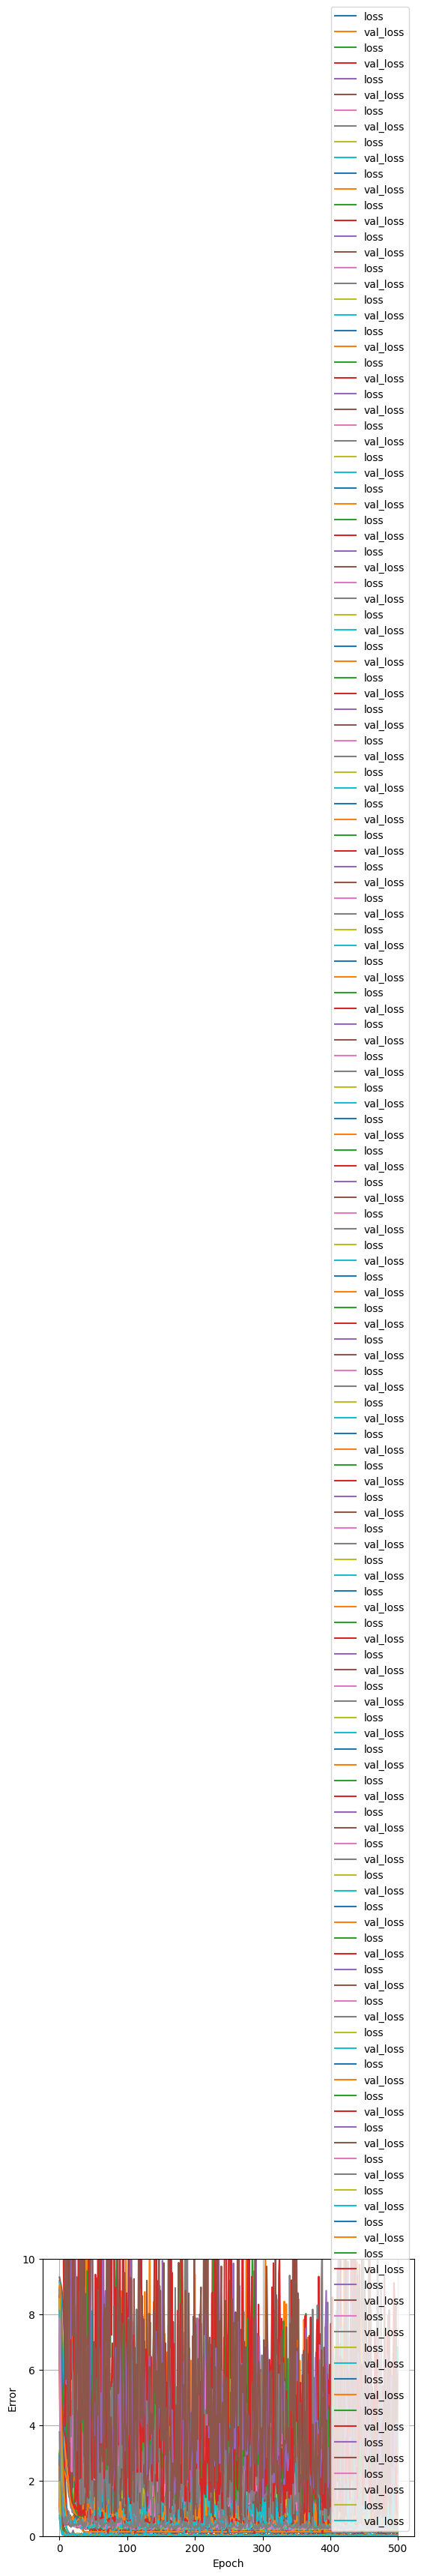

In [23]:
objectives = ['lo', 'so', 'ao', 'po']
potential_neurons = [4, 8, 16, 32]
potential_layers = [2, 3, 4, 5, 6]

for l in potential_layers:
    for n in potential_neurons:
        for obj in objectives:
            dnn_model = build_and_compile_model(normalizer, n, l)
            model_name = str(n) + '-'+ str(l) + '-' + obj

            print("DNN Model: \n", dnn_model.summary(), "\n")
            train_and_save_model(dnn_model, train_features, train_labels[obj], model_name)
            test_model(dnn_model, test_features, test_labels[obj], model_name)

### Regression using a DNN and multiple inputs

Repeat the previous process using all the inputs. The model's performance slightly improves on the validation dataset.

Collect the results on the test set:

In [24]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(train_features, train_labels, verbose=1)

10/10 [==============================] - 0s 3ms/step - loss: 98.1943


### Make predictions

You can now make predictions with the `dnn_model` on the test set using Keras `Model.predict` and review the loss:

In [25]:
y = dnn_model.predict(train_features)

10/10 [==============================] - 0s 3ms/step


In [26]:
np.savetxt("prediction.csv", y, delimiter=",")

In [27]:
test_results['trained'] = dnn_model.evaluate(
    test_features, test_labels, verbose=1)

test_predictions = dnn_model.predict(test_features)

error = test_predictions - test_labels
print(error.abs())
print(error.abs().describe())

3/3 [==============================] - 0s 2ms/step
             lo          so         ao        po
15    74.808000  288.855711  10.304000  0.000771
19    74.761427  348.680927  15.350573  0.000211
22    85.535155   94.287760   5.711365  0.000761
26    85.572658  154.197053   0.748868  0.004539
31    85.576630  229.040761   5.247160  0.002338
..          ...         ...        ...       ...
363  268.095257  109.715389  13.171046  0.031003
384  278.874935  124.751224  12.238935  0.008423
386  278.900147  154.712331   7.264147  0.013028
394  278.879499  274.435262  15.756501  0.012547
399  278.760878  349.156378  26.875122  0.019522

[80 rows x 4 columns]
               lo          so         ao         po
count   80.000000   80.000000  80.000000  80.000000
mean   166.633169  217.248932   9.749363   0.007993
std     62.287913   88.141959   5.966426   0.007430
min     74.761427   64.413031   0.073260   0.000001
25%    107.056698  139.584601   5.239757   0.002137
50%    160.763335  229.344

In [28]:
pd.concat(
    [test_features.copy(), error],
    axis=1)

li          si          lo          so         ao        po
15     0.000000  248.157895  -74.808000 -288.855711  10.304000  0.000771
19     0.000000  305.000000  -74.761427 -348.680927  15.350573  0.000211
22    10.789474   63.421053  -85.535155  -94.287760  -5.711365 -0.000761
26    10.789474  120.263158  -85.572658 -154.197053  -0.748868 -0.004539
31    10.789474  191.315789  -85.576630 -229.040761   5.247160 -0.002338
..          ...         ...         ...         ...        ...       ...
363  194.210526   77.631579 -268.095257 -109.715389 -13.171046  0.031003
384  205.000000   91.842105 -278.874935 -124.751224 -12.238935  0.008423
386  205.000000  120.263158 -278.900147 -154.712331  -7.264147  0.013028
394  205.000000  233.947368 -278.879499 -274.435262  15.756501  0.012547
399  205.000000  305.000000 -278.760878 -349.156378  26.875122  0.019522

[80 rows x 6 columns]

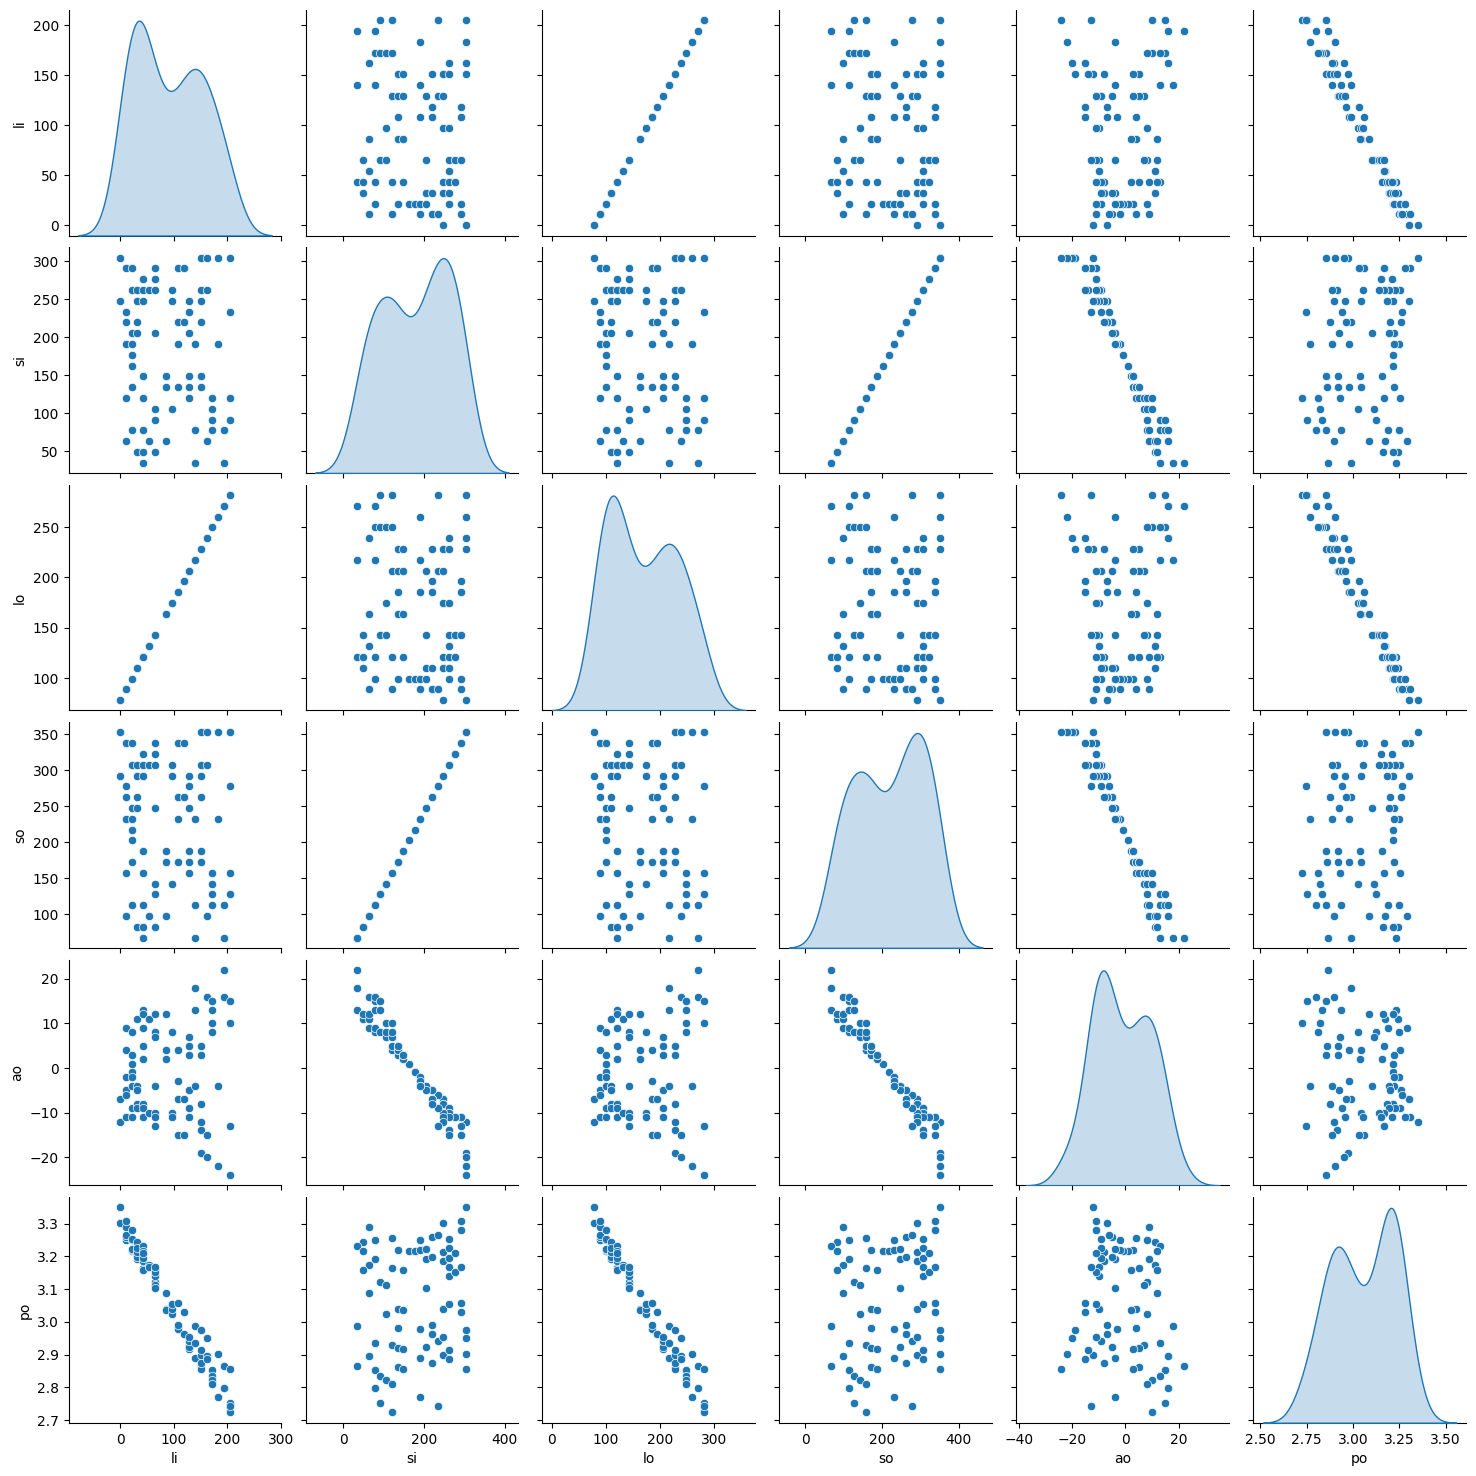

In [29]:
sns.pairplot(test_dataset[['li', 'si', 'lo', 'so','ao','po']], diag_kind='kde')

In [30]:
predictions = pd.DataFrame(test_predictions, columns = ['lo', 'so', 'ao', 'po'])
sns.pairplot(pd.concat(
    [test_features.copy().reset_index(), predictions],
    axis=1)[['li', 'si', 'lo', 'so','ao','po']], 
    diag_kind='kde')

ValueError: Shape of passed values is (80, 1), indices imply (80, 4)

### Save Model

If you're happy with the model, save it for later use with `Model.save`:

In [ ]:
#dnn_model.save('dnn_model_two_layer_64')

### Reload Model

If you reload the model, it gives identical output:

In [ ]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [ ]:
test_predictions = reloaded.predict(test_features)

In [ ]:
# test_case = [li,si]
test_case = [154.8,227.7]
prediction = reloaded.predict(test_case)
print(prediction)

In [ ]:
error = test_predictions - test_labels
'''plt.hist(error, bins=25)
plt.xlabel('Prediction Error [lo]')
_ = plt.ylabel('Count')'''
print(error)
print(error.describe())

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

- Mean squared error (MSE) (`tf.keras.losses.MeanSquaredError`) and mean absolute error (MAE) (`tf.keras.losses.MeanAbsoluteError`) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.
- Similarly, evaluation metrics used for regression differ from classification.
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- Overfitting is a common problem for DNN models, though it wasn't a problem for this tutorial. Visit the [Overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.